In [101]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from multipole_signal import Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [102]:
# Redshift bins

z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95 ])

#z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55 ])


# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.677,
    'As' : 2.05e-9,
    'ns' : 0.965,
    'Ob' : 0.0490, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

# JOINT ANALYSIS. 

### 50x50 vs 70x30 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [103]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_70x30 = derivatives_dict['split_70x30']

In [104]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [105]:
dsignal_dsbias70 = derivatives_70x30['dsignal_dsbias']

dsignal_dgbias70 = derivatives_70x30['dsignal_dgbias']

dsignal_dcosmic70 = derivatives_70x30['dsignal_dcosmic']

dsignal_dnum70 = derivatives_70x30['dsignal_dnumev']

np.shape(dsignal_dsbias70), np.shape(dsignal_dgbias70), np.shape(dsignal_dcosmic70), np.shape(dsignal_dnum70)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [106]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [107]:
dsignal_dtheta70 = np.concatenate([dsignal_dsbias70, dsignal_dnum70, dsignal_dgbias70, dsignal_dcosmic70])

np.shape(dsignal_dtheta70)

(21, 19, 324)

REMOVE HEXADECAPOLE FROM 50x50 split

In [108]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove = list(range(7*n_sep,8*n_sep))

print('Number of separations = ', n_sep)
print('Number of signals = ', n_signals)
print('Indices to remove = ', ind_to_remove)

Number of separations =  36
Number of signals =  9
Indices to remove =  [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [109]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB70 = np.concatenate([np.zeros_like(dsignal_dsbias70[:4]), dsignal_dsbias70[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias70[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum70], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias70 = np.concatenate([np.zeros_like(dsignal_dgbias70[:4]), dsignal_dgbias70], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic70], axis=2)

In [110]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB70, dsignal_dsM, dsignal_dnum, dsignal_dgbias50, dsignal_dgbias70, dsignal_dcosmic])

dsignal_dtheta_multi = np.delete(dsignal_dtheta_multi_, ind_to_remove, axis=2)


np.shape(dsignal_dtheta_multi_), np.shape(dsignal_dtheta_multi)

((29, 19, 648), (29, 19, 612))

## Covariance Matrix

In [111]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82700205, -1.01878441, -0.30342325])
sB_4fit70 = np.array([-0.93372809,  1.82432411, -0.92835543, -0.24102824])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_70 = sB_4fit70 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_70**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (29, 29))

In [112]:
Cov_Multipoles_Joint50x70_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,70], rtol=1e-4, contributions='all')

print('\n ... Remove the HEXADECAPOLE from 50x50 split ... \n')

Cov_Multipoles_Joint50x70 = np.delete(Cov_Multipoles_Joint50x70_, ind_to_remove, axis=1)
Cov_Multipoles_Joint50x70 = np.delete(Cov_Multipoles_Joint50x70, ind_to_remove, axis=2)

np.shape(Cov_Multipoles_Joint50x70_), np.shape(Cov_Multipoles_Joint50x70)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [all] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Remove the HEXADECAPOLE from 50x50 split ... 



((19, 648, 648), (19, 612, 612))

In [113]:
# Check if Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Cov_Multipoles_Joint50x70_[n], Cov_Multipoles_Joint50x70_[n].T, rtol = 1e-15), np.allclose(Cov_Multipoles_Joint50x70[n], Cov_Multipoles_Joint50x70[n].T, rtol = 1e-15))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [114]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x70_ = np.linalg.pinv(Cov_Multipoles_Joint50x70)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x70 = [0.5 * (Inv_Cov_Multipoles_Joint50x70_[i] + Inv_Cov_Multipoles_Joint50x70_[i].T) for i in range(len(z_bins))]

In [115]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x70_[n], Inv_Cov_Multipoles_Joint50x70_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x70[n], Inv_Cov_Multipoles_Joint50x70[n].T, rtol = 1e-3))

0 False True
1 False True
2 False True
3 False True
4 False True
5 False True
6 False True
7 False True
8 False True
9 False True
10 False True
11 False True
12 False True
13 False True
14 False True
15 False True
16 False True
17 False True
18 False True


In [116]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x70_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x70_, z_bins = z_bins)
Fisher_Matrix_Joint50x70 = Fisher_Matrix_Joint50x70_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x70)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(29, 29)

In [117]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[:8,:8]]))

293883.3873619783	64520.41091809922	-500434.43569703295	926425.8360475277	-402904.8099238071	-90616.26825827466	677546.6961318412	-1246167.127596725
64520.41091809922	25577.479663708484	-81569.02563890397	143799.62831392107	-90616.26825827466	-36096.26936464521	112618.45417360132	-195222.02342959453
-500434.4356970329	-81569.02563890397	926429.6899028813	-1740690.940442613	677546.6961318413	112618.4541736013	-1246167.127596725	2334236.3644597353
926425.8360475274	143799.62831392107	-1740690.9404426133	3289705.427591201	-1246167.1275967248	-195222.0234295945	2334236.364459735	-4404247.20954578
-402904.8099238067	-90616.26825827449	677546.6961318409	-1246167.1275967257	630173.8167283216	162739.85859628796	-993241.7009272034	1780619.9146181347
-90616.2682582745	-36096.269364645144	112618.45417360115	-195222.02342959447	162739.85859628802	73782.97148615208	-176695.62959566197	290018.95003973355
677546.6961318407	112618.45417360115	-1246167.1275967255	2334236.3644597353	-993241.7009272033	-

In [118]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[8:16,8:16]]))

141921.0481892172	67206.71052343454	-128556.99567532101	163771.20265336888	1563.3342943409218	869.0650432052876	2881.108265889511	915.8410789375833
67206.71052343448	42151.201516391666	-40044.386028121226	42752.23285835472	869.0650432052857	558.911737870281	1563.3342943409184	472.9670104784327
-128556.995675321	-40044.386028121255	164427.61349805738	-237542.94079647696	-989.4696005165725	-455.06469971416374	-1518.3758048371567	-621.2824509549127
163771.20265336861	42752.232858354684	-237542.94079647659	505647.868117596	695.4587570235049	371.1357249709943	-214.30714044900148	396.1869851059704
1563.3342943408832	869.0650432052718	-989.469600516538	695.4587570234837	82.64627024046737	35.037692671871525	262.7949095864991	55.408550844833414
869.0650432052702	558.911737870275	-455.0646997141479	371.1357249709812	35.037692671871476	19.437729709593846	82.5829178495472	20.832895585695912
2881.108265889411	1563.3342943408813	-1518.3758048370637	-214.307140449063	262.79490958649876	82.58291784954

In [119]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[16:,16:]]))

19172245.76003135	6453957.696555777	-27659520.91758241	-10126666.714478536	-2119313.01435448	-1239512.7143137124	6561719.408293638	3387982.8462309986	717715.908028918	439460.84693663457	-509888.1082819268	-1690434.875405349	-1072410.1851609598
6453957.69655578	2677905.7800147887	-10126666.714478534	-4653775.196990364	-1239512.714313704	-628588.273330783	3387982.8462310005	1948389.1456935355	412254.30501468864	218413.29279066733	-193792.03404642217	-1132462.0519338232	-283493.49804171553
-27659520.917698134	-10126666.714513535	34151536.31521209	12035906.366239425	6364223.010114585	3826515.2462353352	-2316793.0563762733	-1847554.6974261417	80871.32025593291	-221471.98342815554	778485.7434669213	-1127556.4382758338	3874375.839313653
-10126666.714513544	-4653775.197001067	12035906.366239404	5119184.288600486	3826515.246235334	2453682.643047319	-1847554.6974261582	-1186697.5004196663	14105.278241172799	-83617.69440716525	274402.20918950706	-351730.9765645622	1218069.688134821
-2119313.01426

In [120]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[16:24,16:24]]))

19172245.76003135	6453957.696555777	-27659520.91758241	-10126666.714478536	-2119313.01435448	-1239512.7143137124	6561719.408293638	3387982.8462309986
6453957.69655578	2677905.7800147887	-10126666.714478534	-4653775.196990364	-1239512.714313704	-628588.273330783	3387982.8462310005	1948389.1456935355
-27659520.917698134	-10126666.714513535	34151536.31521209	12035906.366239425	6364223.010114585	3826515.2462353352	-2316793.0563762733	-1847554.6974261417
-10126666.714513544	-4653775.197001067	12035906.366239404	5119184.288600486	3826515.246235334	2453682.643047319	-1847554.6974261582	-1186697.5004196663
-2119313.014265703	-1239512.7142879323	6364223.009962423	3826515.2461902257	13884515.461394185	5039853.419153016	-17792709.873203557	-7111403.431513141
-1239512.7142879332	-628588.2733230473	3826515.2461902197	2453682.643033599	5039853.419153016	1985733.230108283	-7111403.431513133	-3376570.085384431
6561719.408326497	3387982.846242802	-2316793.056356981	-1847554.6974224101	-17792709.8732673

In [121]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[24:,24:]]))

4279240.285727179	1426172.1589276886	335672.89148788655	-15856878.538782034	4994453.884334152
1426172.158927368	511620.575370711	50108.8277060245	-5011346.670410386	1616281.0920224995
335672.89148792985	50108.82770611788	229727.9617909586	-1322022.5200634338	1019513.6631832528
-15856878.538778909	-5011346.670410722	-1322022.5200625805	65375013.643606514	-17570258.208513547
4994453.884332835	1616281.0920227936	1019513.6631829721	-17570258.208513573	9797194.856133094


In [122]:
print(np.allclose(Fisher_Matrix_Joint50x70, Fisher_Matrix_Joint50x70.T, rtol=1e-6))

True


In [123]:
print(np.allclose(Fisher_Matrix_Joint50x70[:-5,:-5], Fisher_Matrix_Joint50x70[:-5,:-5].T, rtol=1e-6))

True


In [124]:
np.linalg.det(Fisher_Matrix_Joint50x70)

2.709333066842338e+122

In [125]:
Fisher_Matrix_Joint50x70__ = 0.5 * (Fisher_Matrix_Joint50x70 + Fisher_Matrix_Joint50x70.T)

In [126]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70__[16:,16:]]))

19172245.76003135	6453957.696555778	-27659520.917640273	-10126666.714496039	-2119313.0143100917	-1239512.714300823	6561719.408310068	3387982.846236896	717715.9080211516	439460.84693451226	-509888.10828412464	-1690434.8753674366	-1072410.1851717946
6453957.696555778	2677905.7800147887	-10126666.714496035	-4653775.196995716	-1239512.7143008183	-628588.2733269152	3387982.8462369014	1948389.1456954556	412254.30501203344	218413.2927899569	-193792.03404715692	-1132462.0519213397	-283493.4980454843
-27659520.917640273	-10126666.714496035	34151536.31521209	12035906.366239414	6364223.010038504	3826515.2462127777	-2316793.056366627	-1847554.697424286	80871.32026578404	-221471.9834253459	778485.743469415	-1127556.4383209809	3874375.839324899
-10126666.714496039	-4653775.196995716	12035906.366239414	5119184.288600486	3826515.2462127795	2453682.6430404587	-1847554.6974242842	-1186697.5004192102	14105.27824460001	-83617.694406219	274402.20919038064	-351730.9765796402	1218069.6881390084
-2119313.0143

In [127]:
np.linalg.det(Fisher_Matrix_Joint50x70[:-5, :-5])

1.2701762879598191e+95

In [128]:
np.linalg.det(Fisher_Matrix_Joint50x70__[:-5, :-5])

1.2701762879176896e+95

In [129]:
np.linalg.det(Fisher_Matrix_Joint50x70__)

2.709333066758404e+122

In [130]:
np.linalg.det(Fisher_Matrix_Joint50x70)

2.709333066842338e+122

## Constraints

In [131]:
#Absolute Errors

Sigma_Matrix_Joint50x70 = np.linalg.pinv(Fisher_Matrix_Joint50x70)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x70))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit70]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [27.41775672 15.22172552 22.38266041 21.29089112]

sB_30 =  [18.93211155 12.54988917 18.72240113 22.07373187]

s_model =  [35.2675967  18.44102818 35.83025494 49.65085206]

number =  [41.00092701 25.49614657 20.58476437 27.66743657]

gbias_50 =  [0.28069126 0.44331596 0.24566747 0.33365019]

gbias_30 =  [0.2185857  0.37742949 0.27950087 0.40879886]

cosmic =  [1.63003349 0.97438992 1.44329351 1.59751532 0.7539372 ]



In [132]:
np.linalg.det(Fisher_Matrix_Joint50x70), np.linalg.det(Sigma_Matrix_Joint50x70)

(2.709333066842338e+122, 3.690945245614117e-123)

In [133]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [134]:
print(isPSD(Fisher_Matrix_Joint50x70[:-5,:-5], tol=1e-10))

(array([ 6.69643476e+07,  3.30007514e+07,  1.30285484e+07, -8.94730392e+06,
        1.83323887e+06,  1.43509096e+06,  5.65844825e+05, -4.18437227e+05,
        4.69405687e+05,  2.12841051e+05,  1.22282954e+05,  7.13409904e+04,
        6.46792498e+04,  2.81881864e+04,  9.07961985e+03,  6.95544962e+02,
        5.17235814e+02,  4.47070683e+01,  2.04292913e+01,  1.31982737e+01,
        5.62079242e+00,  5.53838464e-01,  1.18973004e-01,  3.41573432e-02]), False)


In [47]:
print(isPSD(Sigma_Matrix_Joint50x70, tol=1e-10))

(array([ 2.92768010e+01,  8.40537661e+00,  1.80651403e+00,  1.77921212e-01,
        7.57859429e-02,  4.89575887e-02,  2.23956827e-02,  1.95835184e-03,
        1.43779492e-03,  1.18089936e-03,  1.10289448e-04,  3.55388454e-05,
        2.36229038e-05,  1.52517560e-05,  1.22939951e-05,  8.12718457e-06,
        4.70898225e-06,  3.83100279e-06, -2.25319898e-06,  2.14329757e-06,
        1.76787166e-06,  1.04485560e-06,  6.40312281e-07,  2.35577952e-07,
       -1.08686711e-07,  7.68158708e-08,  3.02686631e-08,  1.29327981e-08,
        1.50876804e-08]), False)


In [48]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x70)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [7.73227878e+07 6.62792408e+07 3.30374684e+07 1.30181431e+07
 9.20075683e+06 4.24487942e+06 1.56173797e+06 9.57070052e+05
 5.65651919e+05 4.66570771e+05 4.43813445e+05 2.61028262e+05
 2.12360112e+05 1.23043840e+05 8.13405238e+04 6.55662208e+04
 4.23317983e+04 2.81382242e+04 9.06705055e+03 8.46812213e+02
 6.95509481e+02 5.10633473e+02 4.46514632e+01 2.04258426e+01
 1.31950592e+01 5.62046530e+00 5.53552303e-01 1.18971469e-01
 3.41567373e-02]
Condition number of A: 2263763870.645649


In [49]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x70.shape[0], Fisher_Matrix_Joint50x70.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x70 @ A_plus

In [50]:
np.allclose(A_plus, Sigma_Matrix_Joint50x70, rtol=1e-20)

True

In [51]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x70)

(3.69094524547082e-123, 3.6909452449402204e-123)

In [52]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x70)

(2.7093330663808138e+122, 2.709333066842338e+122)

## Triangle Plots

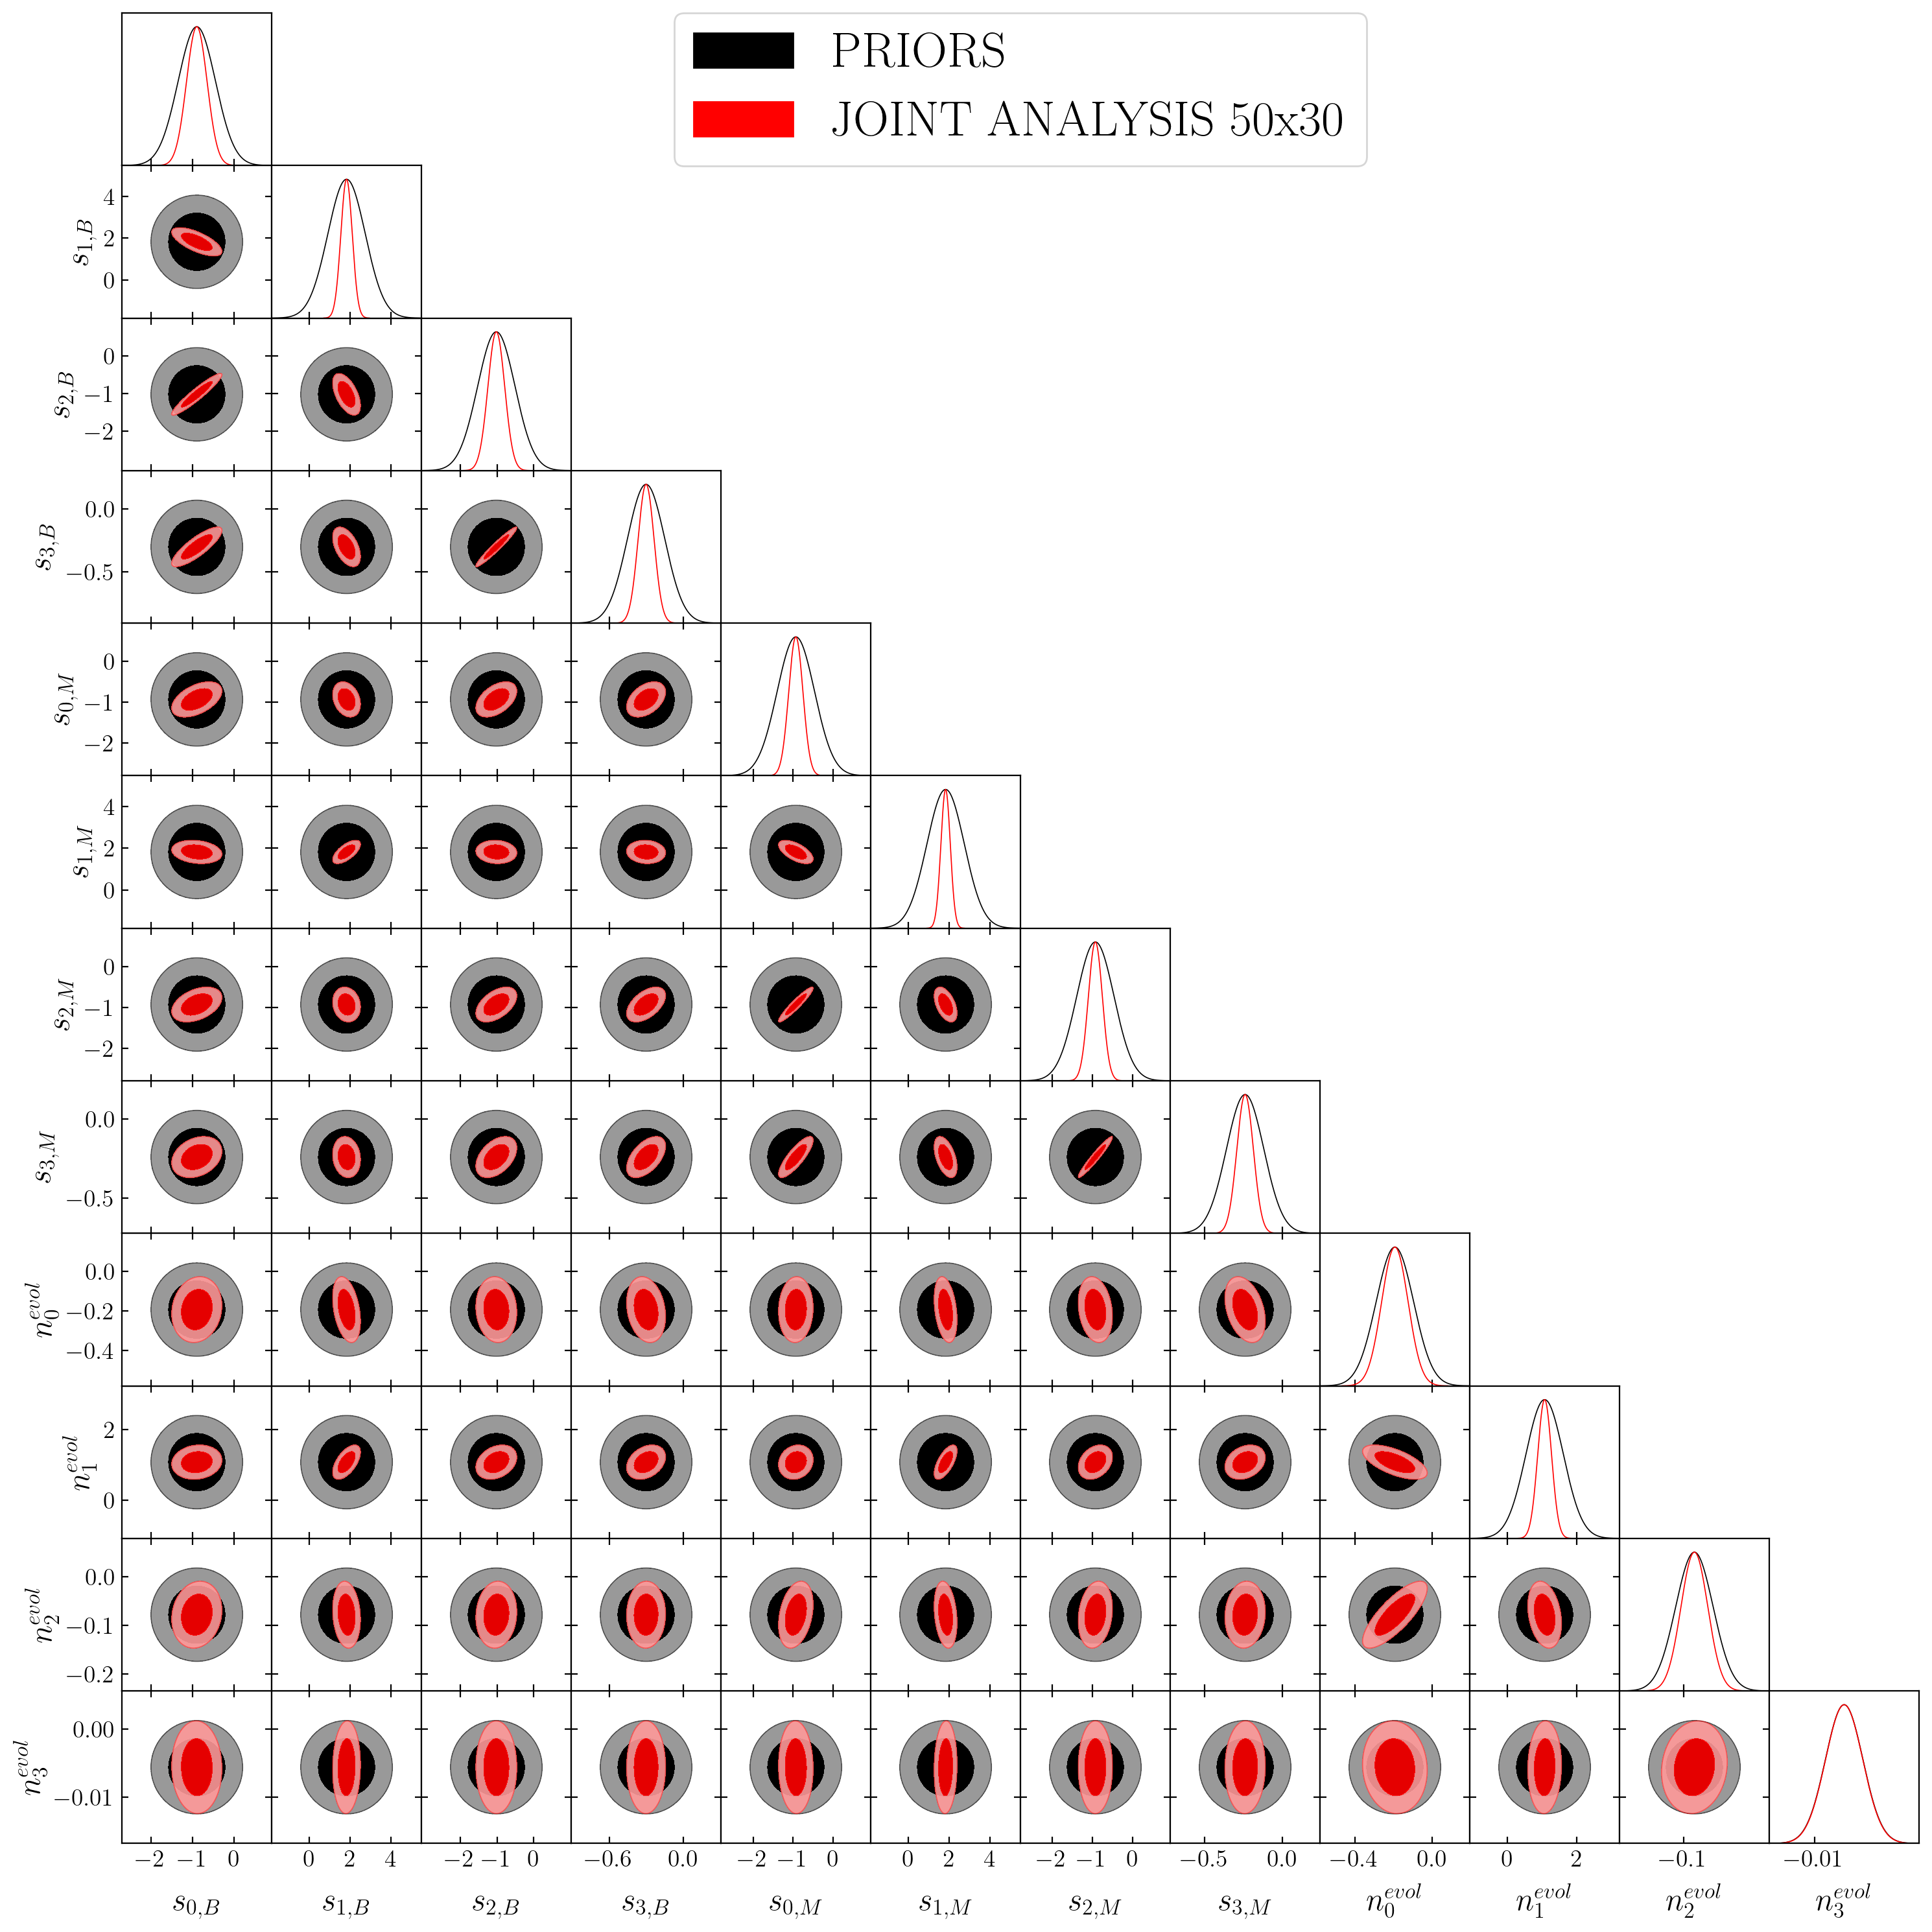

In [53]:
# Triangle plot

mean = params_fid[:-13]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit70))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_sbias_nevol_fit = GaussianND(mean, Sigma_Matrix_Joint50x70[:-13,:-13], labels = labels, names = param_names)
GaussDist_priors_sbias_nevol_fit = GaussianND(mean, Cov_prior_all, labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_priors_sbias_nevol_fit, GaussDist_sbias_nevol_fit], param_names, 
                filled=True, 
                legend_labels=['PRIORS', 'JOINT ANALYSIS 50x70'],
                contour_colors=['black', 'red'])

/Users/danielsb/opt/anaconda3/envs/camb/lib/python3.9/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


DensitiesError: Contour level outside plotted ranges

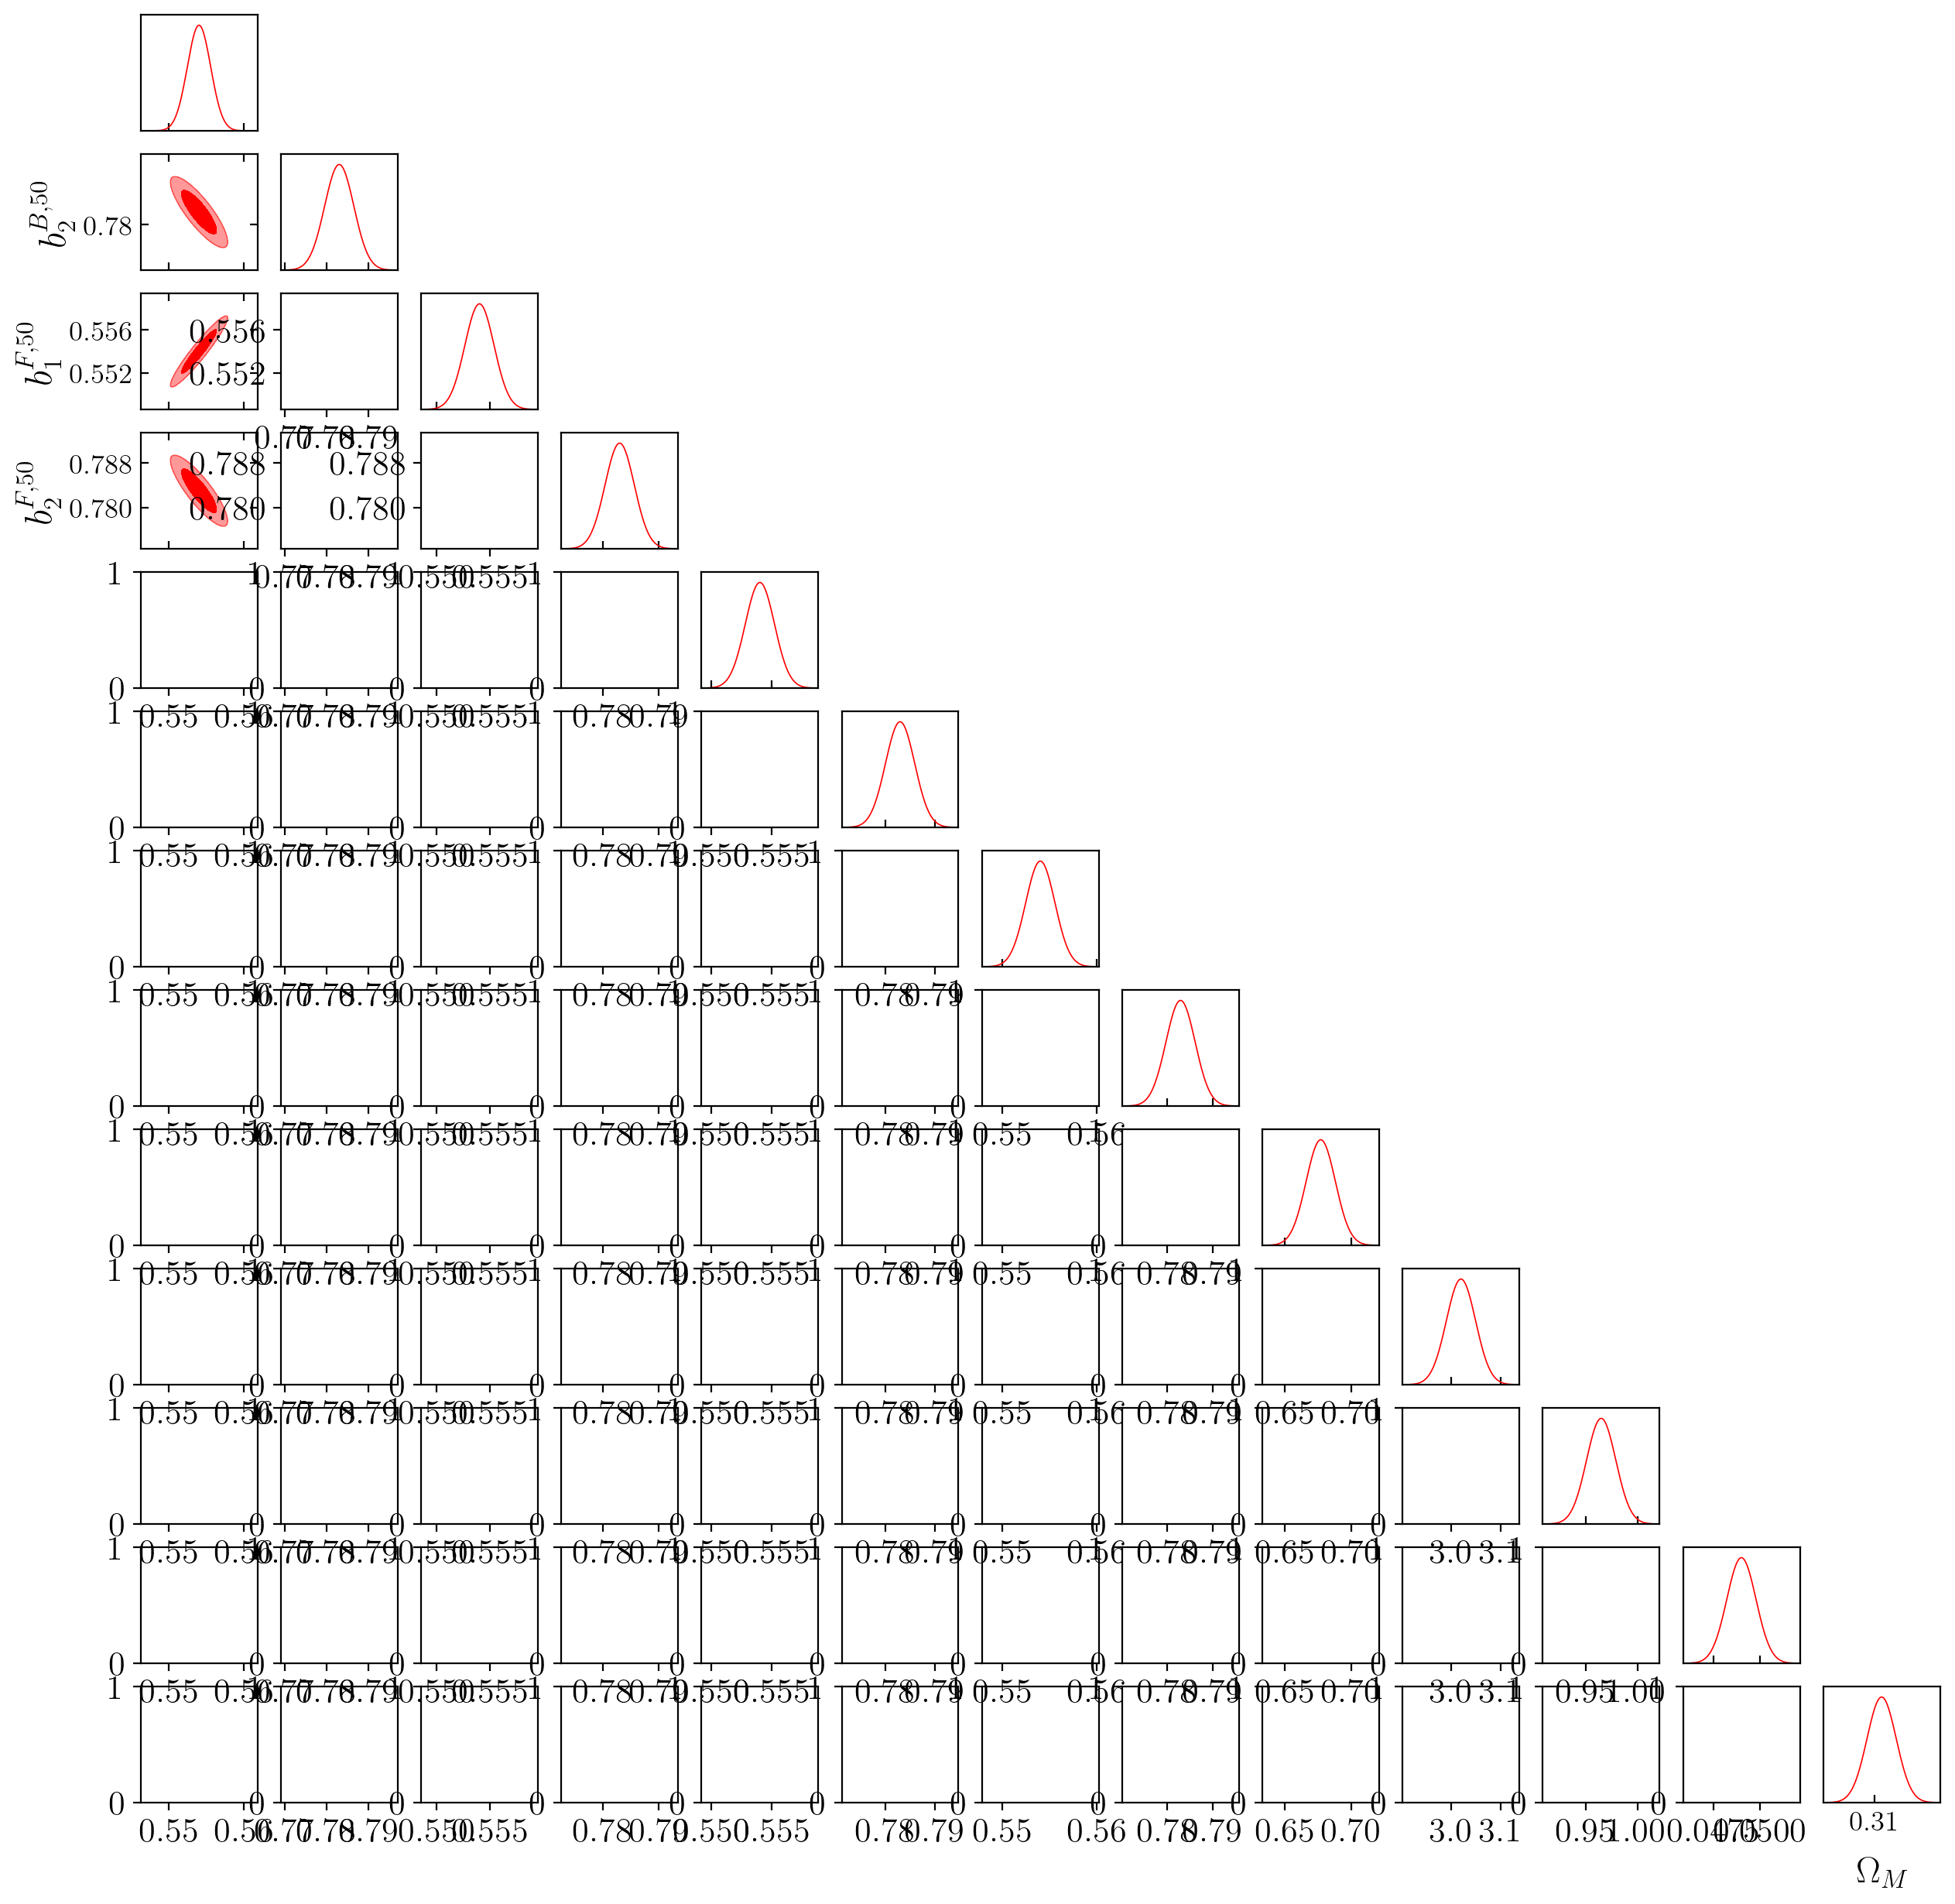

In [54]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean = params_fid[16:]

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1'] + ['b1B_m2', 'b2B_m2', 'b1F_m2', 'b2F_m2']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B,50}', r'b_2^{B,50}', r'b_1^{F,50}', r'b_2^{F,50}'] + [r'b_1^{B,30}', r'b_2^{B,30}', r'b_1^{F,30}', r'b_2^{F,30}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean, Sigma_Matrix_Joint50x70[16:,16:], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot(GaussDist_gbias_cosmic_fit, param_names, 
                filled=True, 
                legend_labels=['JOINT ANALYSIS 50x30'],
                contour_colors=['red'])

In [55]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x70[24:,24:]]))

4279240.285727179	1426172.1589276886	335672.89148788655	-15856878.538782034	4994453.884334152
1426172.158927368	511620.575370711	50108.8277060245	-5011346.670410386	1616281.0920224995
335672.89148792985	50108.82770611788	229727.9617909586	-1322022.5200634338	1019513.6631832528
-15856878.538778909	-5011346.670410722	-1322022.5200625805	65375013.643606514	-17570258.208513547
4994453.884332835	1616281.0920227936	1019513.6631829721	-17570258.208513573	9797194.856133094


In [56]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x70[24:,24:]]))

0.00012177843575425118	-0.0003173608239085717	-0.00014359407385489036	7.895957369025727e-06	2.2096053462997728e-05
-0.0003173608239091816	0.000866167022604368	0.00039489395922722006	-1.902883612928424e-05	-6.379911279328485e-05
-0.00014359407385528404	0.000394893959227525	0.000193983120628281	-8.412917902268603e-06	-3.1070690095473725e-05
7.895957369003767e-06	-1.902883612918771e-05	-8.41291790221744e-06	6.127484504414238e-07	1.2399705920097015e-06
2.2096053463163743e-05	-6.379911279360973e-05	-3.107069009559985e-05	1.2399705920242849e-06	5.501363836675332e-06


In [57]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x70[16:24,16:24]]))

2.4181170463654816e-06	-4.528267858489944e-06	2.0016344263985233e-06	-3.4613698223250248e-06	2.114891919210941e-06	-4.016172004244389e-06	2.4606433904251456e-06	-4.327530596069626e-06
-4.52826785848415e-06	1.2048979416127238e-05	-3.583441975418824e-06	8.042150645075158e-06	-4.161609488965831e-06	1.1005704404254824e-05	-4.984129205115408e-06	1.0644076077651262e-05
2.0016344264023633e-06	-3.5834419754325875e-06	1.8523149373324332e-06	-3.2131211420565056e-06	1.8035517413951734e-06	-3.302435897719881e-06	2.1875663738388065e-06	-3.8596001843670966e-06
-3.4613698223305635e-06	8.04215064509651e-06	-3.2131211420547734e-06	6.825057083081868e-06	-3.2886757907837905e-06	7.741935306728559e-06	-4.13154211963971e-06	8.596395131360596e-06
2.1148919192119796e-06	-4.161609488968882e-06	1.8035517413915534e-06	-3.288675790777815e-06	1.466435635916358e-06	-3.0816146055326586e-06	1.5829146309953252e-06	-2.9713258784118764e-06
-4.016172004239981e-06	1.1005704404251424e-05	-3.302435897707405e-06	7.7419353067

In [58]:
np.allclose(Sigma_Matrix_Joint50x70[16:24,16:24], Sigma_Matrix_Joint50x70[16:24,16:24].T, rtol=1e-2)

True

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [59]:
len(dsignal_dgbias50[1,1])/2

324.0

In [60]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[:,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 324)

In [61]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [62]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [63]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [64]:
np.linalg.det(Fisher_Matrix_50)

1.8938868130876945e+78

In [65]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [29.96774205 19.61781455 25.09483053 24.14537789]

smodel =  [39.3265274  28.18633306 45.1358961  49.94441827]

number =  [41.26984319 30.59209475 25.60703335 30.66246173]

gbias =  [0.25908924 0.38871751 0.23707301 0.30779066]

cosmic =  [1.32237597 0.74757499 1.11488567 1.39619212 0.55642467]


In [66]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [67]:
np.linalg.det(Sigma_Matrix_50)

5.280146591073765e-79

In [68]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [9.81374355e+07 7.54170157e+07 5.29395903e+06 1.89782931e+06
 1.15098256e+06 3.37941194e+05 3.01888063e+05 1.35390102e+05
 9.04898413e+04 8.10574855e+04 6.83924846e+04 1.79116310e+04
 1.43067548e+03 7.49909470e+02 1.82873896e+02 1.72912680e+01
 1.01659920e+01 5.69895900e+00 4.27443932e-01 6.46880976e-02
 3.28061811e-02]
Condition number of A: 2991431250.4270115


In [69]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [70]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [71]:
len(dsignal_dgbias70[1,1])/2

324.0

In [72]:
dsignal_dtheta_fit_all70 = np.concatenate([dsignal_dsbias70, dsignal_dnum70, dsignal_dgbias70[:,:,324:], dsignal_dcosmic70])

np.shape(dsignal_dtheta_fit_all70)

(21, 19, 324)

In [74]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_70 = np.diag(np.concatenate([dsB_70**2, dsM**2, dnum**2]))

Inv_Cov_prior_70_ = np.linalg.inv(Cov_priors_70)

Inv_Cov_prior_70 = np.zeros([len(dsignal_dtheta_fit_all70), len(dsignal_dtheta_fit_all70)])
Inv_Cov_prior_70[:len(Inv_Cov_prior_70_), :len(Inv_Cov_prior_70_)] = Inv_Cov_prior_70_

np.shape(Cov_priors_70)

(12, 12)

In [75]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_70 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[70, 30], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_70_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all70, inv_cov = Inv_Cov_Multipoles_70, z_bins = z_bins)

Fisher_Matrix_70 = Fisher_Matrix_70_ + Inv_Cov_prior_70

np.shape(Fisher_Matrix_70)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [76]:
np.allclose(Fisher_Matrix_70, Fisher_Matrix_70.T, rtol=1e-9)

True

In [77]:
np.linalg.det(Fisher_Matrix_70)

5.134111284570796e+78

In [78]:
Sigma_Matrix_70 = np.linalg.inv(Fisher_Matrix_70)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_70))

# Fiducial values

sbias_fit_70 = np.concatenate([sB_4fit70, sM_4fit])
gbias_fit_70 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_70, num_fit, gbias_fit_70, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_70)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_70)/2):len(sbias_fit_70)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_70):(len(sbias_fit_70) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_70) + len(num_fit)):(len(sbias_fit_70) + len(num_fit) + len(gbias_fit_70))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_70) + len(num_fit)+len(gbias_fit_70)):])


------------ Relative errors * 100 ------------

sB =  [23.79367412 17.66344048 23.35843803 27.44750314]

smodel =  [37.39823657 27.38313171 41.34799996 49.84126079]

number =  [41.62482069 32.22702174 26.74488361 31.5191212 ]

gbias =  [0.22258817 0.36930844 0.25476396 0.35536871]

cosmic =  [1.57312875 0.92582206 1.3644836  1.57066034 0.71476614]


In [79]:
np.allclose(Sigma_Matrix_70, Sigma_Matrix_70.T, rtol=1e-20)

True

In [80]:
np.linalg.det(Sigma_Matrix_70)

1.9477567675790457e-79

In [81]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_70)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [3.12608773e+01 1.71774875e+01 2.83082930e+00 1.36434635e-01
 1.10979225e-01 6.39729668e-02 6.04532256e-03 1.06537645e-03
 6.30604366e-04 3.20299088e-05 1.32036237e-05 1.07023651e-05
 9.35364558e-06 3.18275966e-06 2.87608023e-06 2.07027116e-06
 1.21811440e-06 5.26835057e-07 2.17020301e-07 2.28718842e-08
 1.27441610e-08]
(Log)-Condition number of A: 9.38968991222777


In [82]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_70.shape[0], Sigma_Matrix_70.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_70 @ A_plus

In [84]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.9477567678498998e-79


In [85]:
np.allclose(A_plus, Fisher_Matrix_70, rtol=1e-7)

True

Comparison with result of combined analysis

In [86]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [27.41775672 15.22172552 22.38266041 21.29089112]

sB_30 =  [18.93211155 12.54988917 18.72240113 22.07373187]

s_model =  [35.2675967  18.44102818 35.83025494 49.65085206]

number =  [41.00092701 25.49614657 20.58476437 27.66743657]

gbias_50 =  [0.28069126 0.44331596 0.24566747 0.33365019]

gbias_30 =  [0.2185857  0.37742949 0.27950087 0.40879886]

cosmic =  [1.63003349 0.97438992 1.44329351 1.59751532 0.7539372 ]



# Numerical comparison

In [94]:
cosmic50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic70x30 = par_errors_all_30[(len(sbias_fit_70) + len(num_fit) + len(gbias_fit_70)):]

cosmicjoint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [95]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm70x30 = par_errors_all_30[int(len(sbias_fit_70)/2):len(sbias_fit_70)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB70x30 = par_errors_all_30[0:int(len(sbias_fit_70)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB70joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [96]:
np.shape(par_errors_all_Joint)

(29,)

In [97]:
gbias50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias70x30 = par_errors_all_30[(len(sbias_fit_70) + len(num_fit)):(len(sbias_fit_70) + len(num_fit) + len(gbias_fit_70))]

gbias50joint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias70joint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [98]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num70x30 = par_errors_all_30[len(sbias_fit_70):(len(sbias_fit_70) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [99]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint/gbias50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic50x50) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB70joint/sB70x30) * 100, '\n')
print(' Dgbias = ',  (1-gbias70joint/gbias70x30) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm70x30) * 100, '\n')
print(' Dnum = ', (1-numjoint/num70x30) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic70x30) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [ 8.50910065 22.40865829 10.80768454 11.82208366] 

 Dgbias =  [ -8.33767592 -14.04579184  -3.62523825  -8.40166223] 

 Dsmodel =  [10.32110121 34.57457507 20.61694121  0.58778581] 

 Dnum =  [ 0.65160455 16.65772881 19.61284976  9.76772571] 

 Dcosmic =  [-23.26551003 -30.34009075 -29.4566384  -14.41944762 -35.49672323] 


 Difference Joint vs 30x70 

 DsB =  [20.43216422 28.94991673 19.84737548 19.57836106] 

 Dgbias =  [  1.79815175  -2.19898936  -9.70973602 -15.03513098] 

 Dsmodel =  [ 5.69716667 32.6555181  13.34464793  0.38203033] 

 Dnum =  [ 1.49885013 20.88581198 23.03288855 12.22015235] 

 Dcosmic =  [-3.61729713 -5.24591728 -5.77580483 -1.70978877 -5.48026222] 



In [100]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB70x30) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50/gbias70x30) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm70x30) * 100, '\n')
print(' Dnum = ', (1-num50x50/num70x30) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50/cosmic70x30) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [-25.94835881 -11.06451526  -7.43368412  12.03069449] 

 Dgbias =  [-16.39847844  -5.25551801   6.94405817  13.38836042] 

 Dsmodel =  [-5.15610093 -2.93319756 -9.16101419 -0.20697204] 

 Dnum =  [0.85280248 5.07315568 4.25445955 2.71790406] 

 Dcosmic =  [15.939749   19.25284333 18.292483   11.10795333 22.15290546] 



# Triangle Plots

In [80]:
np.shape(params_fid), np.shape(params_fid_50)

((29,), (21,))

In [81]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x70_ = Sigma_Matrix_Joint50x70

Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=0)
Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x70_)

(25, 25)

In [82]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

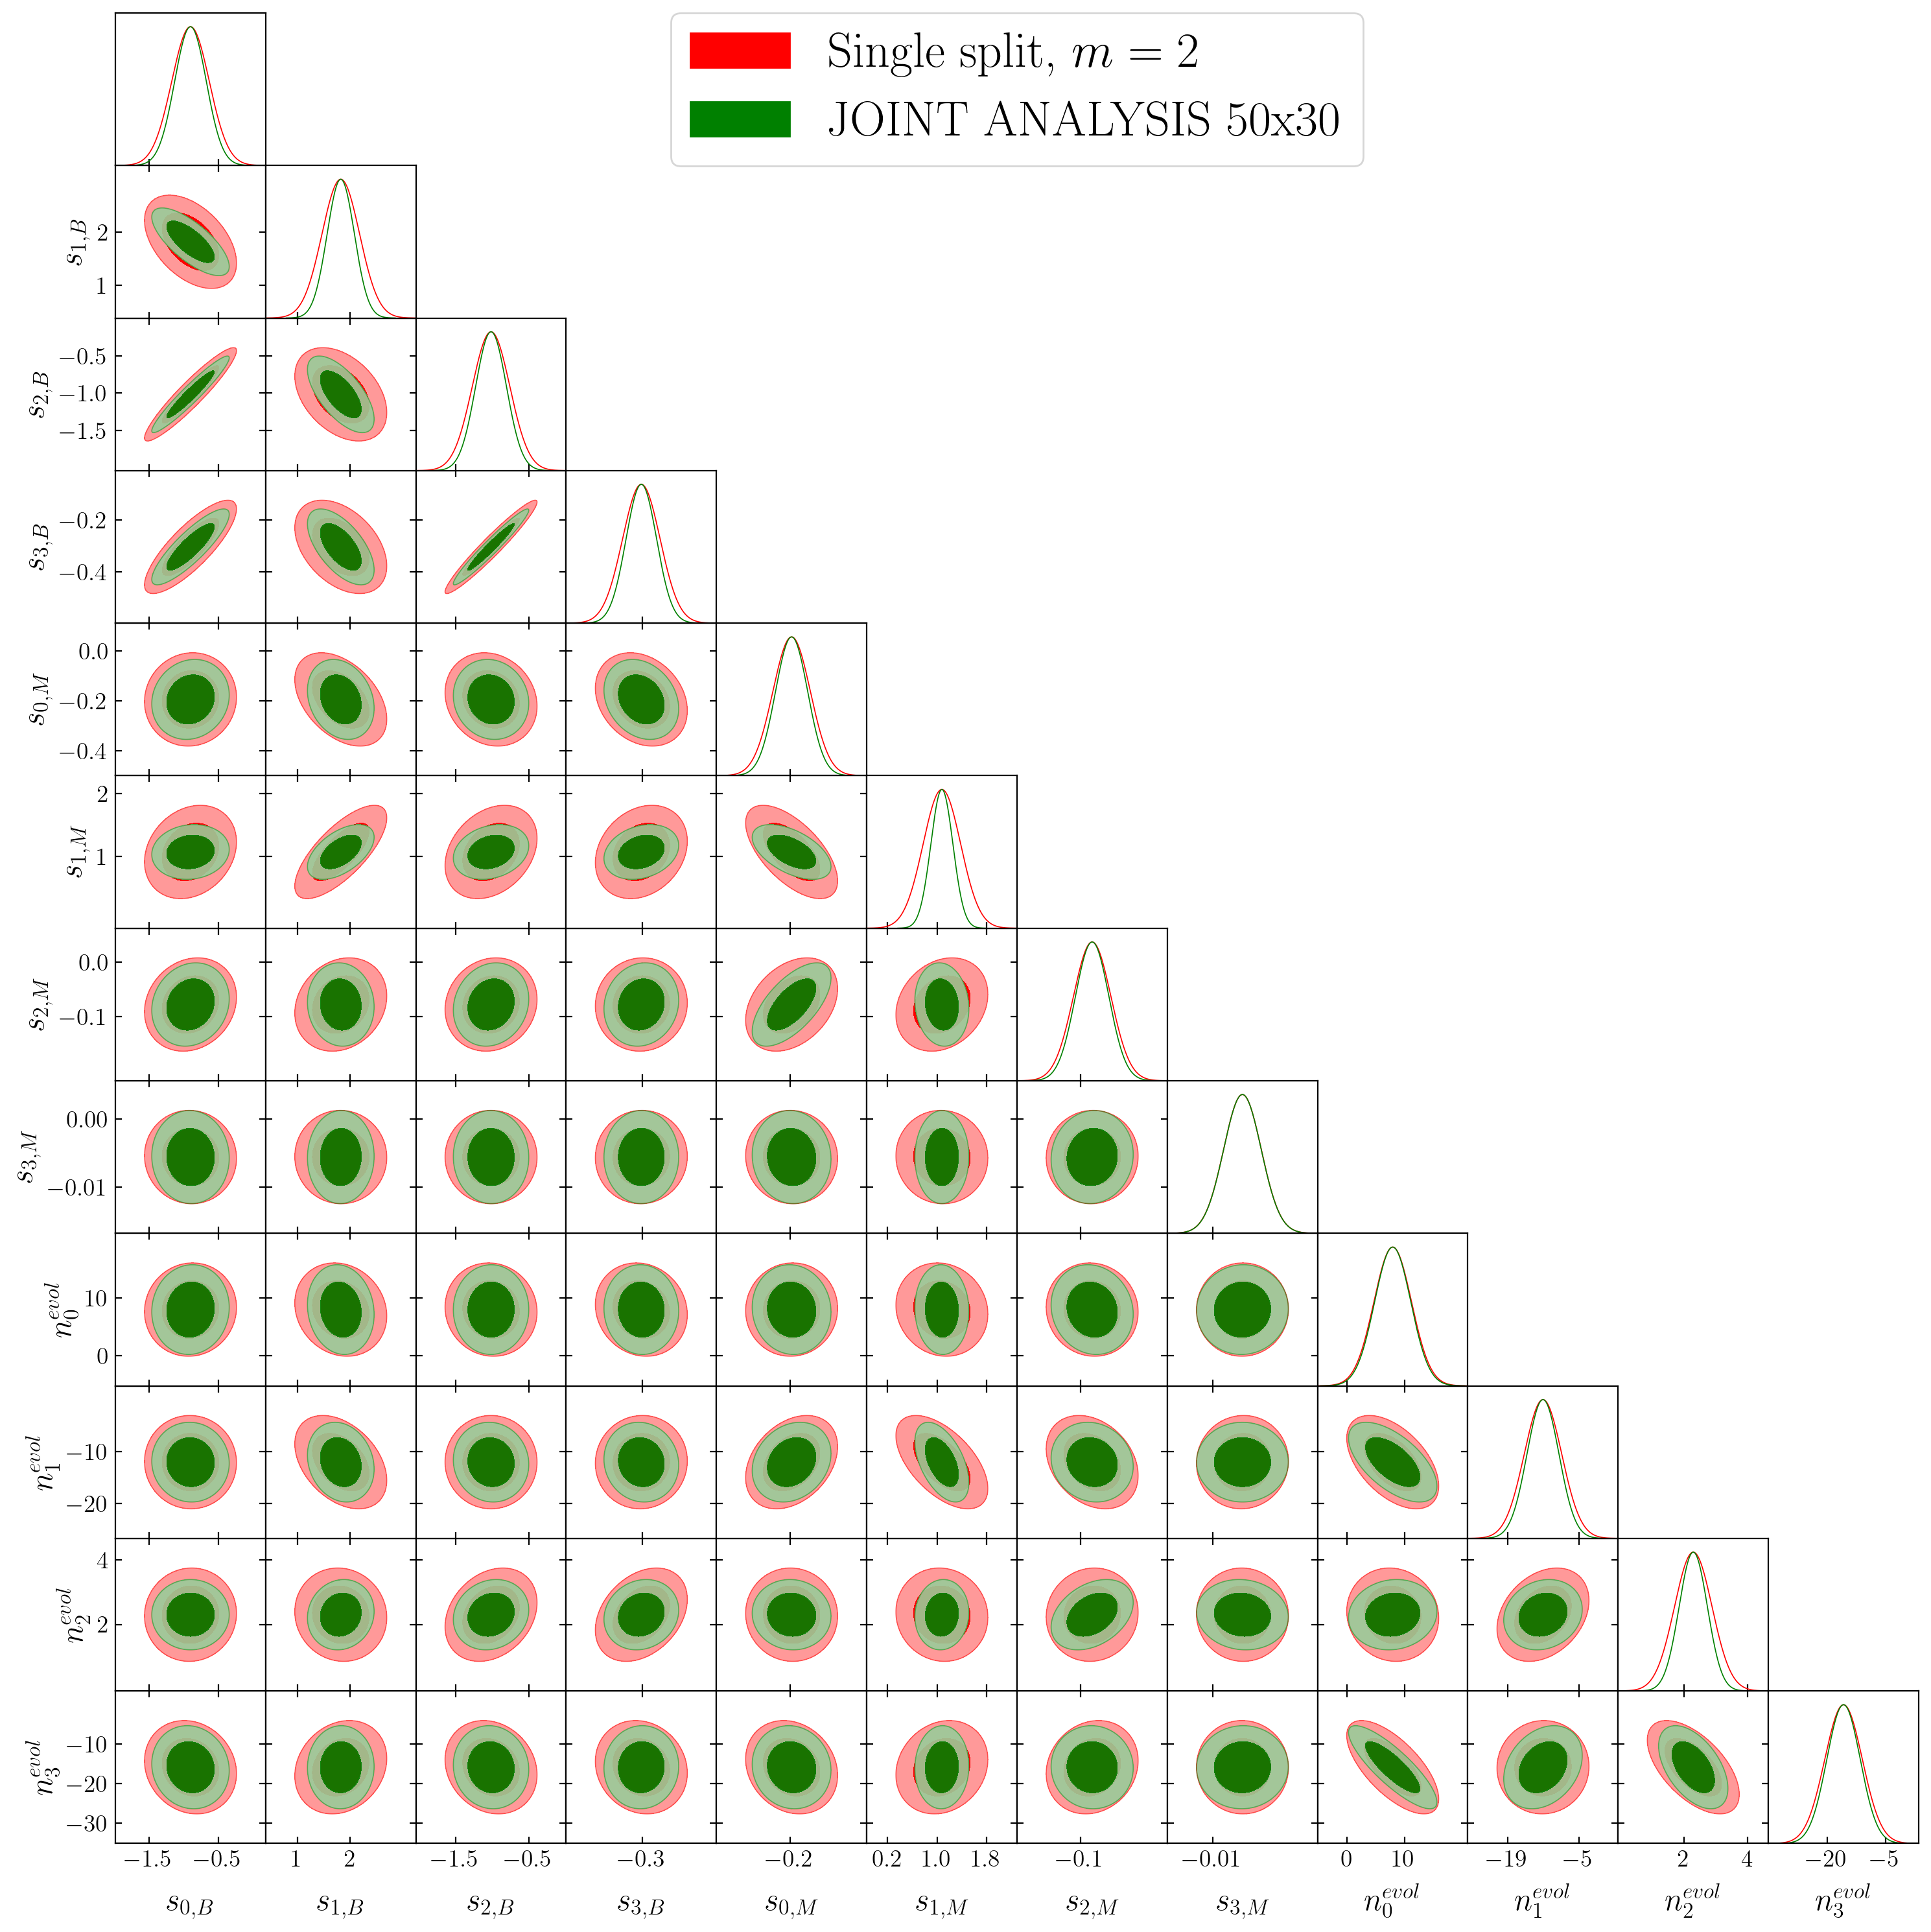

In [83]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x70_[:-13,:-13], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [84]:
np.shape(params_fid), np.shape(params_fid_30)

((29,), (21,))

In [85]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x70_ = Sigma_Matrix_Joint50x70

Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=0)
Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x70_)

(25, 25)

In [86]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

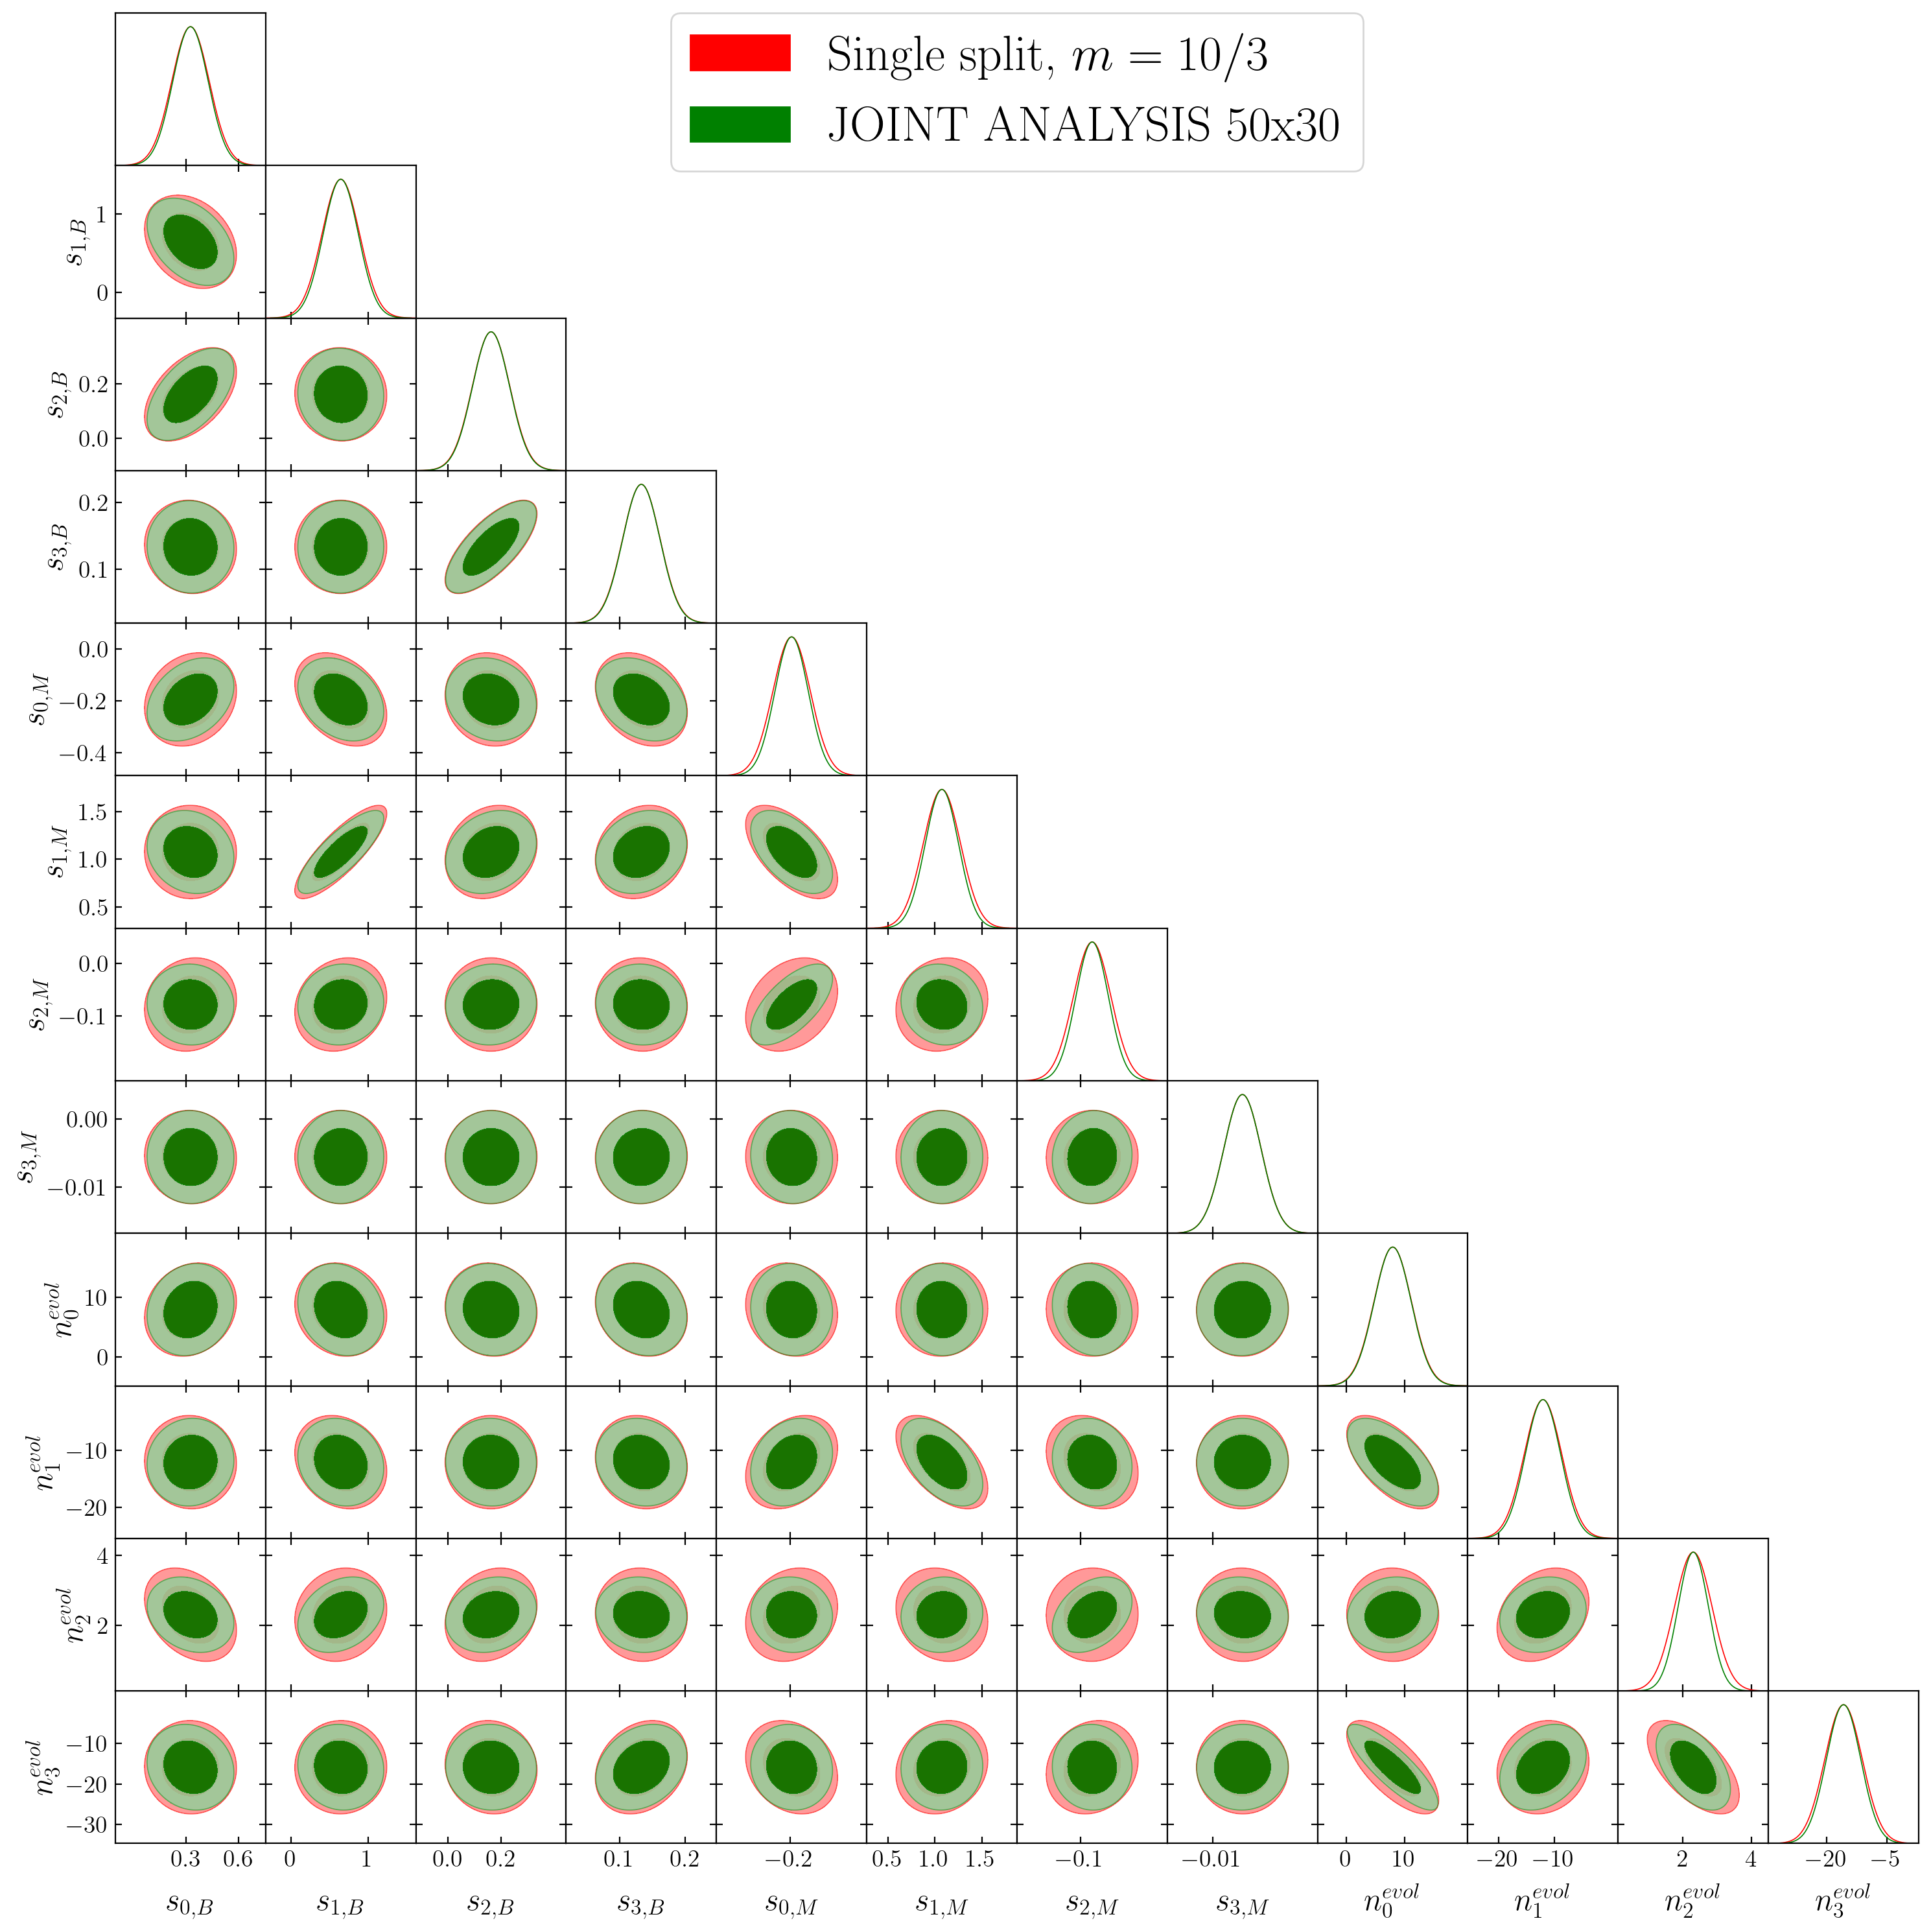

In [87]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x70_[:-13,:-13], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [88]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(20,24))

Sigma_Matrix_Joint50x70_ = Sigma_Matrix_Joint50x70

Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=0)
Sigma_Matrix_Joint50x70_ = np.delete(arr=Sigma_Matrix_Joint50x70_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x70_)

(9, 9)

In [89]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(9,)

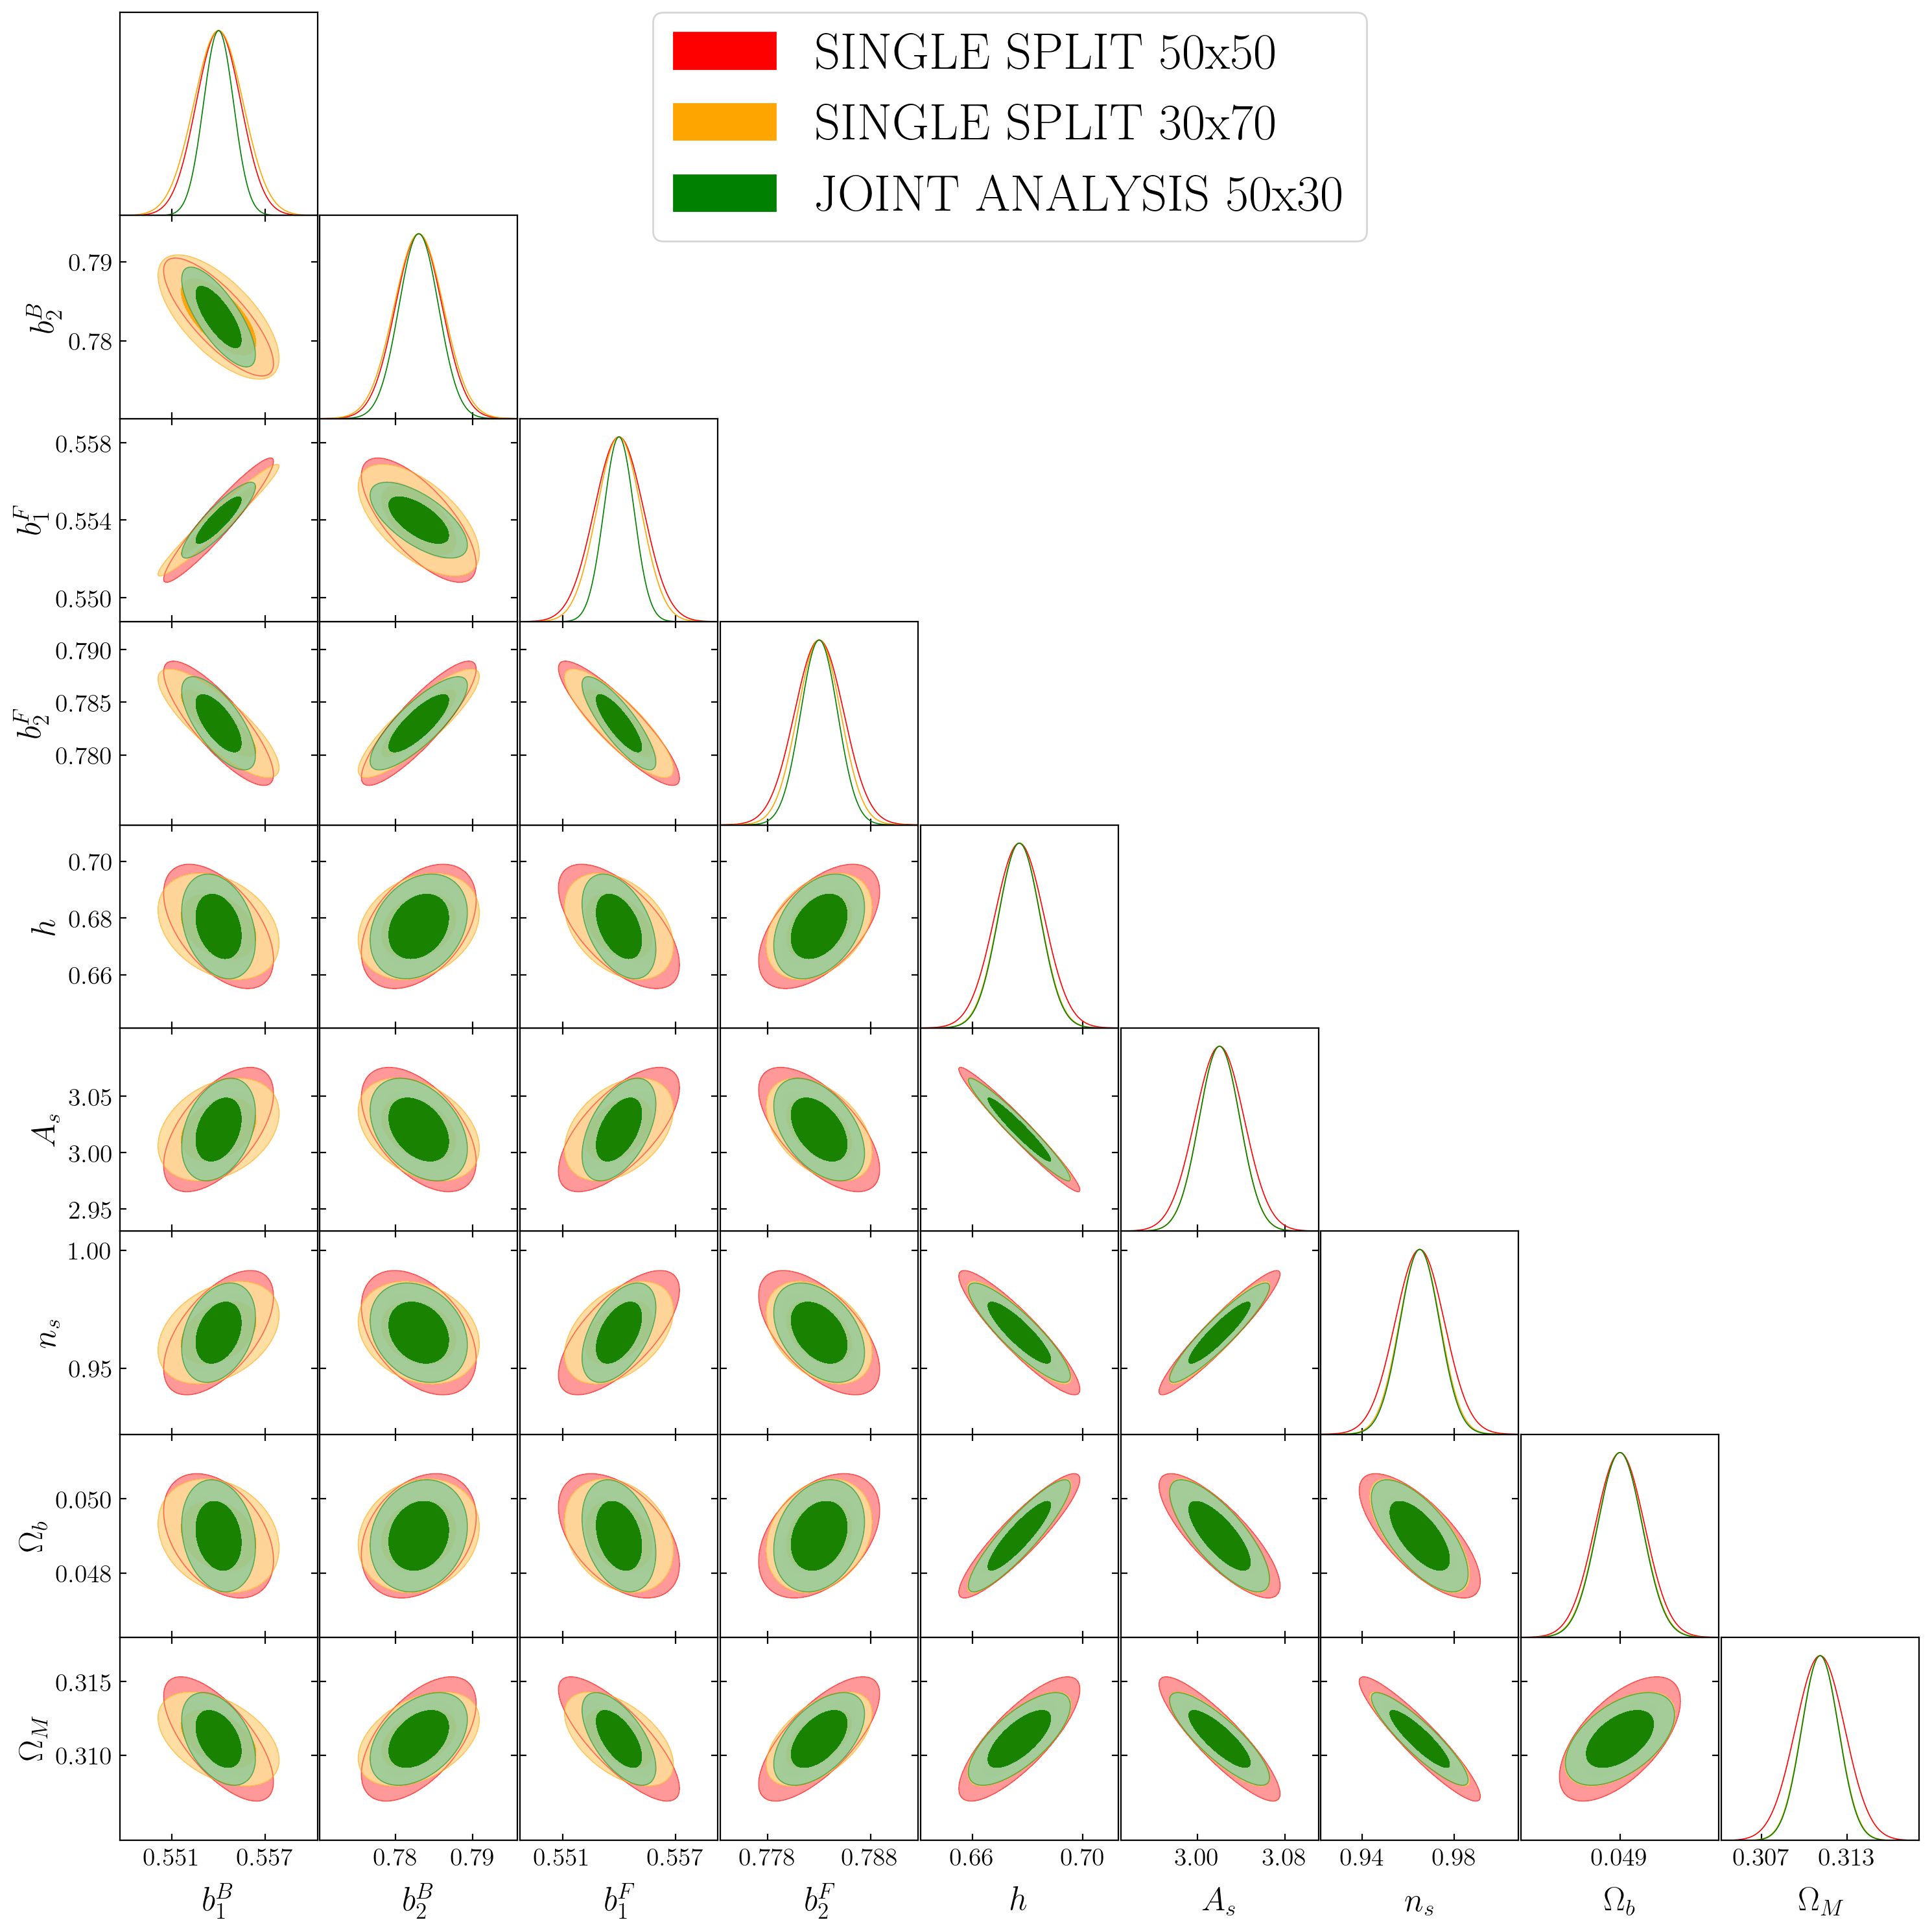

In [90]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}', r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x70_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# Predictions from the JOINT ANALYSIS

## Magnification bias

In [91]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

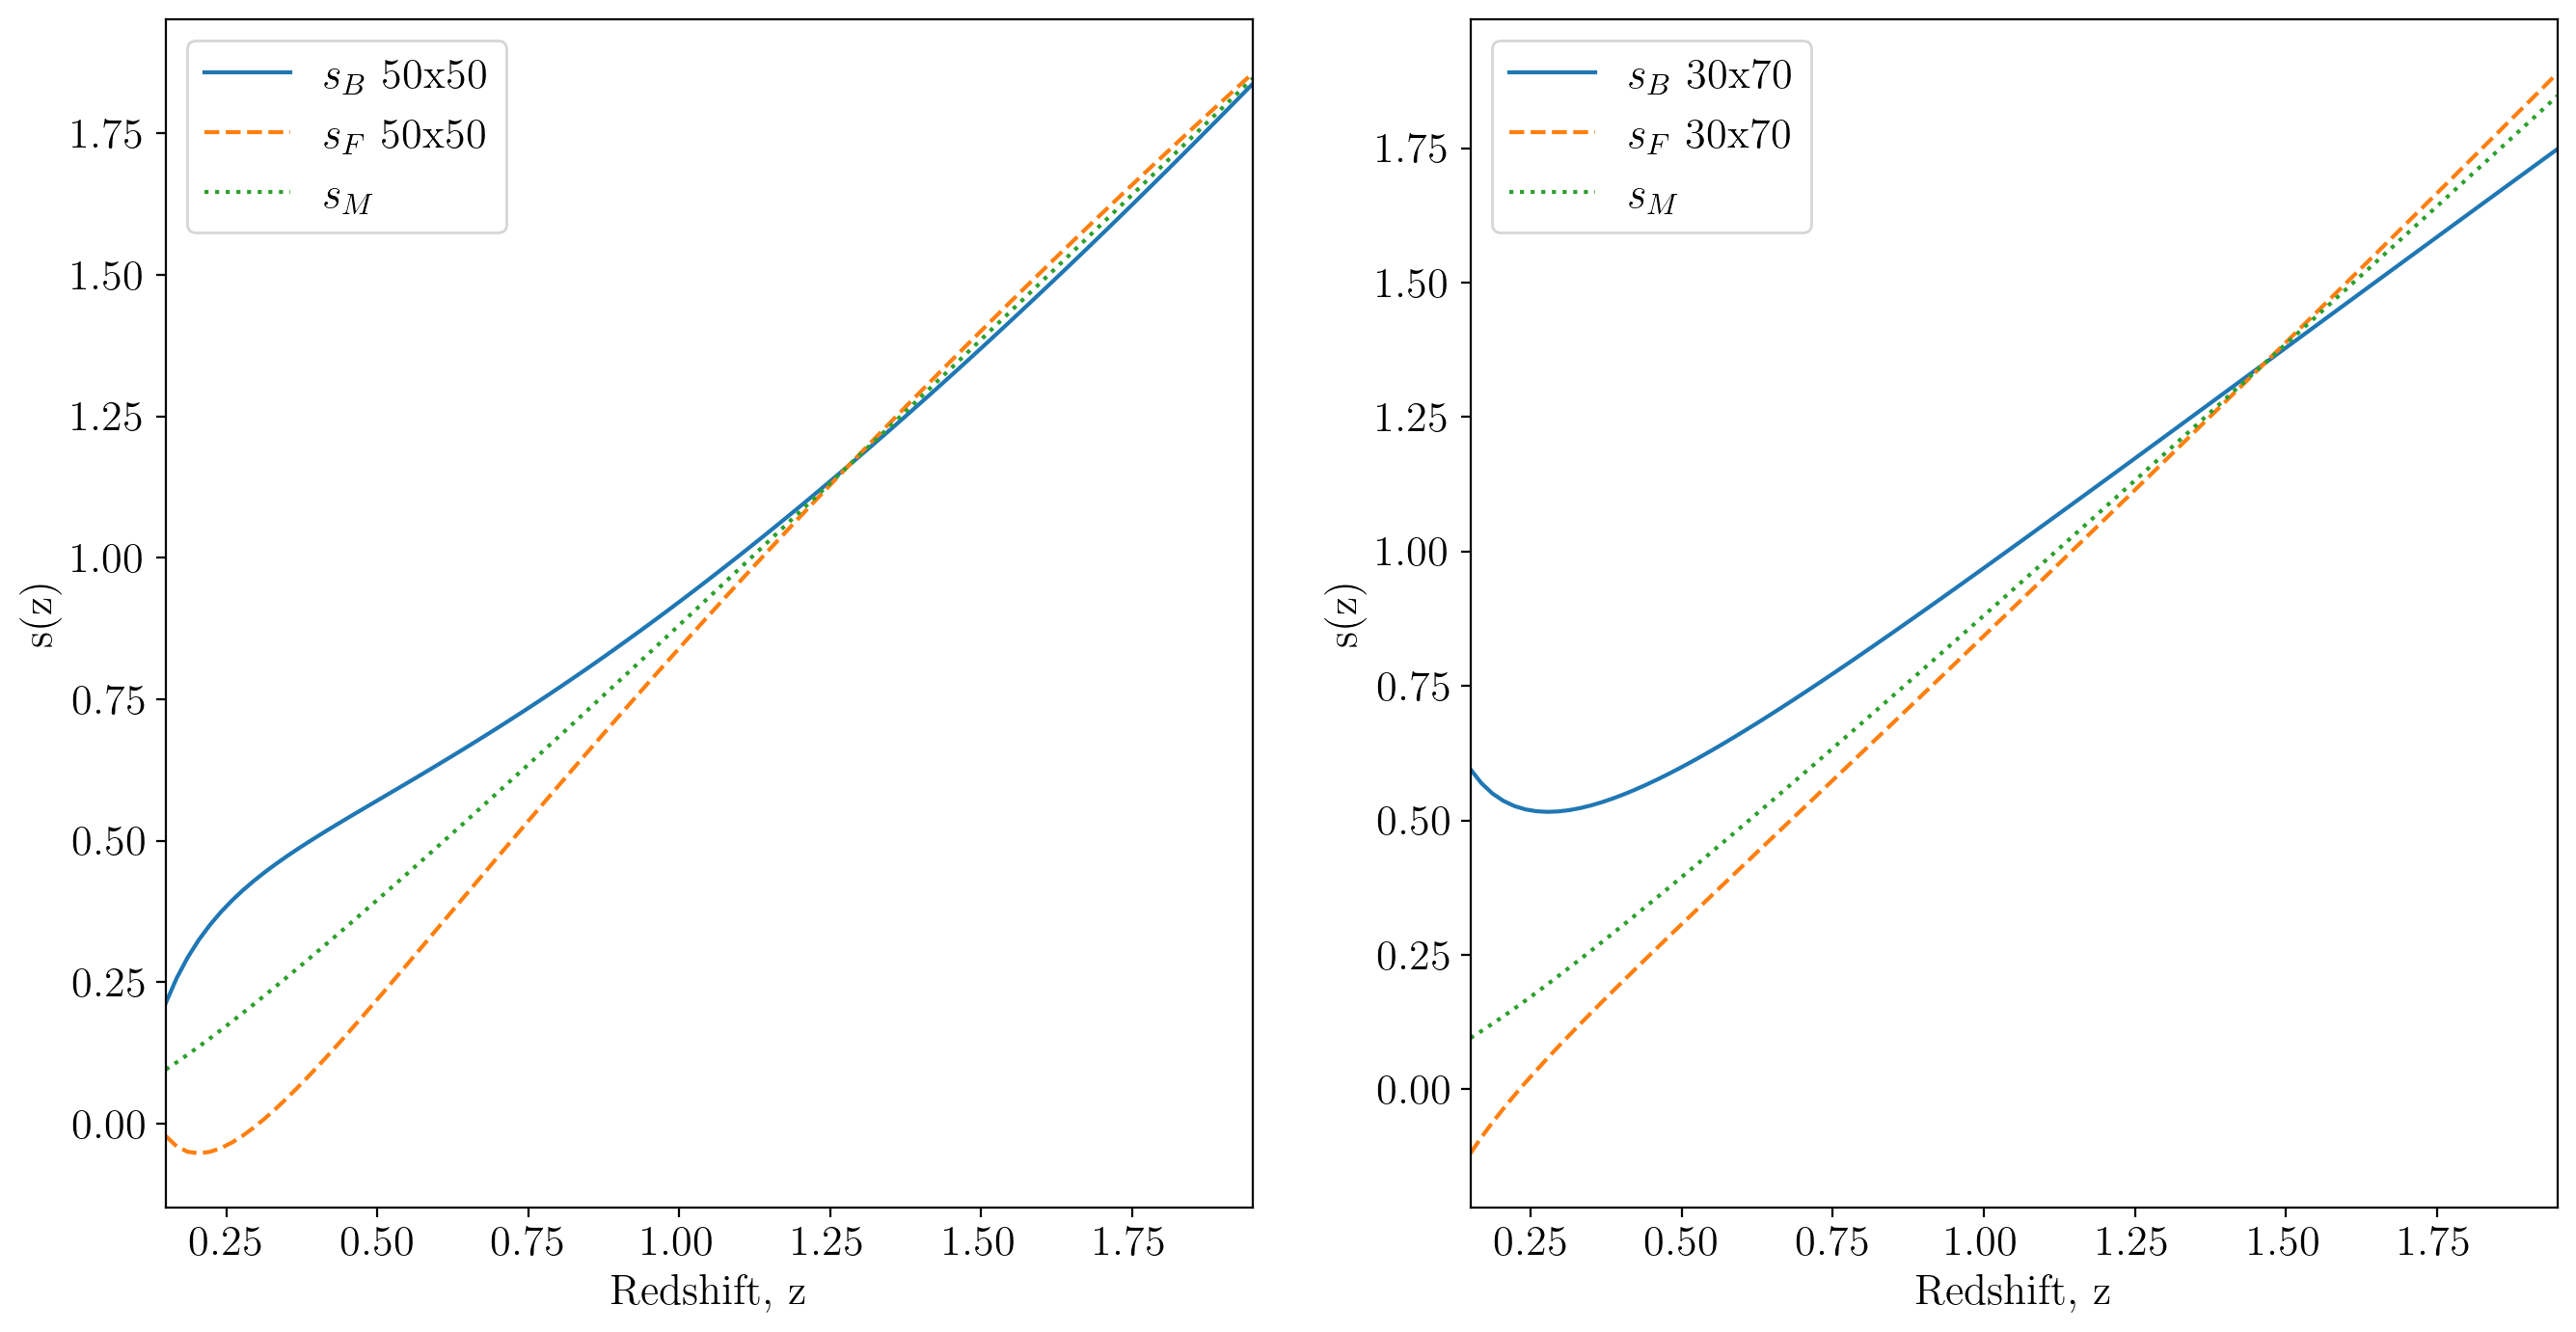

In [92]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [93]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit70, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


###### Compare the two observables

In [94]:
Sigma_Matrix_Joint50x70[:4, :4]

array([[ 0.05174161, -0.04325228,  0.04543529,  0.01159867],
       [-0.04325228,  0.06747509, -0.03521506, -0.00938108],
       [ 0.04543529, -0.03521506,  0.04399574,  0.01206847],
       [ 0.01159867, -0.00938108,  0.01206847,  0.00354597]])

In [95]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_Joint_50 = Sigma_Matrix_Joint50x70[:4, :4]
cov_sB_Joint_30 = Sigma_Matrix_Joint50x70[4:8, 4:8]
cov_sM_Joint = Sigma_Matrix_Joint50x70[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_Joint_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_Joint_50, num_samples)
sB_Joint_30_pars_samples = np.random.multivariate_normal(sB_4fit70, cov_sB_Joint_30, num_samples)
sM_Joint_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_Joint, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_50_pars_samples])
sB_Joint_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_30_pars_samples])
sM_Joint_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_Joint_pars_samples])

# Calculate the 68% confidence interval
sB_Joint_50_lower_bound = np.percentile(sB_Joint_50_samples, 16, axis=0)
sB_Joint_50_upper_bound = np.percentile(sB_Joint_50_samples, 84, axis=0)

sB_Joint_30_lower_bound = np.percentile(sB_Joint_30_samples, 16, axis=0)
sB_Joint_30_upper_bound = np.percentile(sB_Joint_30_samples, 84, axis=0)

sM_Joint_lower_bound = np.percentile(sM_Joint_samples, 16, axis=0)
sM_Joint_upper_bound = np.percentile(sM_Joint_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

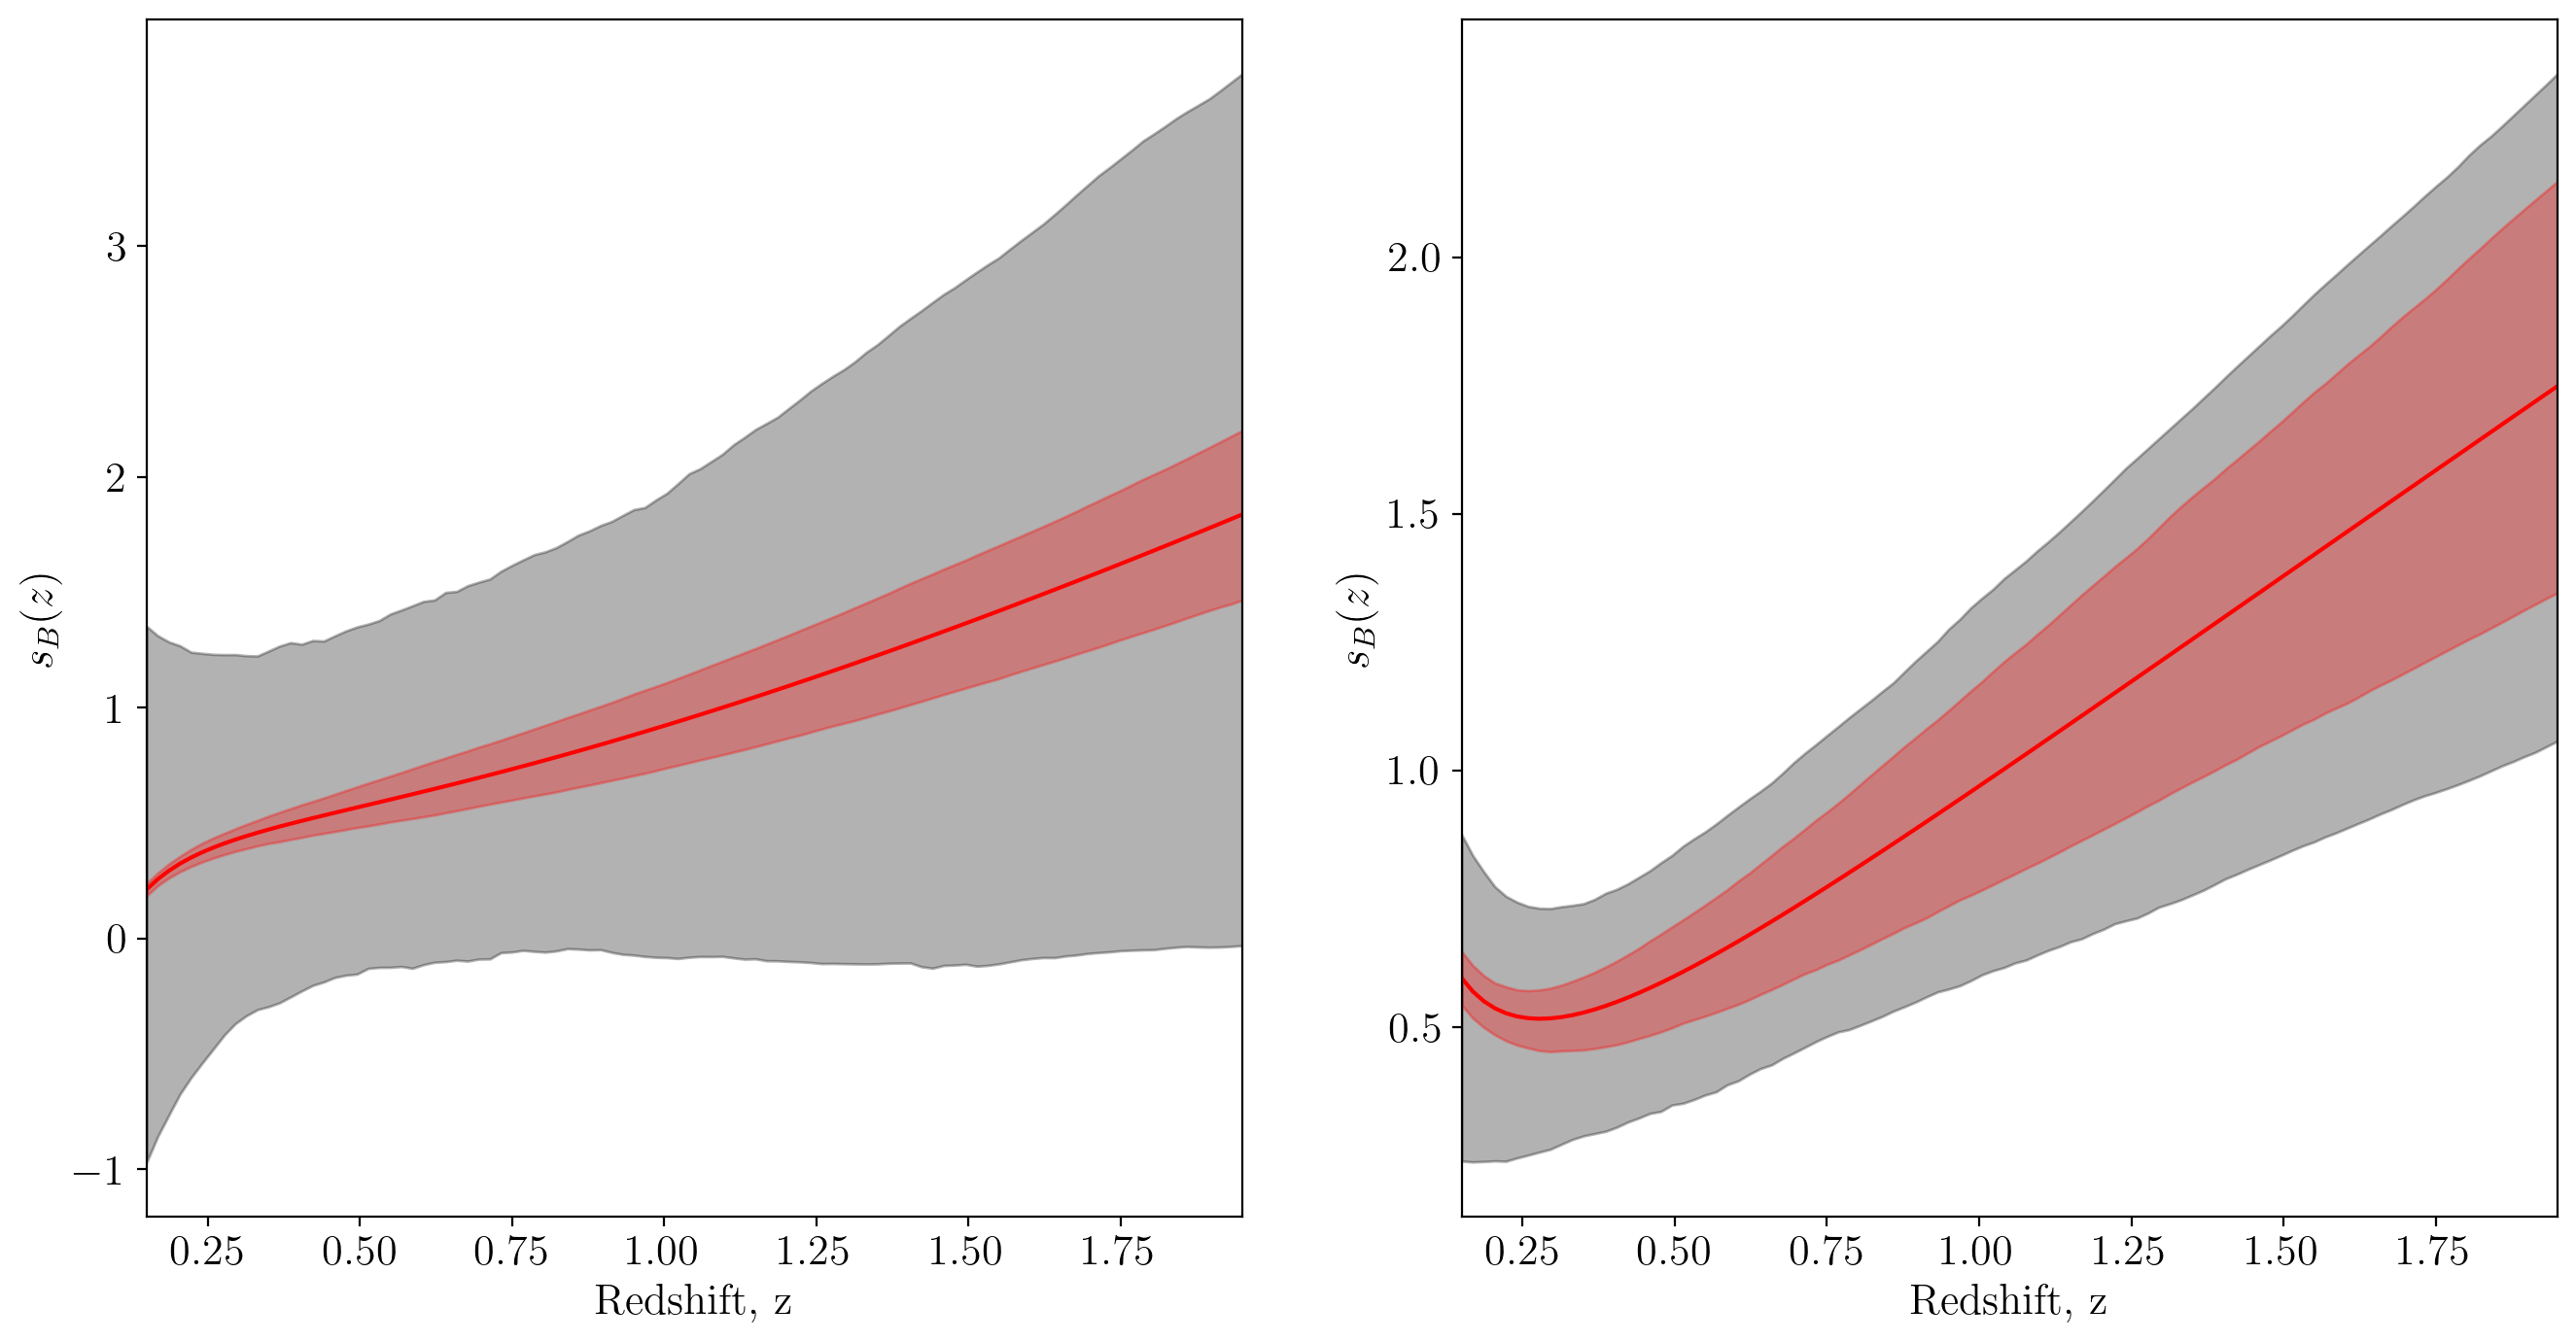

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3)
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3)

ax[1].plot(z_lin, sB_fid_30, 'r-')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

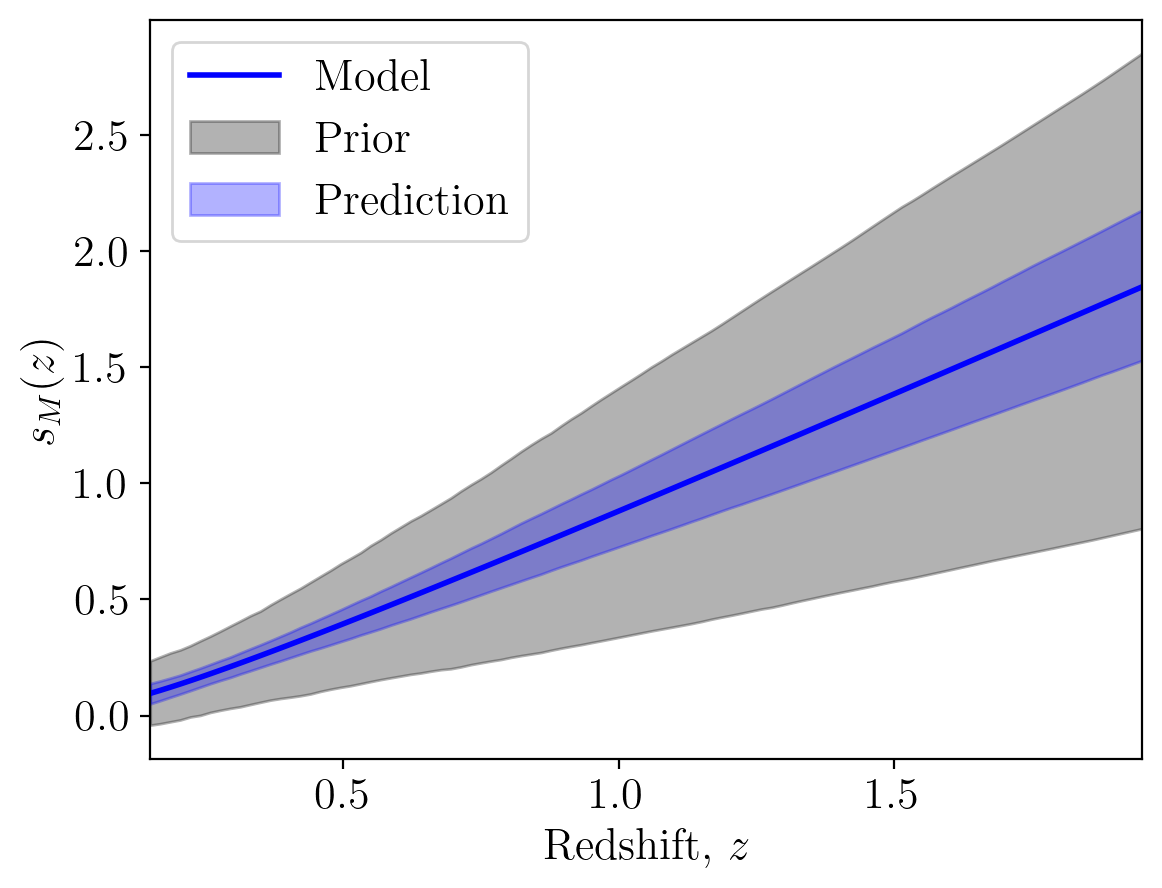

In [97]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
plt.fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.legend(loc='upper left');

### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [98]:
sbias_fid = np.concatenate([sB_4fit50, sB_4fit70, sM_4fit])

np.shape(sbias_fid)

(12,)

In [99]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias = Sigma_Matrix_Joint50x70[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_Joint_pars_samples = np.random.multivariate_normal(sbias_fid, cov_sbias, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_Joint_pars_samples])
sB_Joint_30_samples_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_Joint_pars_samples])
sM_Joint_samples_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_Joint_pars_samples])

# Compute the sF for each sample
sF_50_samples_ = sM_Joint_samples_*m_50/(m_50-1) - sB_Joint_50_samples_/(m_50-1)
sF_30_samples_ = sM_Joint_samples_*m_30/(m_30-1) - sB_Joint_30_samples_/(m_30-1)


# Calculate the 68% confidence interval
sF_50_Joint_lower_bound_ = np.percentile(sF_50_samples_, 16, axis=0)
sF_50_Joint_upper_bound_ = np.percentile(sF_50_samples_, 84, axis=0)

sF_30_Joint_lower_bound_ = np.percentile(sF_30_samples_, 16, axis=0)
sF_30_Joint_upper_bound_ = np.percentile(sF_30_samples_, 84, axis=0)

Compare with priors

In [100]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors_ = Cov_prior_all[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_pars_samples_priors_ = np.random.multivariate_normal(sbias_fid, cov_sbias_priors_, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples_priors_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors_])
sB_30_samples_priors_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors_])
sM_samples_priors_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_pars_samples_priors_])

# Compute the sF for each sample
sF_50_samples_priors_ = sM_samples_priors_*m_50/(m_50-1) - sB_50_samples_priors_/(m_50-1)
sF_30_samples_priors_ = sM_samples_priors_*m_30/(m_30-1) - sB_30_samples_priors_/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors_ = np.percentile(sF_50_samples_priors_, 16, axis=0)
sF_50_upper_bound_priors_ = np.percentile(sF_50_samples_priors_, 84, axis=0)

sF_30_lower_bound_priors_ = np.percentile(sF_30_samples_priors_, 16, axis=0)
sF_30_upper_bound_priors_ = np.percentile(sF_30_samples_priors_, 84, axis=0)

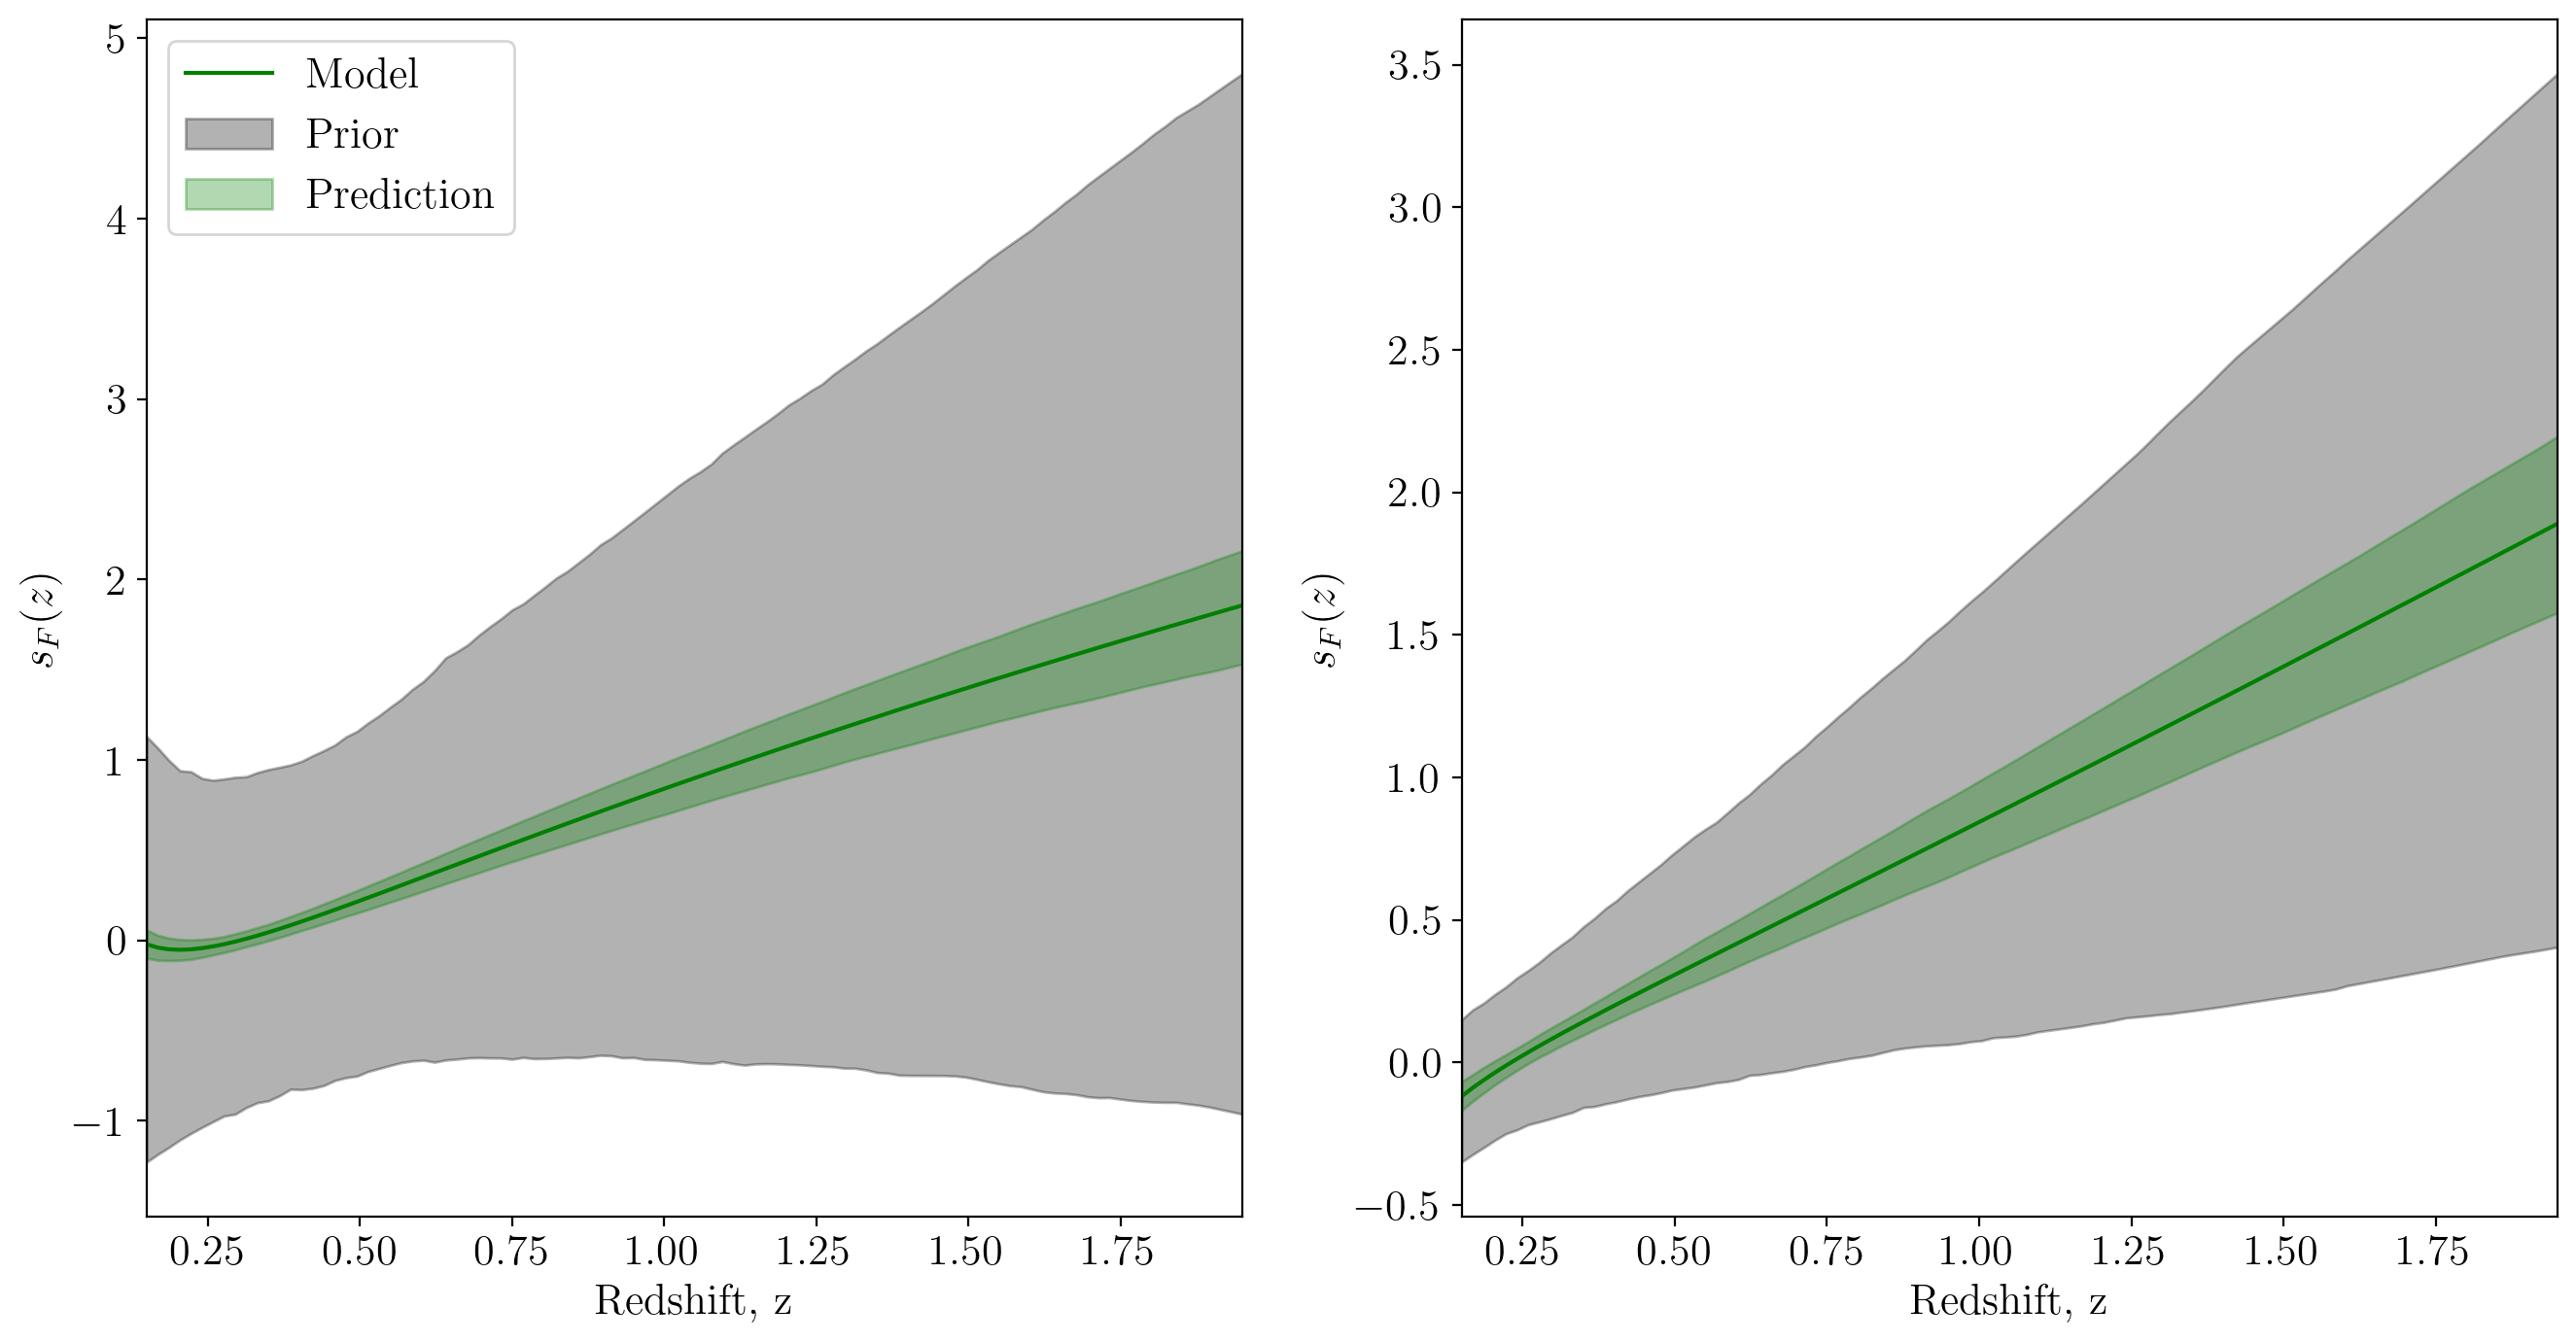

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'green', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'green')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3)

ax[0].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')

## Number evolution

In [102]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

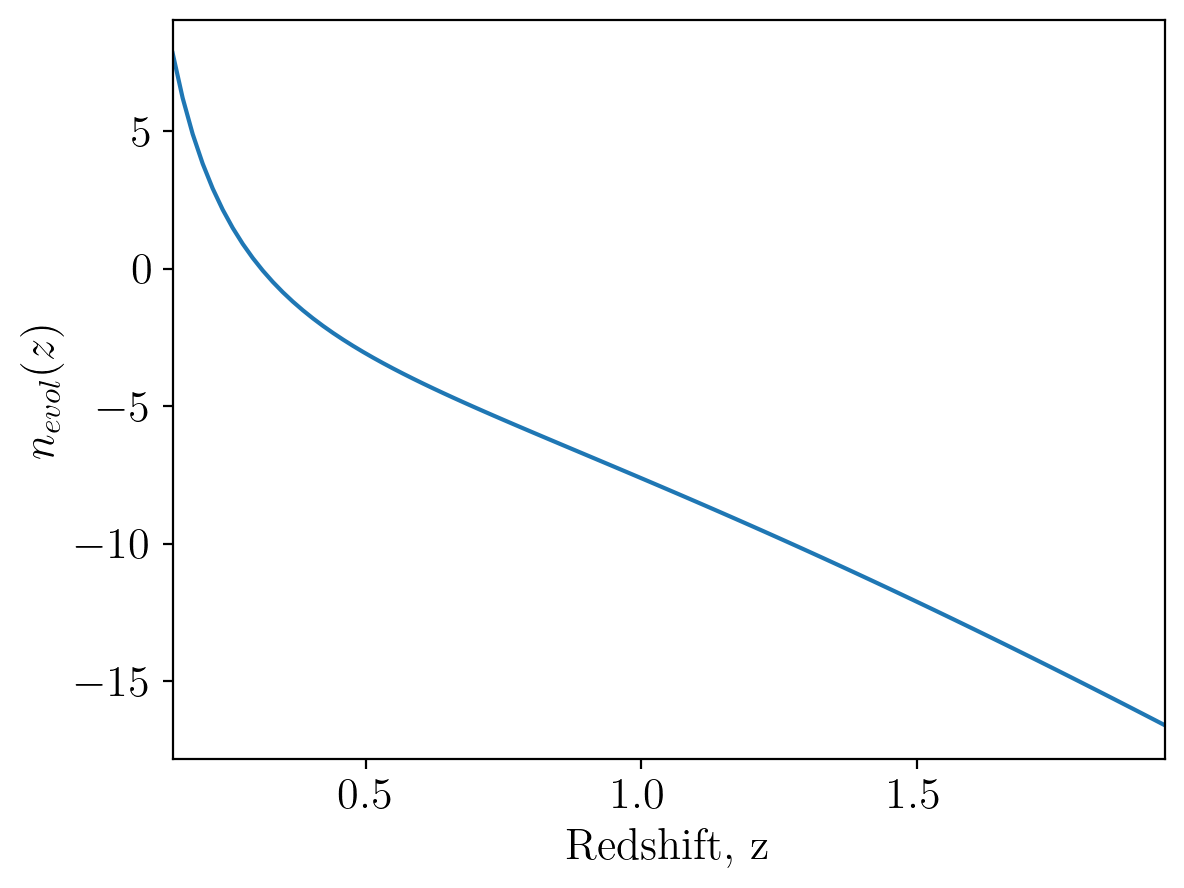

In [103]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [104]:
# Select the marginalized covariance matrix for the number evolution
cov_Joint_numevol = Sigma_Matrix_Joint50x70[12:16, 12:16]
cov_numevol_priors = Cov_prior_all[12:16, 12:16]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_Joint_pars_samples = np.random.multivariate_normal(num_fit, cov_Joint_numevol, num_samples)
nevol_samples_priors = np.random.multivariate_normal(num_fit, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_Joint_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_Joint_pars_samples])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_Joint_lower_bound = np.percentile(nevol_Joint_samples, 16, axis=0)
nevol_Joint_upper_bound = np.percentile(nevol_Joint_samples, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

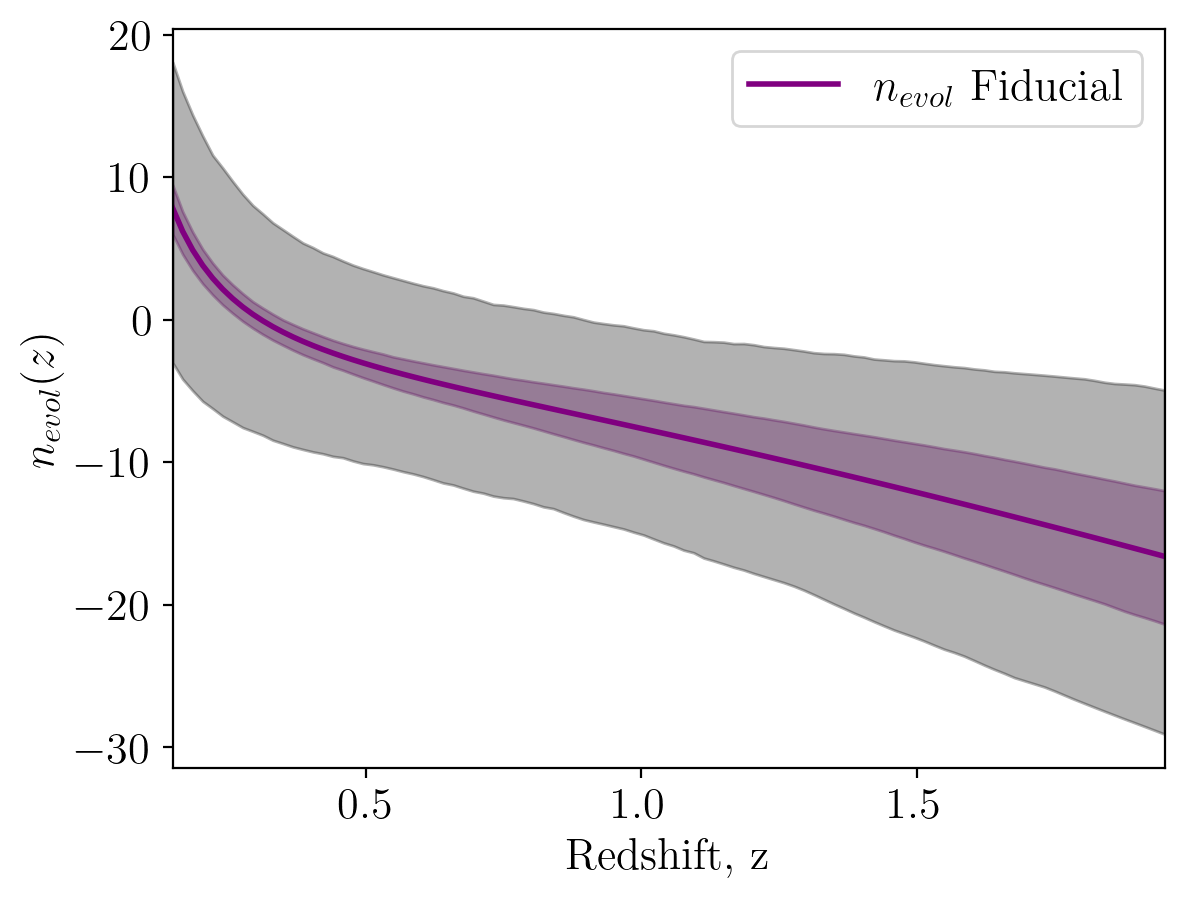

In [105]:
plt.plot(z_lin, num_evol_fid, '-', color='purple', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='purple', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [106]:
from biasmodels import EvolutionBias

In [107]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [108]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [109]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit70, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

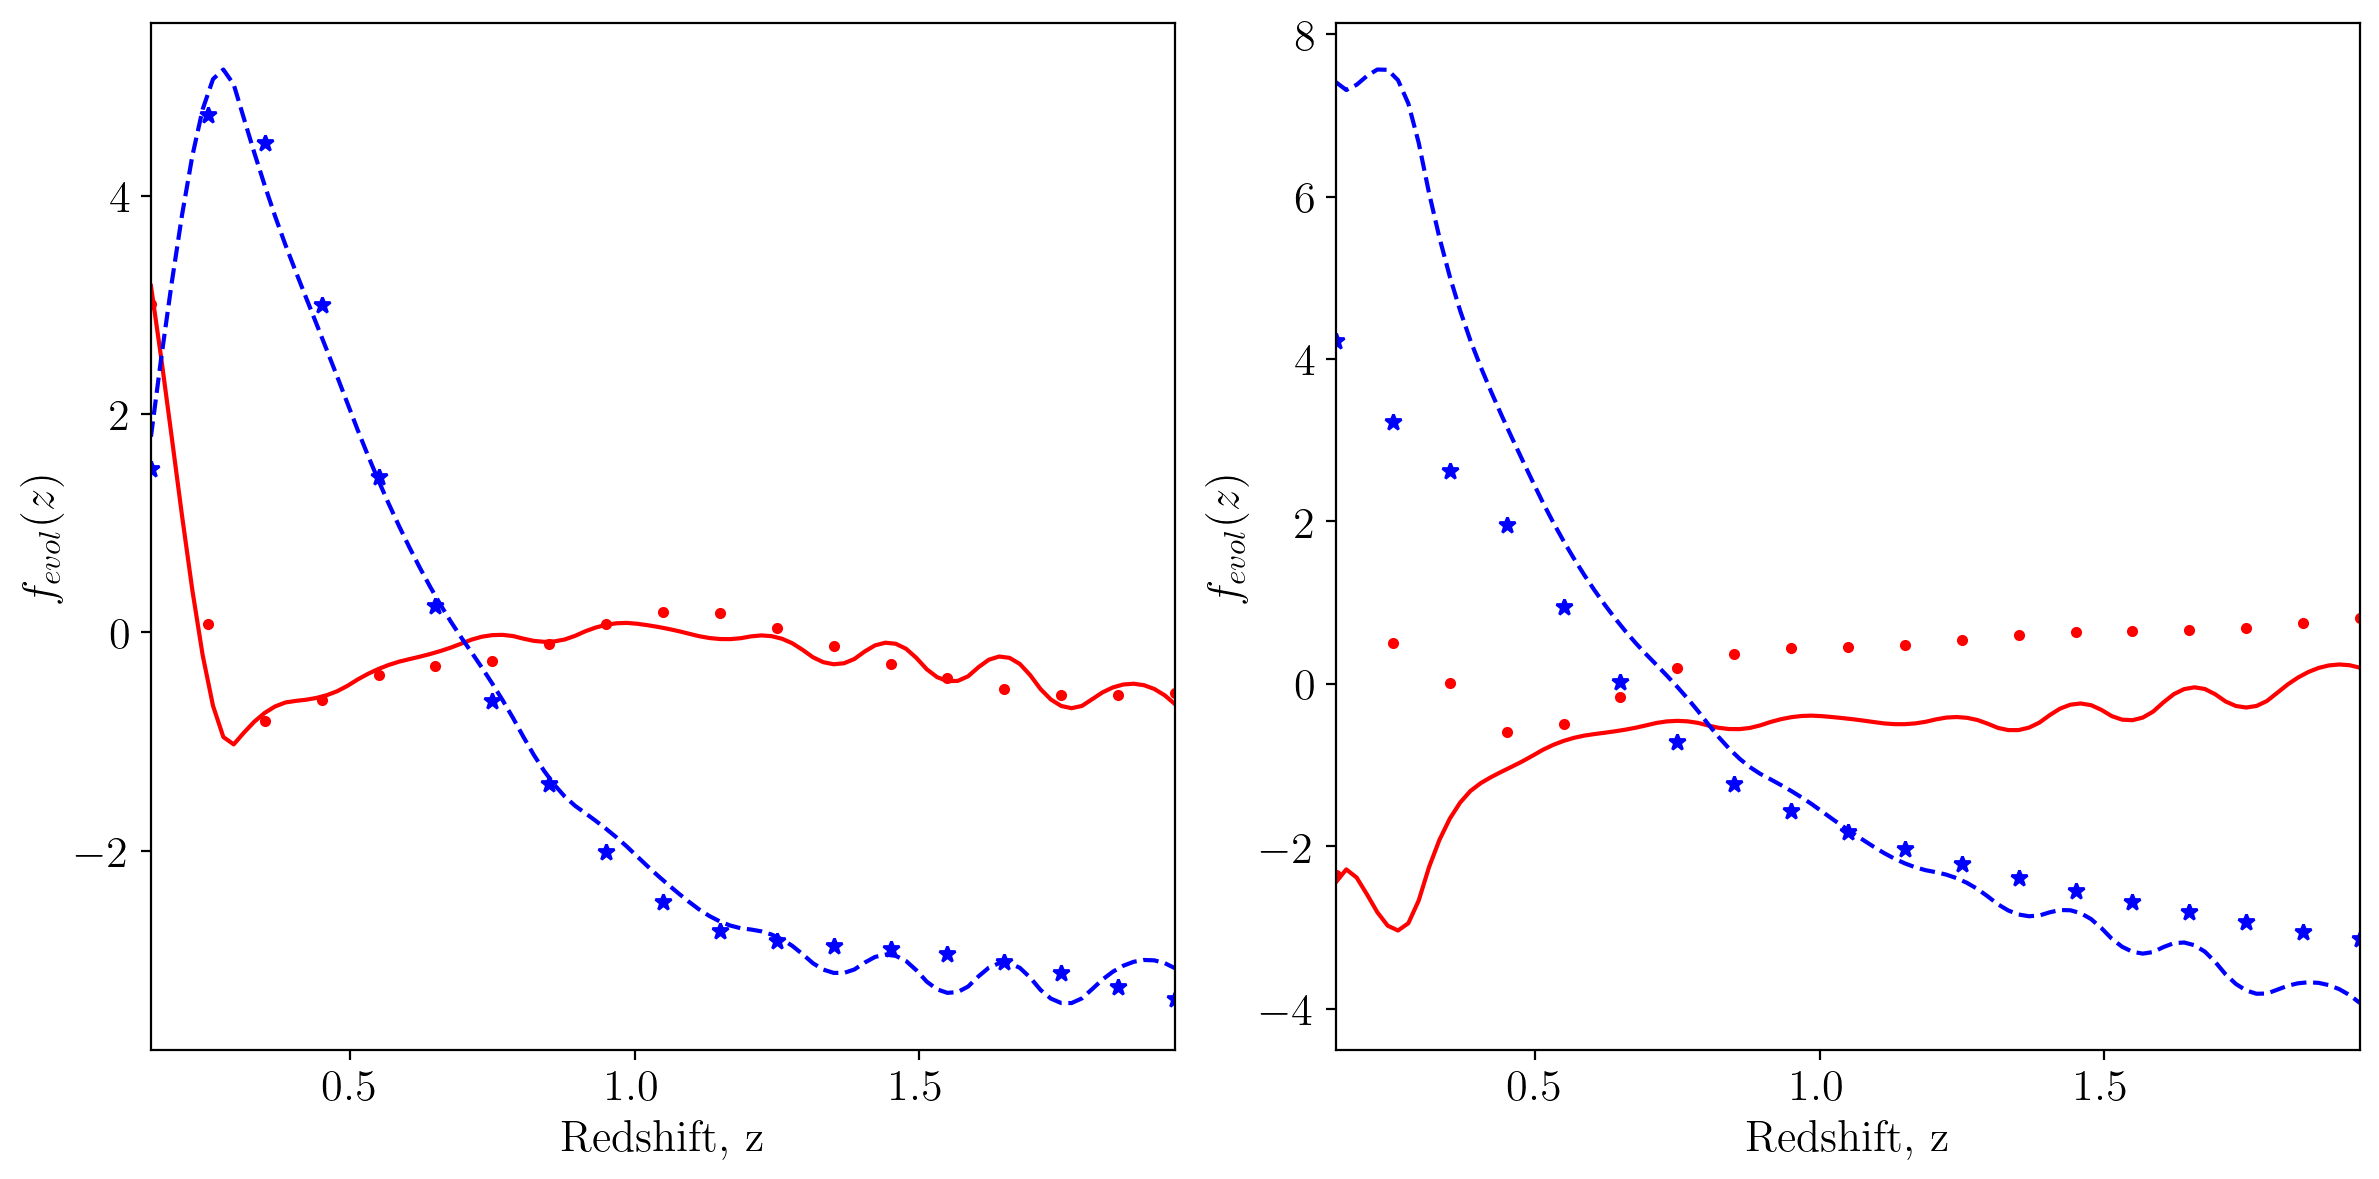

In [110]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [111]:
list(range(4,8))

[4, 5, 6, 7]

In [112]:
# Select the marginalized covariance matrix for the parameters

cov_Joint_all = Sigma_Matrix_Joint50x70[:16, :16]
cov_all_priors = Cov_prior_all[:16, :16]

all_fid = np.concatenate([sbias_fid, num_fit])

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_Joint_pars_samples = np.random.multivariate_normal(all_fid, cov_Joint_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

nind_50 = list(range(4,8))

all_Joint_50_pars_samples = all_Joint_pars_samples
all_Joint_50_pars_samples = np.delete(all_Joint_50_pars_samples, nind_50, axis=1)
all_50_pars_samples_priors = all_pars_samples_priors
all_50_pars_samples_priors = np.delete(all_50_pars_samples_priors, nind_50, axis=1)

nind_30 = list(range(0,4))

all_Joint_30_pars_samples = all_Joint_pars_samples
all_Joint_30_pars_samples = np.delete(all_Joint_30_pars_samples, nind_30, axis=1)
all_30_pars_samples_priors = all_pars_samples_priors
all_30_pars_samples_priors = np.delete(all_30_pars_samples_priors, nind_30, axis=1)

In [113]:
# Evaluate fitting function for each parameter sample

fevol_Joint_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])
fevol_Joint_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])

fevol_Joint_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])
fevol_Joint_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound = np.percentile(fevol_Joint_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound = np.percentile(fevol_Joint_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 16, axis=0)
fevol_B_50_upper_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 84, axis=0)

fevol_F_50_lower_bound = np.percentile(fevol_Joint_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound = np.percentile(fevol_Joint_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 16, axis=0)
fevol_F_50_upper_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 84, axis=0)

fevol_B_30_lower_bound = np.percentile(fevol_Joint_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound = np.percentile(fevol_Joint_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 16, axis=0)
fevol_B_30_upper_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 84, axis=0)

fevol_F_30_lower_bound = np.percentile(fevol_Joint_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound = np.percentile(fevol_Joint_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 16, axis=0)
fevol_F_30_upper_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 84, axis=0)

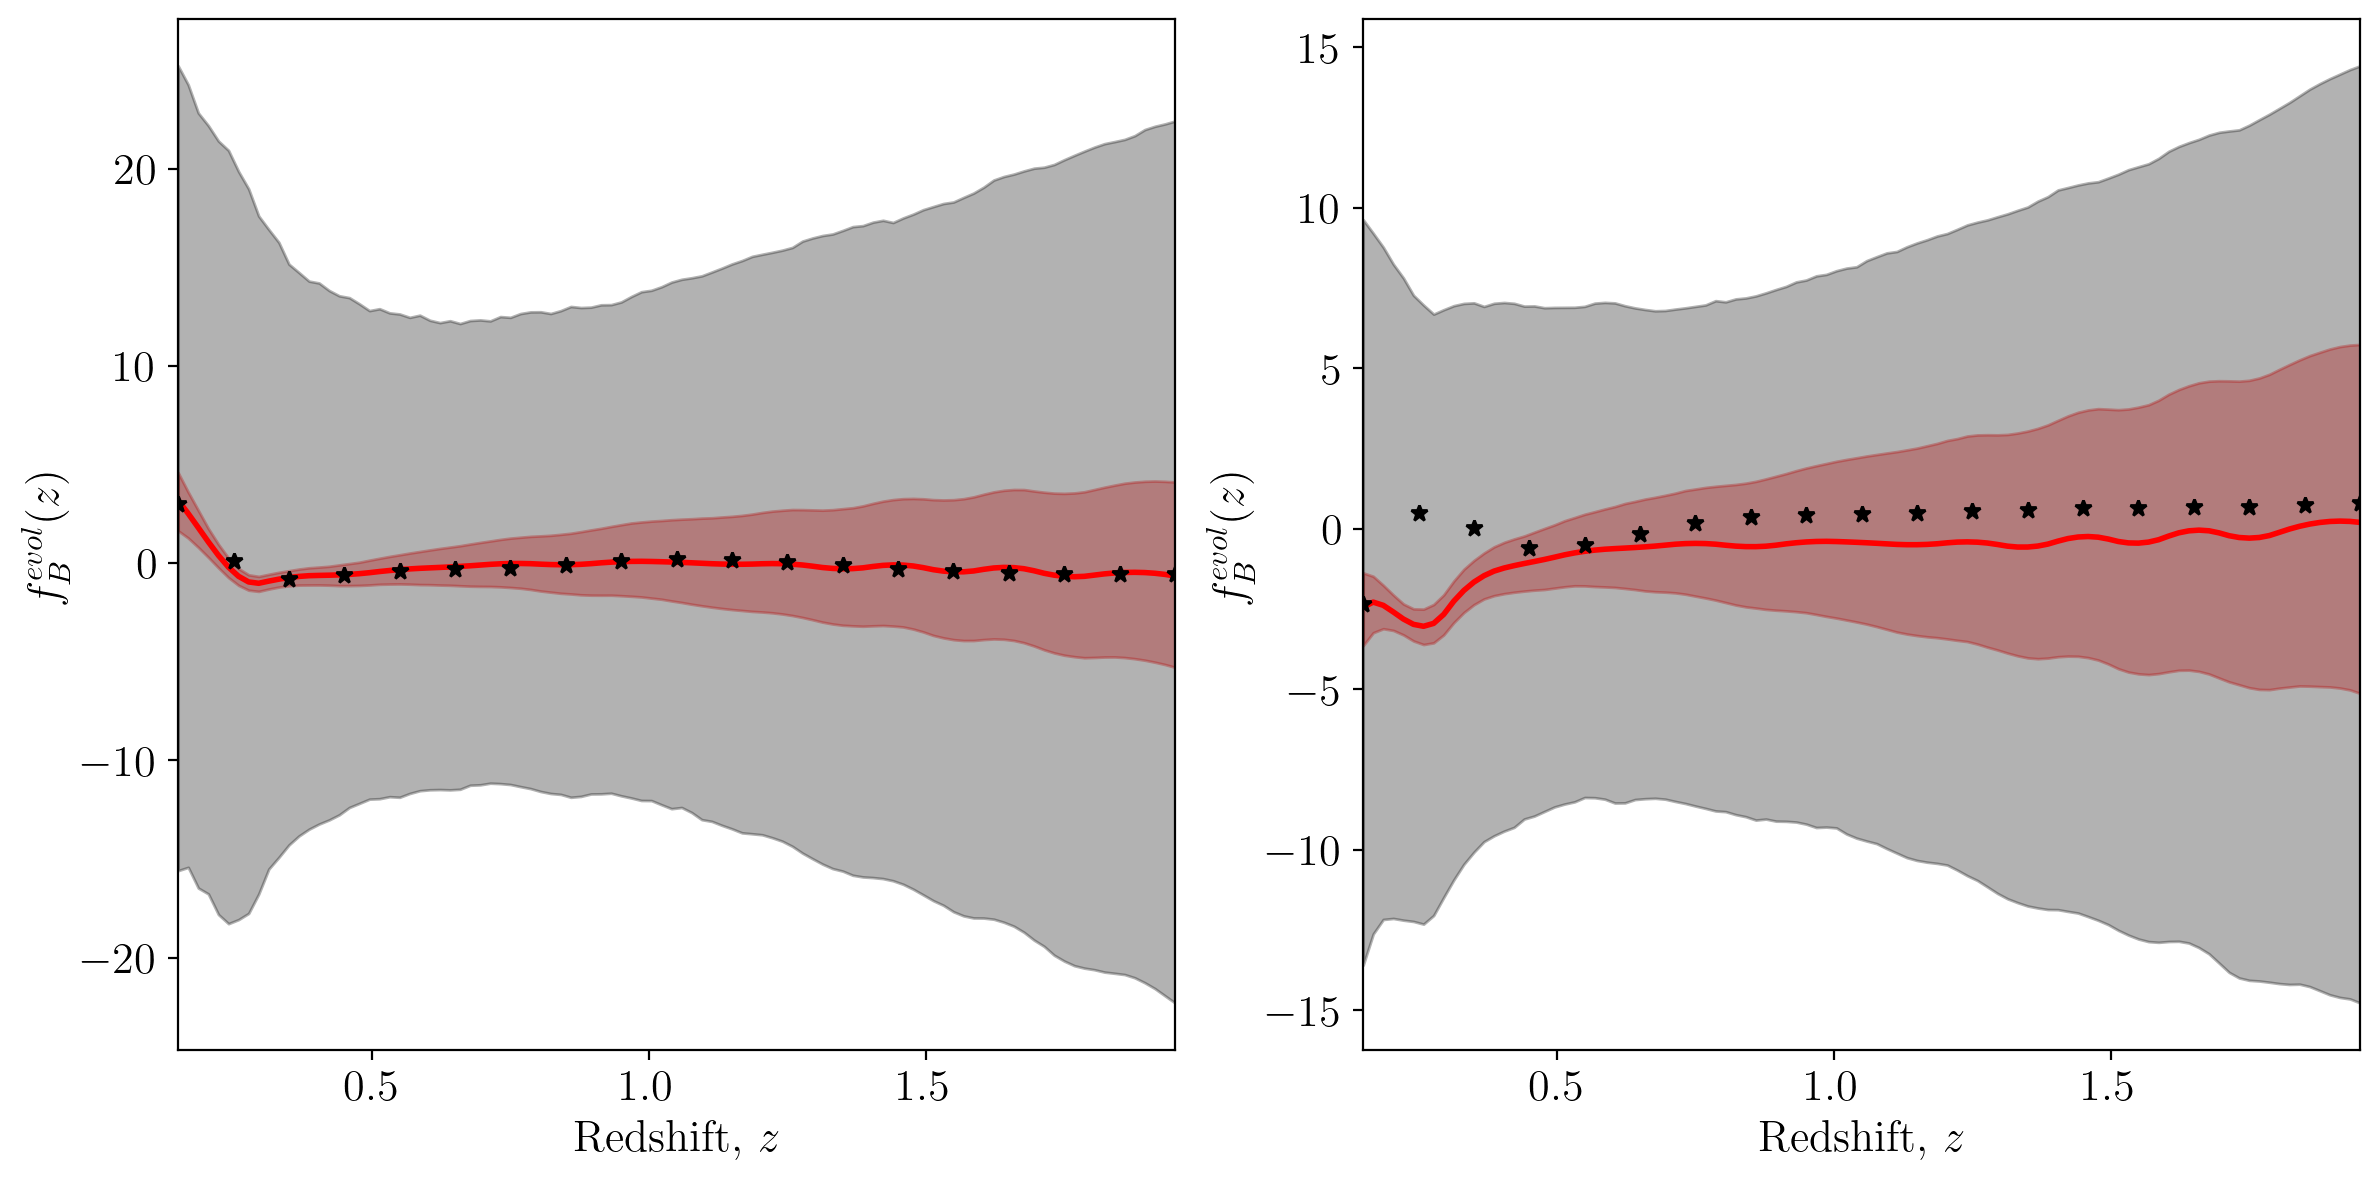

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

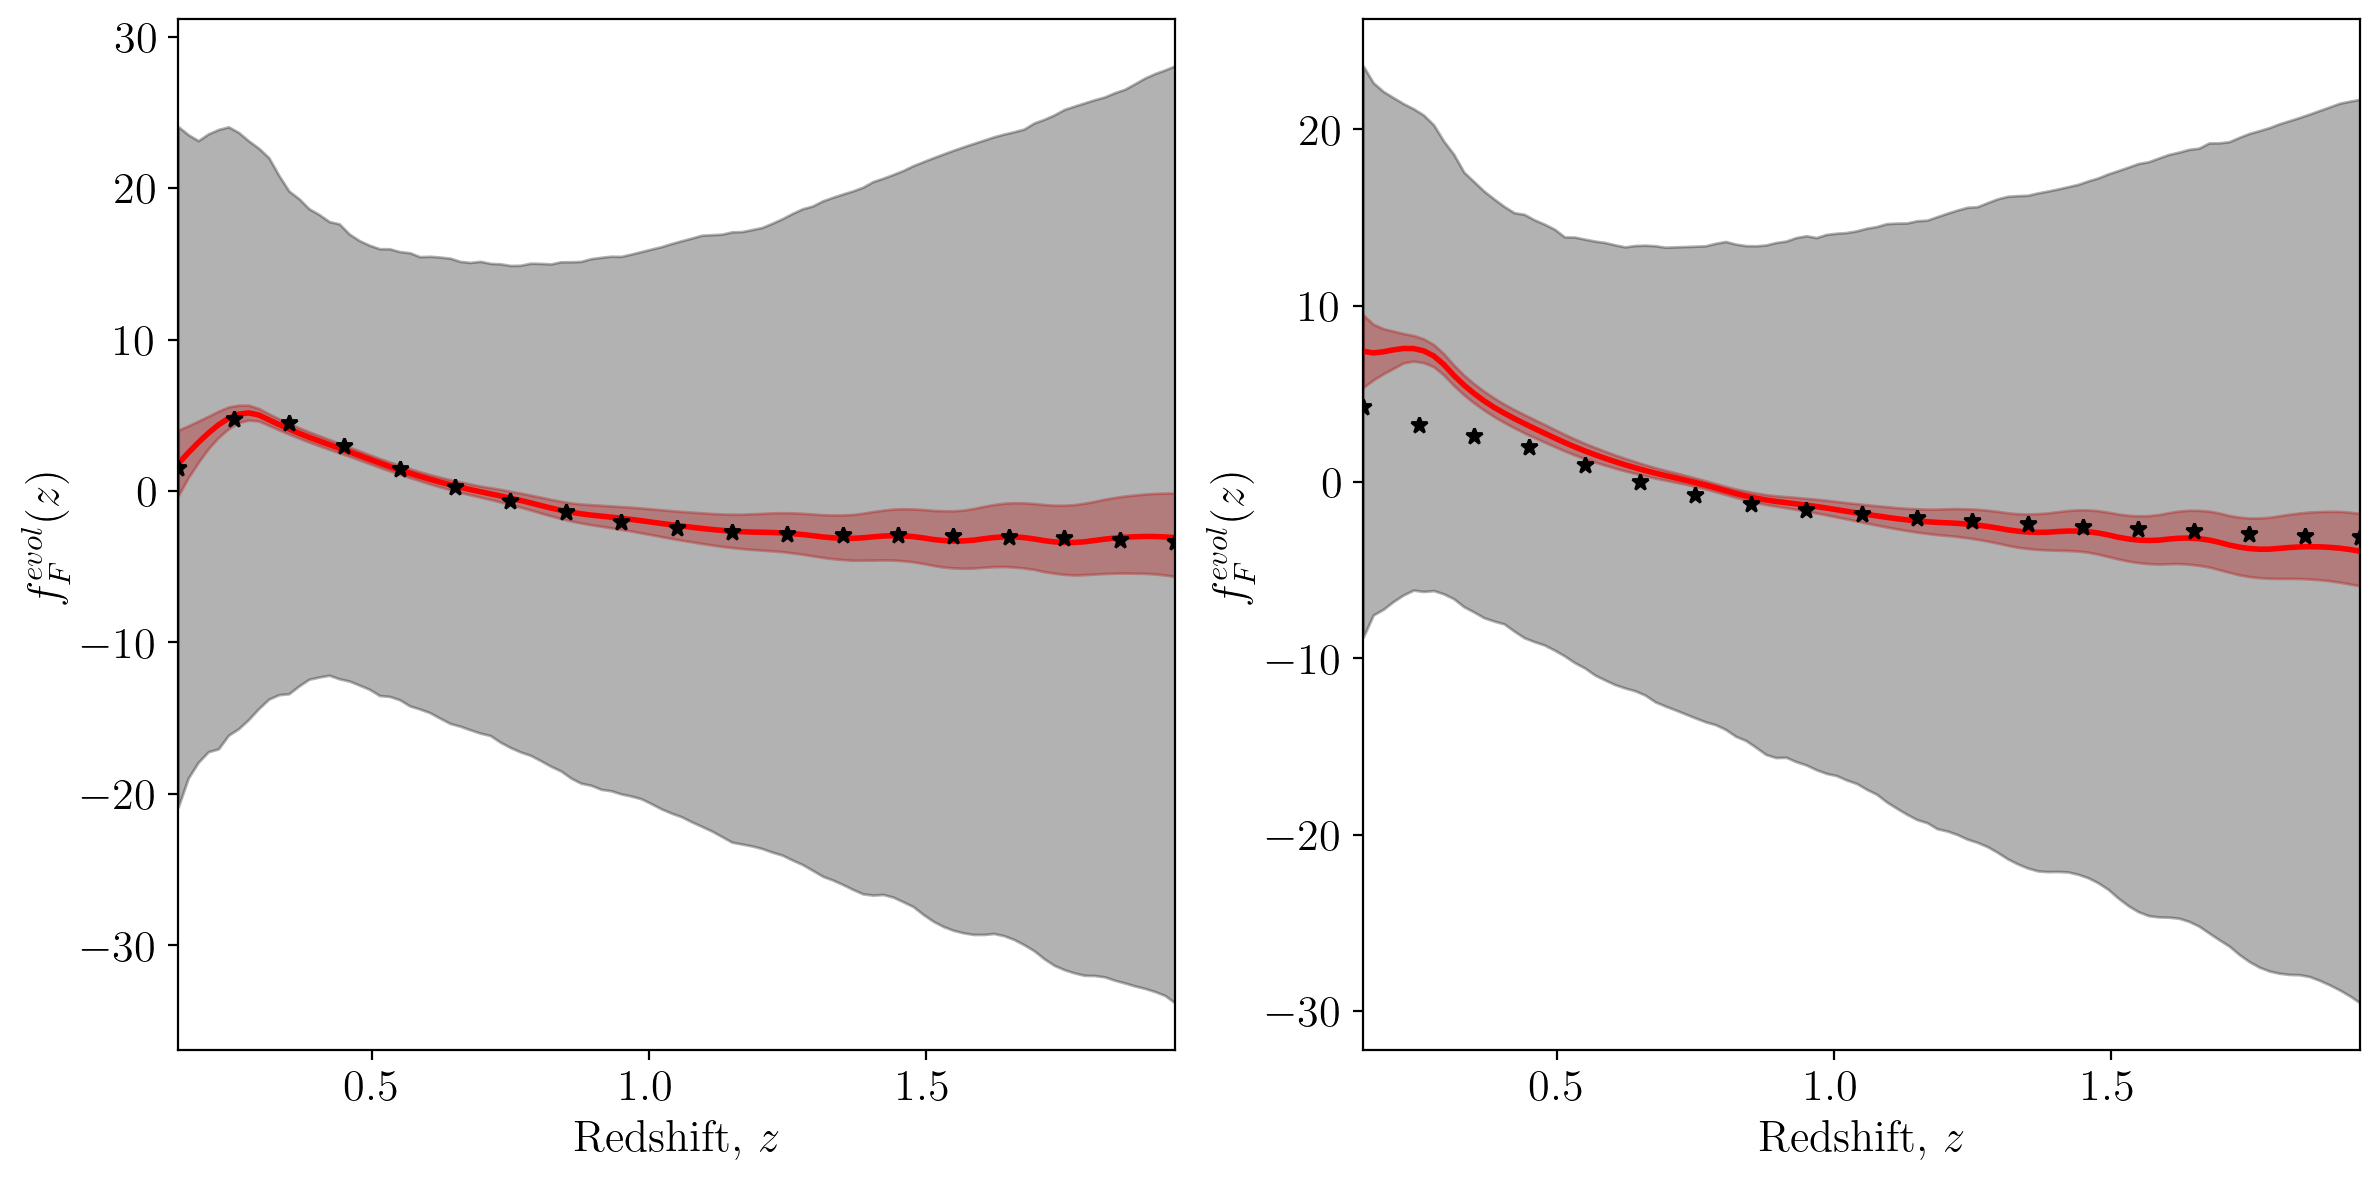

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')

# Comparison with Individual Splits

## Magnification bias

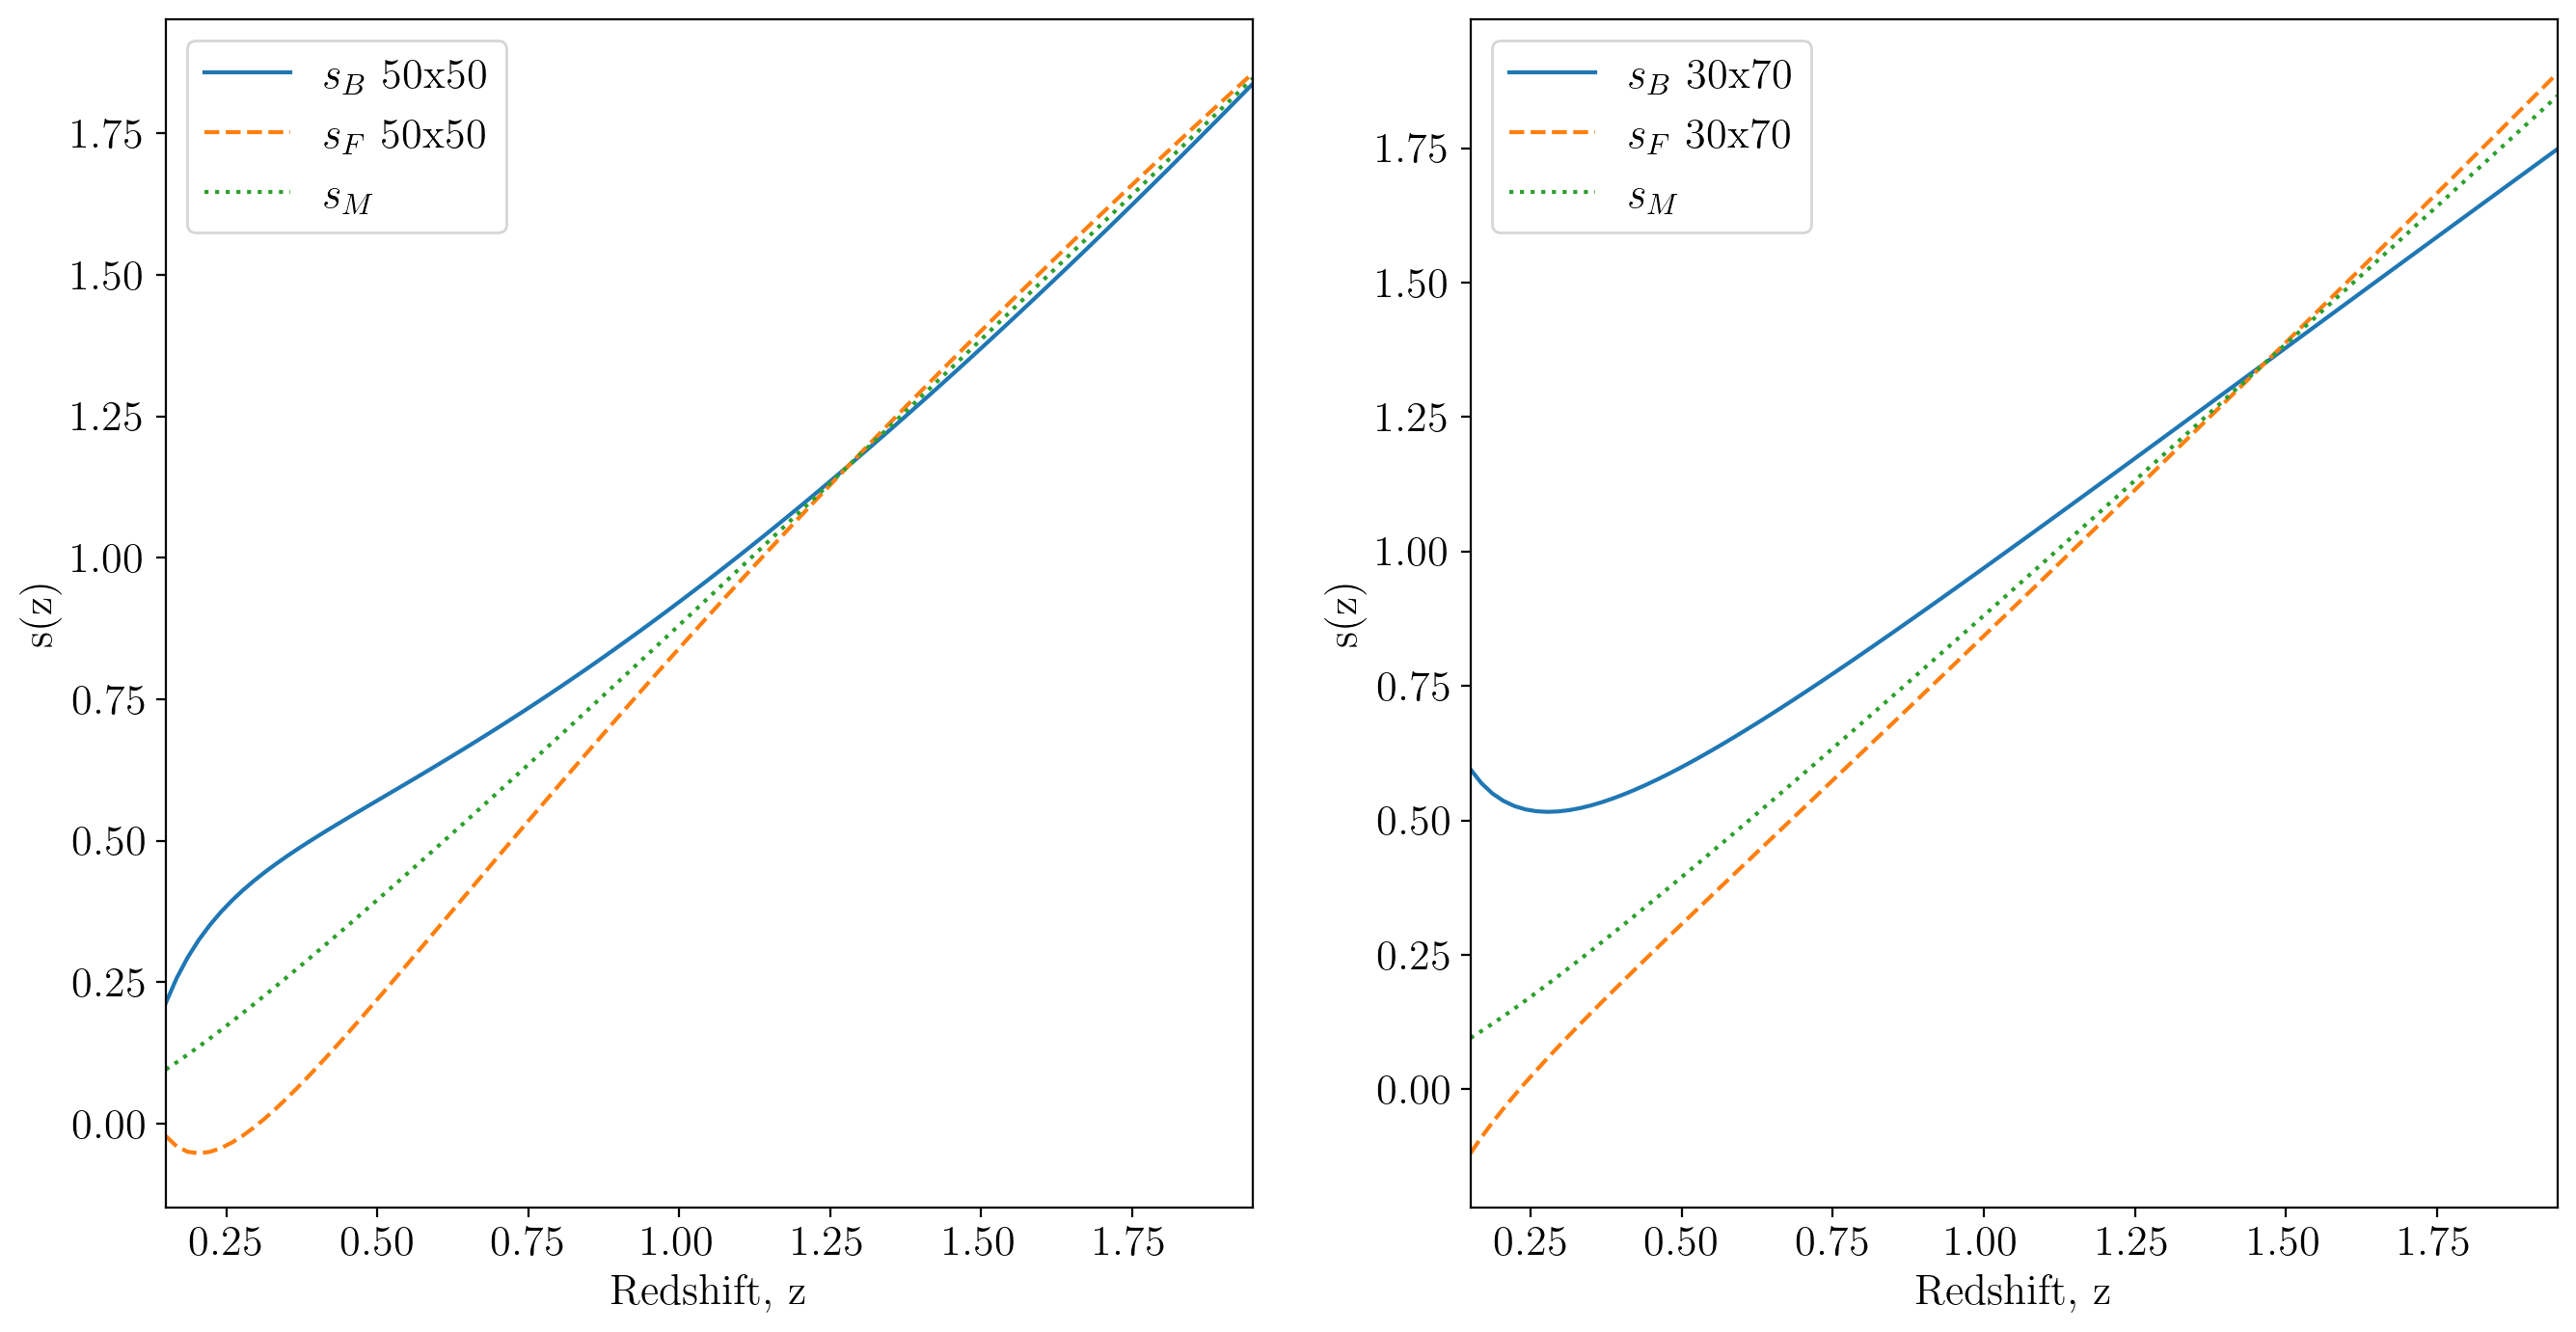

In [116]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [117]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit70, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


In [118]:
np.shape(Sigma_Matrix_30)

(21, 21)

In [119]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_50 = Sigma_Matrix_50[:4, :4]
cov_sB_30 = Sigma_Matrix_30[:4, :4]
cov_sM_50 = Sigma_Matrix_50[4:8, 4:8]
cov_sM_30 = Sigma_Matrix_30[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_50, num_samples)
sB_30_pars_samples = np.random.multivariate_normal(sB_4fit70, cov_sB_30, num_samples)
sM_50_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_50, num_samples)
sM_30_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_30, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_30_pars_samples])

# Calculate the 68% confidence interval
sB_50_lower_bound = np.percentile(sB_50_samples, 16, axis=0)
sB_50_upper_bound = np.percentile(sB_50_samples, 84, axis=0)

sB_30_lower_bound = np.percentile(sB_30_samples, 16, axis=0)
sB_30_upper_bound = np.percentile(sB_30_samples, 84, axis=0)

sM_50_lower_bound = np.percentile(sM_50_samples, 16, axis=0)
sM_50_upper_bound = np.percentile(sM_50_samples, 84, axis=0)
sM_30_lower_bound = np.percentile(sM_30_samples, 16, axis=0)
sM_30_upper_bound = np.percentile(sM_30_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

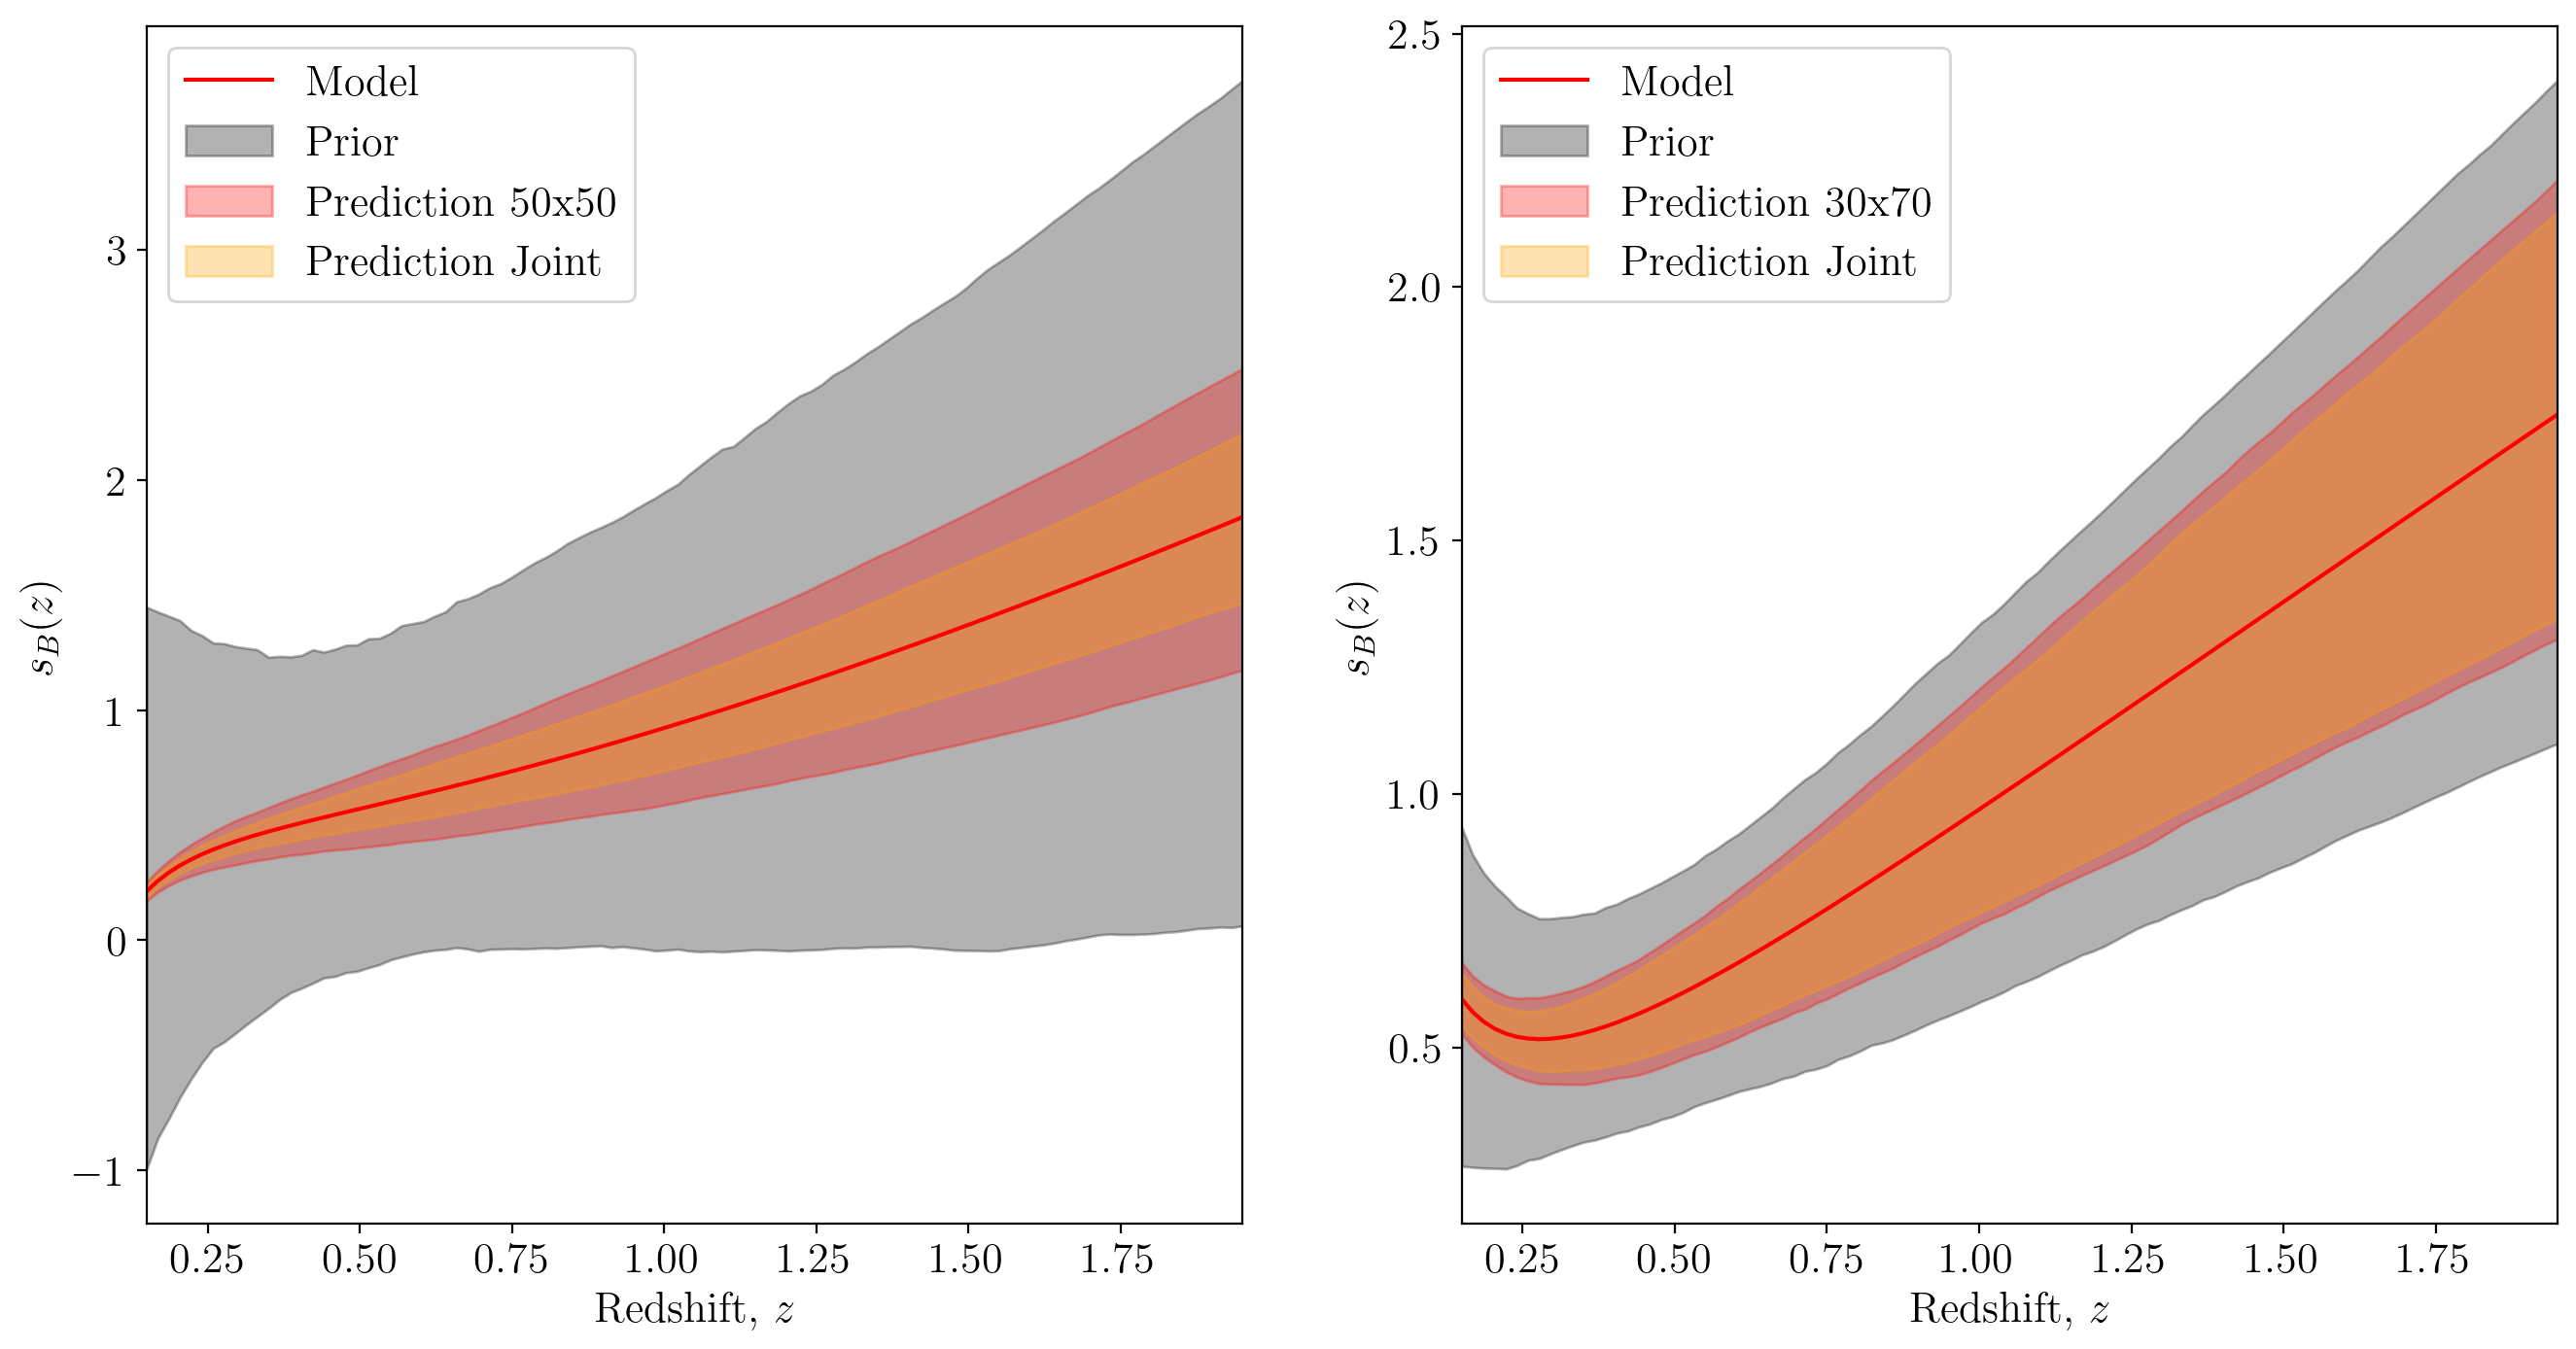

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-', label = r'Model')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sB_50_lower_bound, sB_50_upper_bound, color='red', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')
ax[0].legend(loc='upper left')

ax[1].plot(z_lin, sB_fid_30, 'r-', label = r'Model')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sB_30_lower_bound, sB_30_upper_bound, color='red', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')
ax[1].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$s_B(z)$')
    
plt.savefig("plots/sB_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')

Predictions for $s_M(z)$ vs Priors

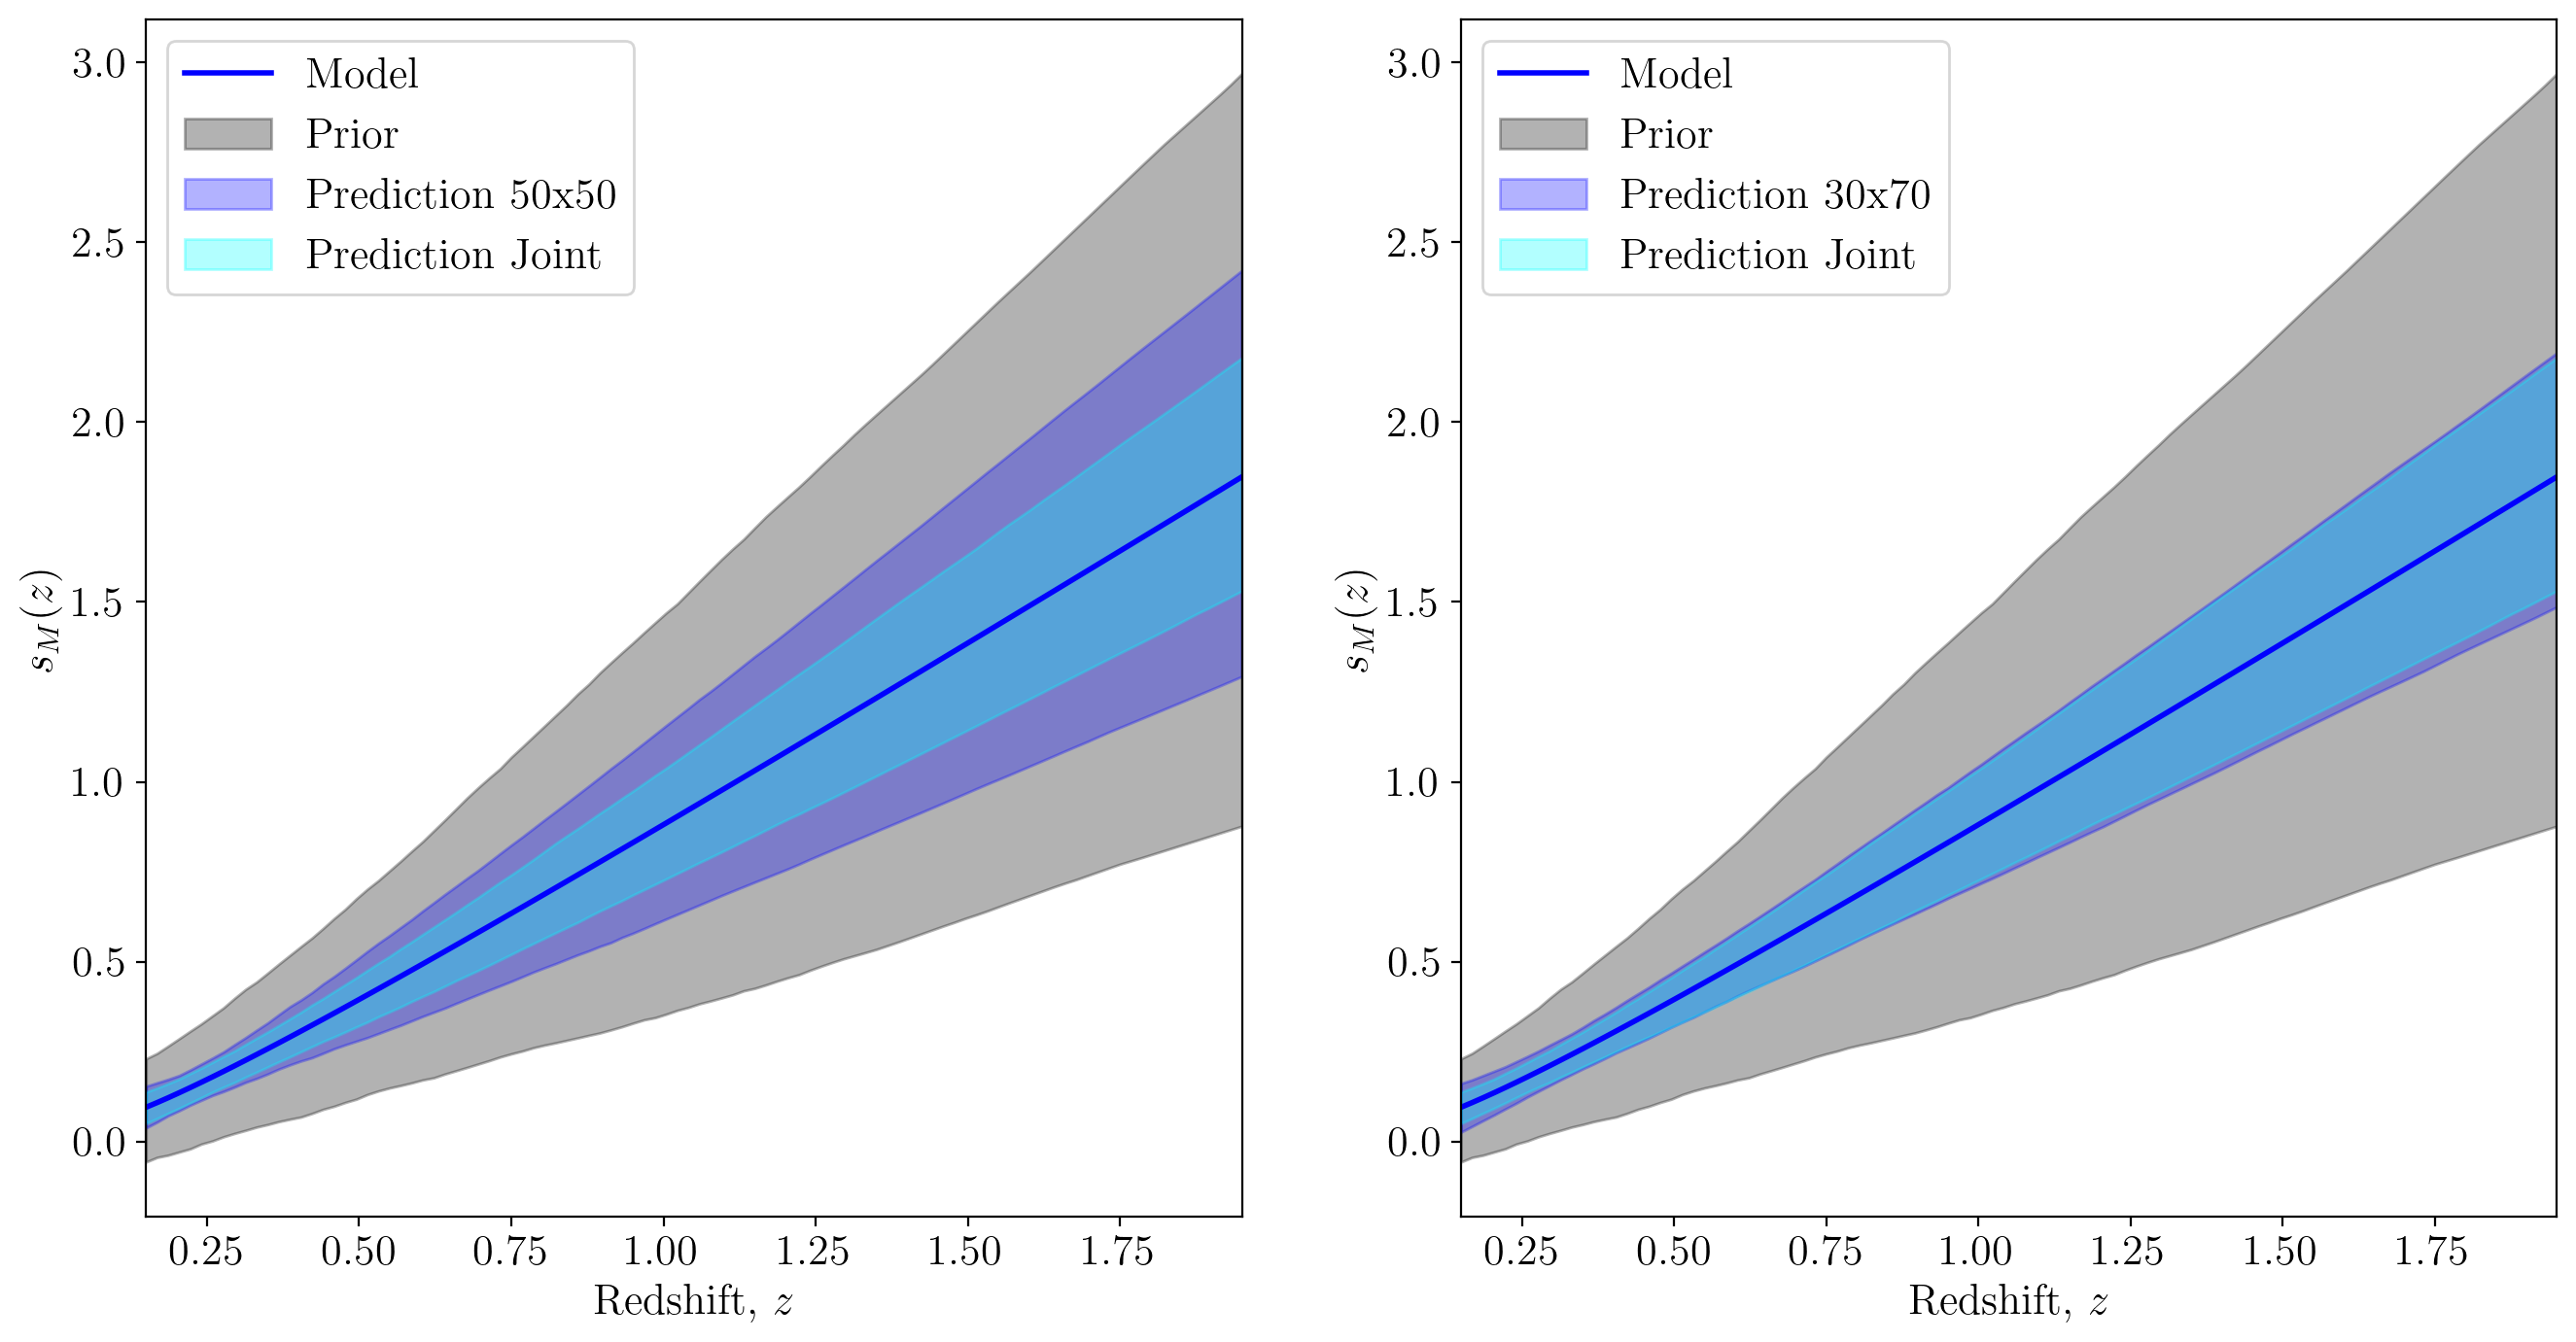

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

for axi in ax:
    axi.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[0].fill_between(z_lin, sM_50_lower_bound, sM_50_upper_bound, color='blue', alpha=0.3, label = r'Prediction 50x50')
ax[0].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='cyan', alpha=0.3, label = r'Prediction Joint')

ax[1].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[1].fill_between(z_lin, sM_30_lower_bound, sM_30_upper_bound, color='blue', alpha=0.3, label = r'Prediction 30x70')
ax[1].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='cyan', alpha=0.3, label = r'Prediction Joint')
    
for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, $z$');
    axi.set_ylabel(r'$s_M(z)$');
    axi.legend(loc='upper left');
    
plt.savefig("plots/sM_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')


### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_M$ parameters.

In [122]:
sbias_50_fid = np.concatenate([sB_4fit50, sM_4fit])
sbias_30_fid = np.concatenate([sB_4fit70, sM_4fit])

np.shape(sbias_50_fid), np.shape(sbias_30_fid)

((8,), (8,))

In [123]:
# Select the marginalized covariance matrix for the magnification biases together
cov_50_sbias = Sigma_Matrix_50[:8, :8]
cov_30_sbias = Sigma_Matrix_30[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples = np.random.multivariate_normal(sbias_50_fid, cov_50_sbias, num_samples)
sbias_30_pars_samples = np.random.multivariate_normal(sbias_30_fid, cov_30_sbias, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples])


# Compute the sF for each sample
sF_50_samples = sM_50_samples*m_50/(m_50-1) - sB_50_samples/(m_50-1)
sF_30_samples = sM_30_samples*m_30/(m_30-1) - sB_30_samples/(m_30-1)


# Calculate the 68% confidence interval
sF_50_lower_bound = np.percentile(sF_50_samples, 16, axis=0)
sF_50_upper_bound = np.percentile(sF_50_samples, 84, axis=0)

sF_30_lower_bound = np.percentile(sF_30_samples, 16, axis=0)
sF_30_upper_bound = np.percentile(sF_30_samples, 84, axis=0)

Compare with priors

In [124]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_50_priors = Cov_priors_50[:8, :8]
cov_sbias_30_priors = Cov_priors_30[:8, :8]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples_priors = np.random.multivariate_normal(sbias_50_fid, cov_sbias_50_priors, num_samples)
sbias_30_pars_samples_priors = np.random.multivariate_normal(sbias_30_fid, cov_sbias_30_priors, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples_priors])
sM_50_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples_priors])
sM_30_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples_priors])

# Compute the sF for each sample
sF_50_samples_priors = sM_50_samples_priors*m_50/(m_50-1) - sB_50_samples_priors/(m_50-1)
sF_30_samples_priors = sM_30_samples_priors*m_30/(m_30-1) - sB_30_samples_priors/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors = np.percentile(sF_50_samples_priors, 16, axis=0)
sF_50_upper_bound_priors = np.percentile(sF_50_samples_priors, 84, axis=0)

sF_30_lower_bound_priors = np.percentile(sF_30_samples_priors, 16, axis=0)
sF_30_upper_bound_priors = np.percentile(sF_30_samples_priors, 84, axis=0)

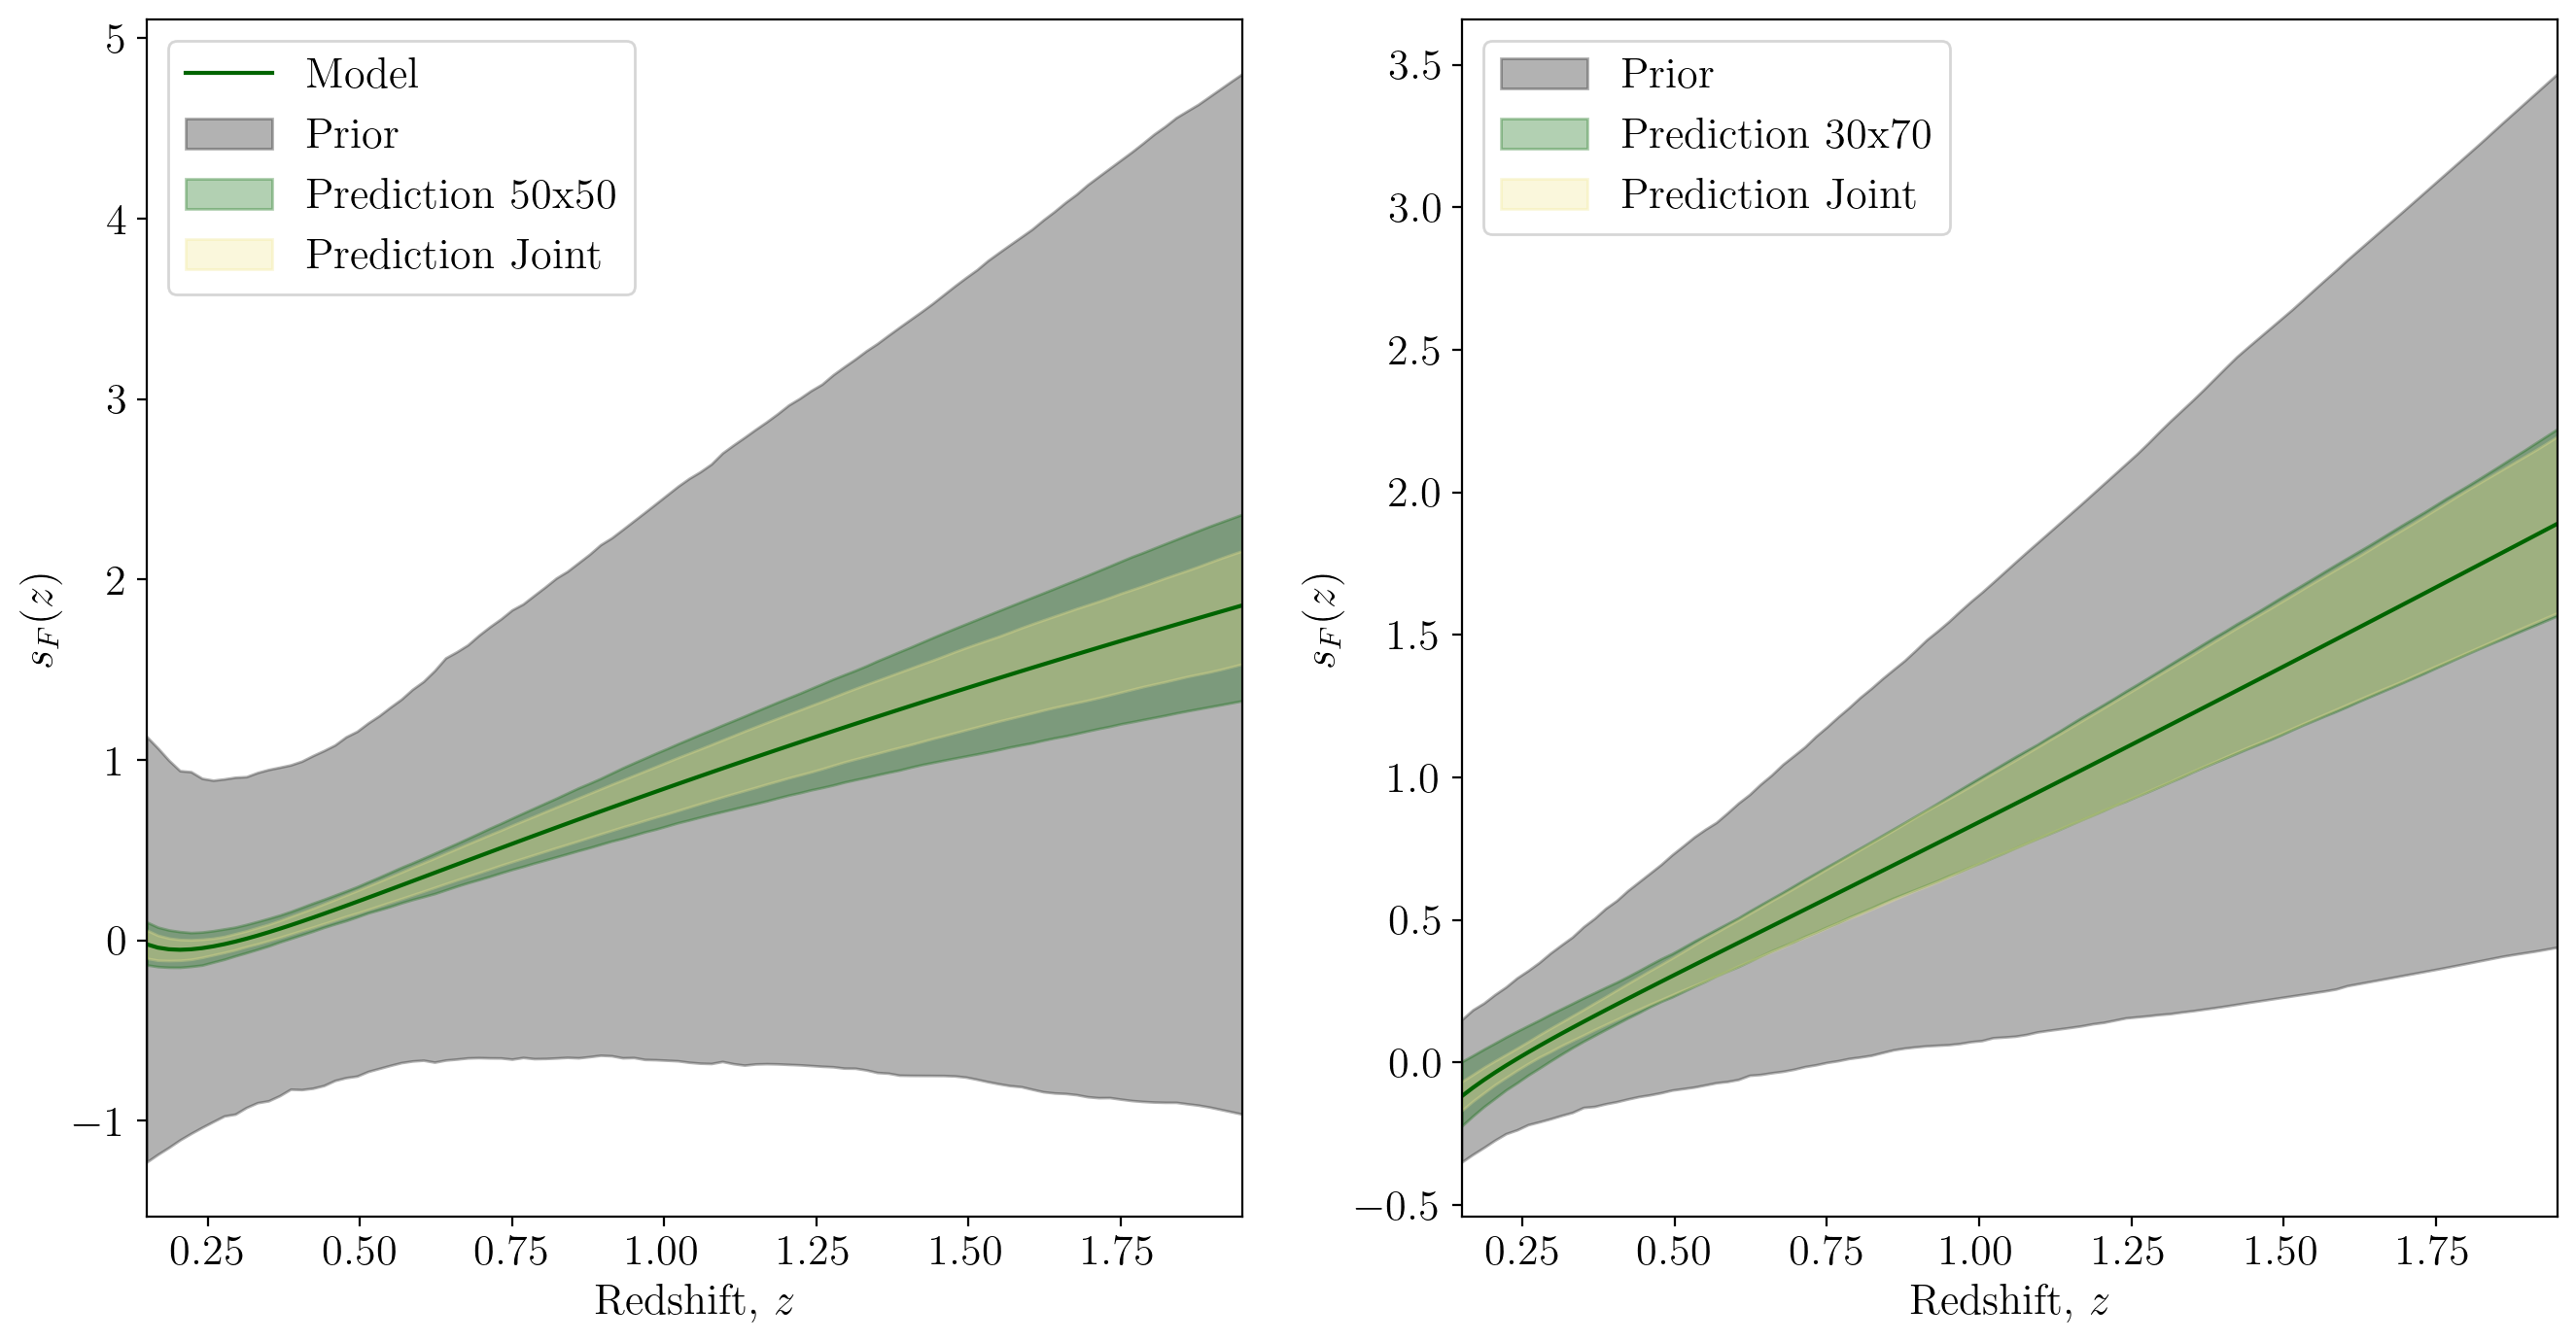

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'darkgreen', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_lower_bound, sF_50_upper_bound, color='darkgreen', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='khaki', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'darkgreen')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sF_30_lower_bound, sF_30_upper_bound, color='darkgreen', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='khaki', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$s_F(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/sF_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')

## Number evolution

In [126]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

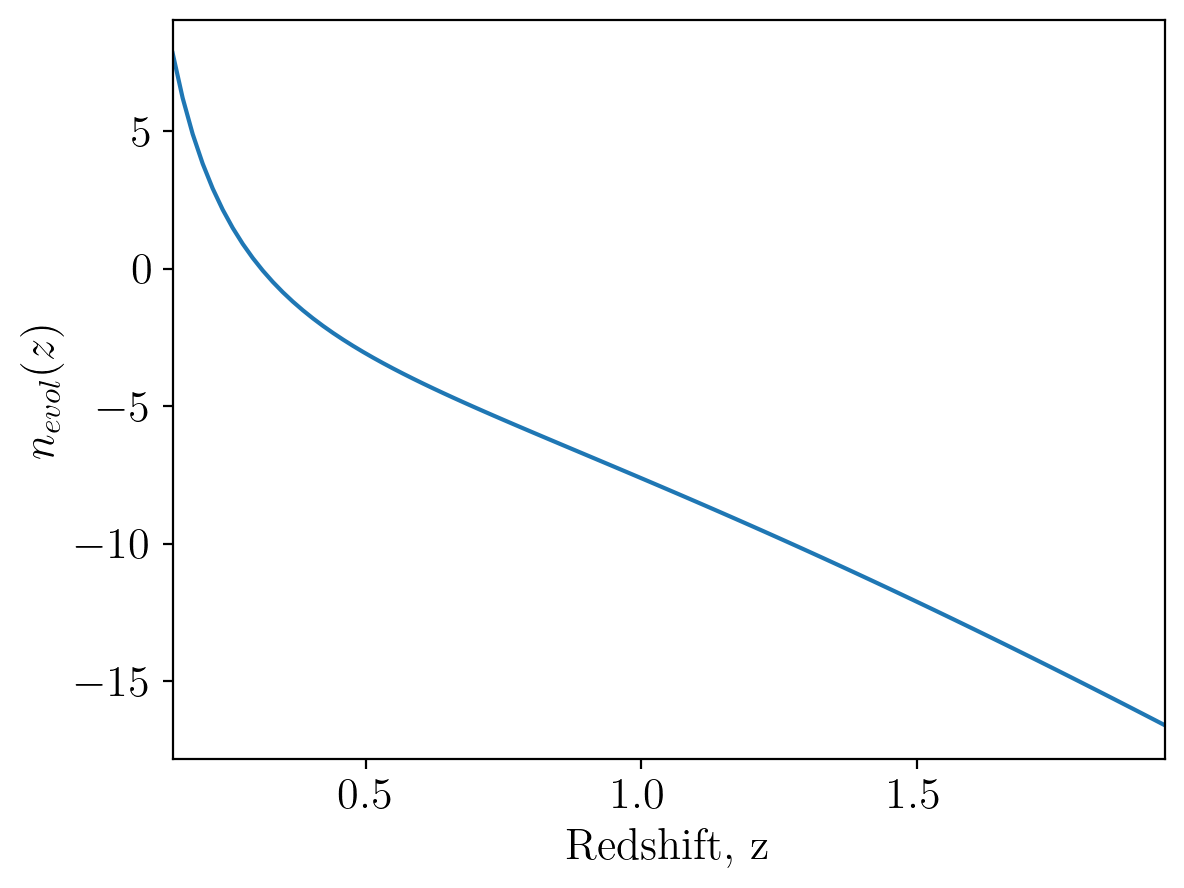

In [127]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [128]:
# Select the marginalized covariance matrix for the number evolution

cov_50_numevol = Sigma_Matrix_50[8:12,8:12]
cov_30_numevol = Sigma_Matrix_30[8:12,8:12]



# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_50_pars_samples = np.random.multivariate_normal(num_fit, cov_50_numevol, num_samples)
nevol_30_pars_samples = np.random.multivariate_normal(num_fit, cov_30_numevol, num_samples)


# Evaluate fitting function for each parameter sample
nevol_50_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_50_pars_samples])
nevol_30_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_30_pars_samples])

# Calculate the 68% confidence interval
nevol_50_lower_bound = np.percentile(nevol_50_samples, 16, axis=0)
nevol_50_upper_bound = np.percentile(nevol_50_samples, 84, axis=0)
nevol_30_lower_bound = np.percentile(nevol_30_samples, 16, axis=0)
nevol_30_upper_bound = np.percentile(nevol_30_samples, 84, axis=0)


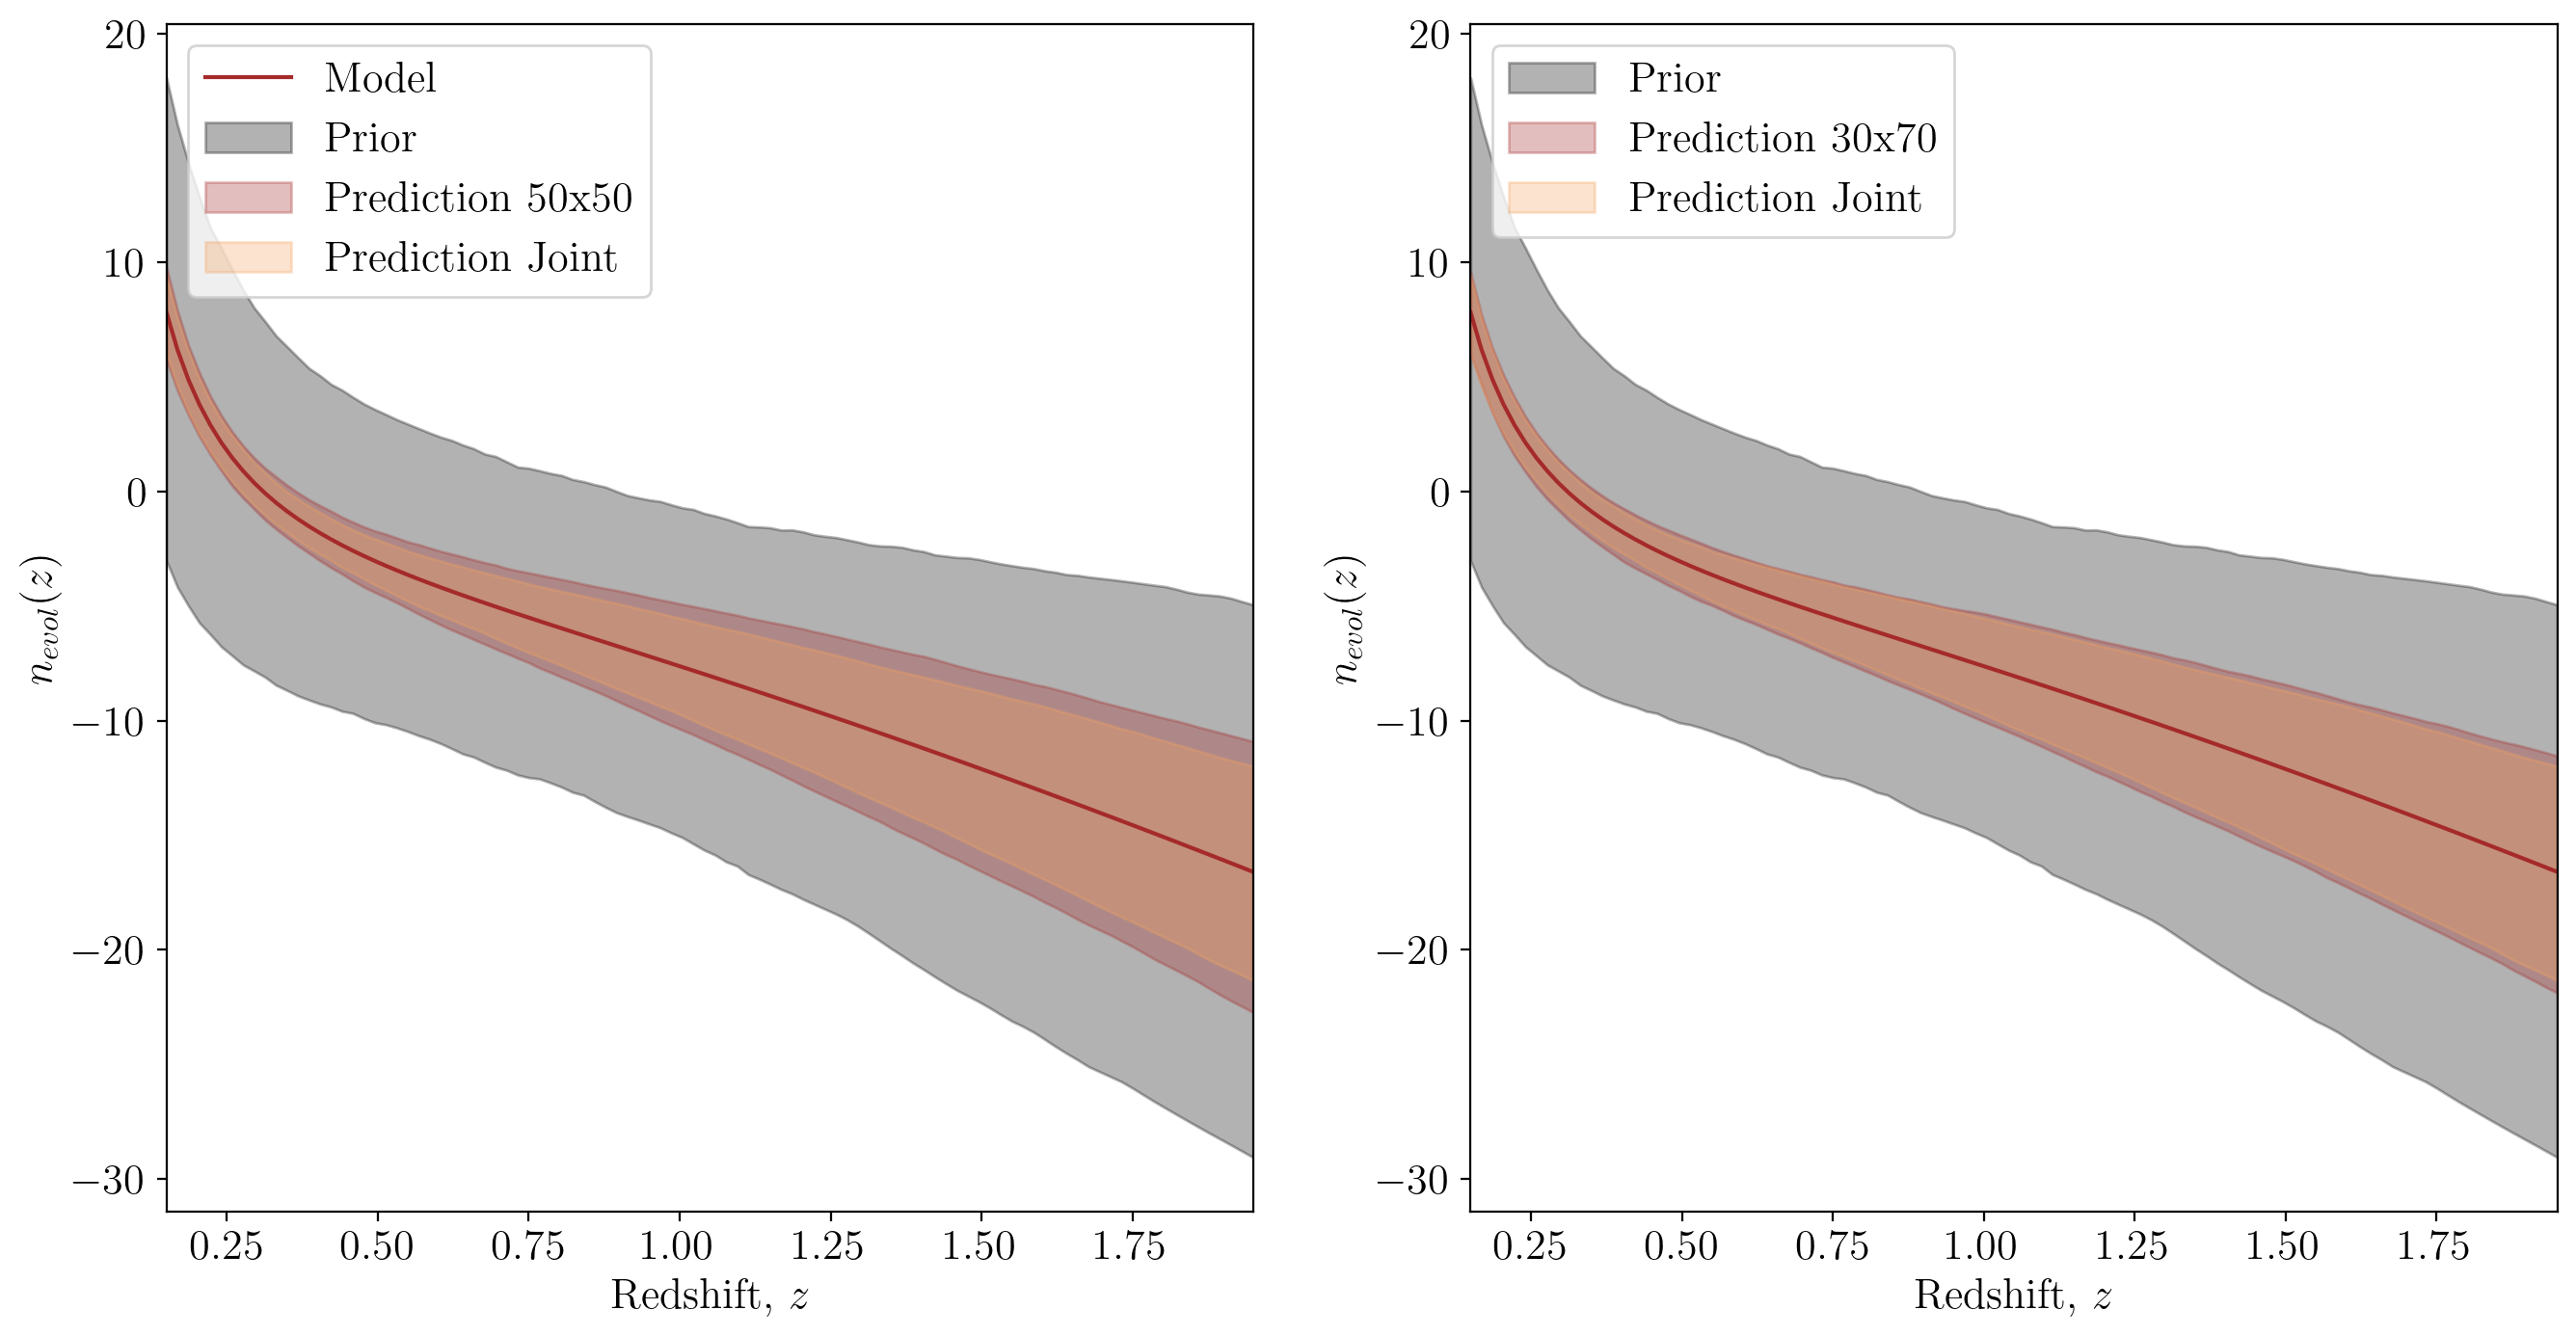

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, num_evol_fid, '-', color = 'brown', label = 'Model')
ax[0].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, nevol_50_lower_bound, nevol_50_upper_bound, color='brown', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='sandybrown', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, num_evol_fid, '-', color = 'brown')
ax[1].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, nevol_30_lower_bound, nevol_30_upper_bound, color='brown', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='sandybrown', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$n_{evol}(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/nevol_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [130]:
from biasmodels import EvolutionBias

In [131]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [132]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [133]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit70, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

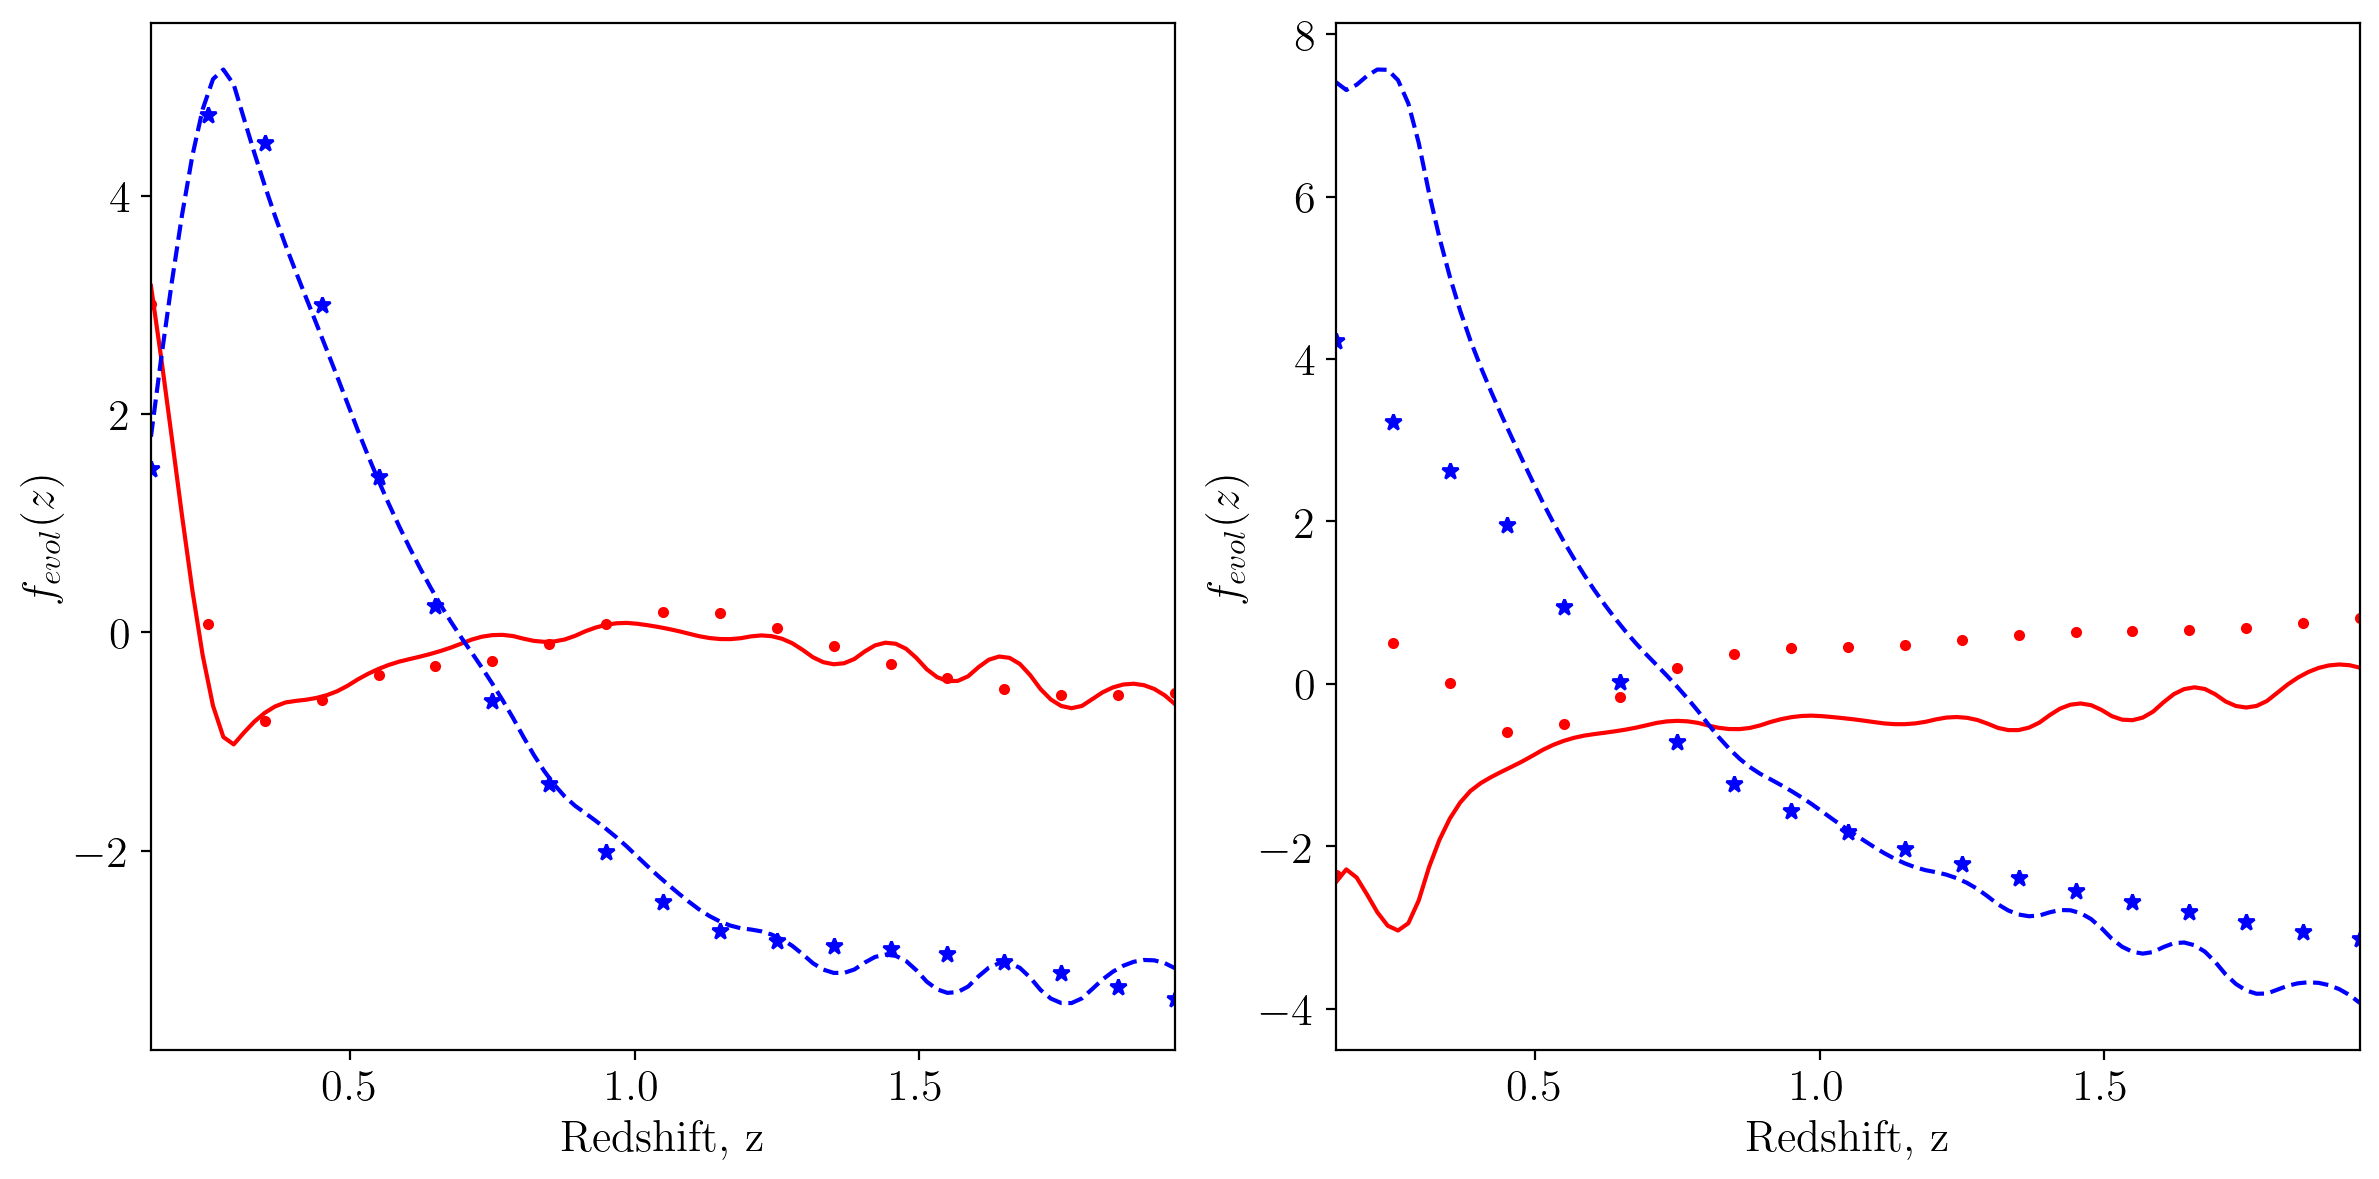

In [134]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [135]:
all_50_fid = np.concatenate([sB_4fit50, sM_4fit, num_fit])
all_30_fid = np.concatenate([sB_4fit70, sM_4fit, num_fit])

np.shape(all_50_fid), np.shape(all_30_fid)

((12,), (12,))

In [136]:
# Select the marginalized covariance matrix for the parameters

cov_50_all = Sigma_Matrix_50[:12, :12]
cov_30_all = Sigma_Matrix_30[:12, :12]
cov_50_priors = Cov_priors_50[:12, :12]
cov_30_priors = Cov_priors_30[:12, :12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_50_pars_samples = np.random.multivariate_normal(all_50_fid, cov_50_all, num_samples)
all_50_pars_samples_priors_ = np.random.multivariate_normal(all_50_fid, cov_50_priors, num_samples)
all_30_pars_samples = np.random.multivariate_normal(all_30_fid, cov_30_all, num_samples)
all_30_pars_samples_priors_ = np.random.multivariate_normal(all_30_fid, cov_30_priors, num_samples)

In [137]:
# Evaluate fitting function for each parameter sample

fevol_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])
fevol_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])

fevol_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])
fevol_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound_ = np.percentile(fevol_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound_ = np.percentile(fevol_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 16, axis=0)
fevol_B_50_upper_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 84, axis=0)

fevol_F_50_lower_bound_ = np.percentile(fevol_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound_ = np.percentile(fevol_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 16, axis=0)
fevol_F_50_upper_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 84, axis=0)

fevol_B_30_lower_bound_ = np.percentile(fevol_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound_ = np.percentile(fevol_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 16, axis=0)
fevol_B_30_upper_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 84, axis=0)

fevol_F_30_lower_bound_ = np.percentile(fevol_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound_ = np.percentile(fevol_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 16, axis=0)
fevol_F_30_upper_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 84, axis=0)

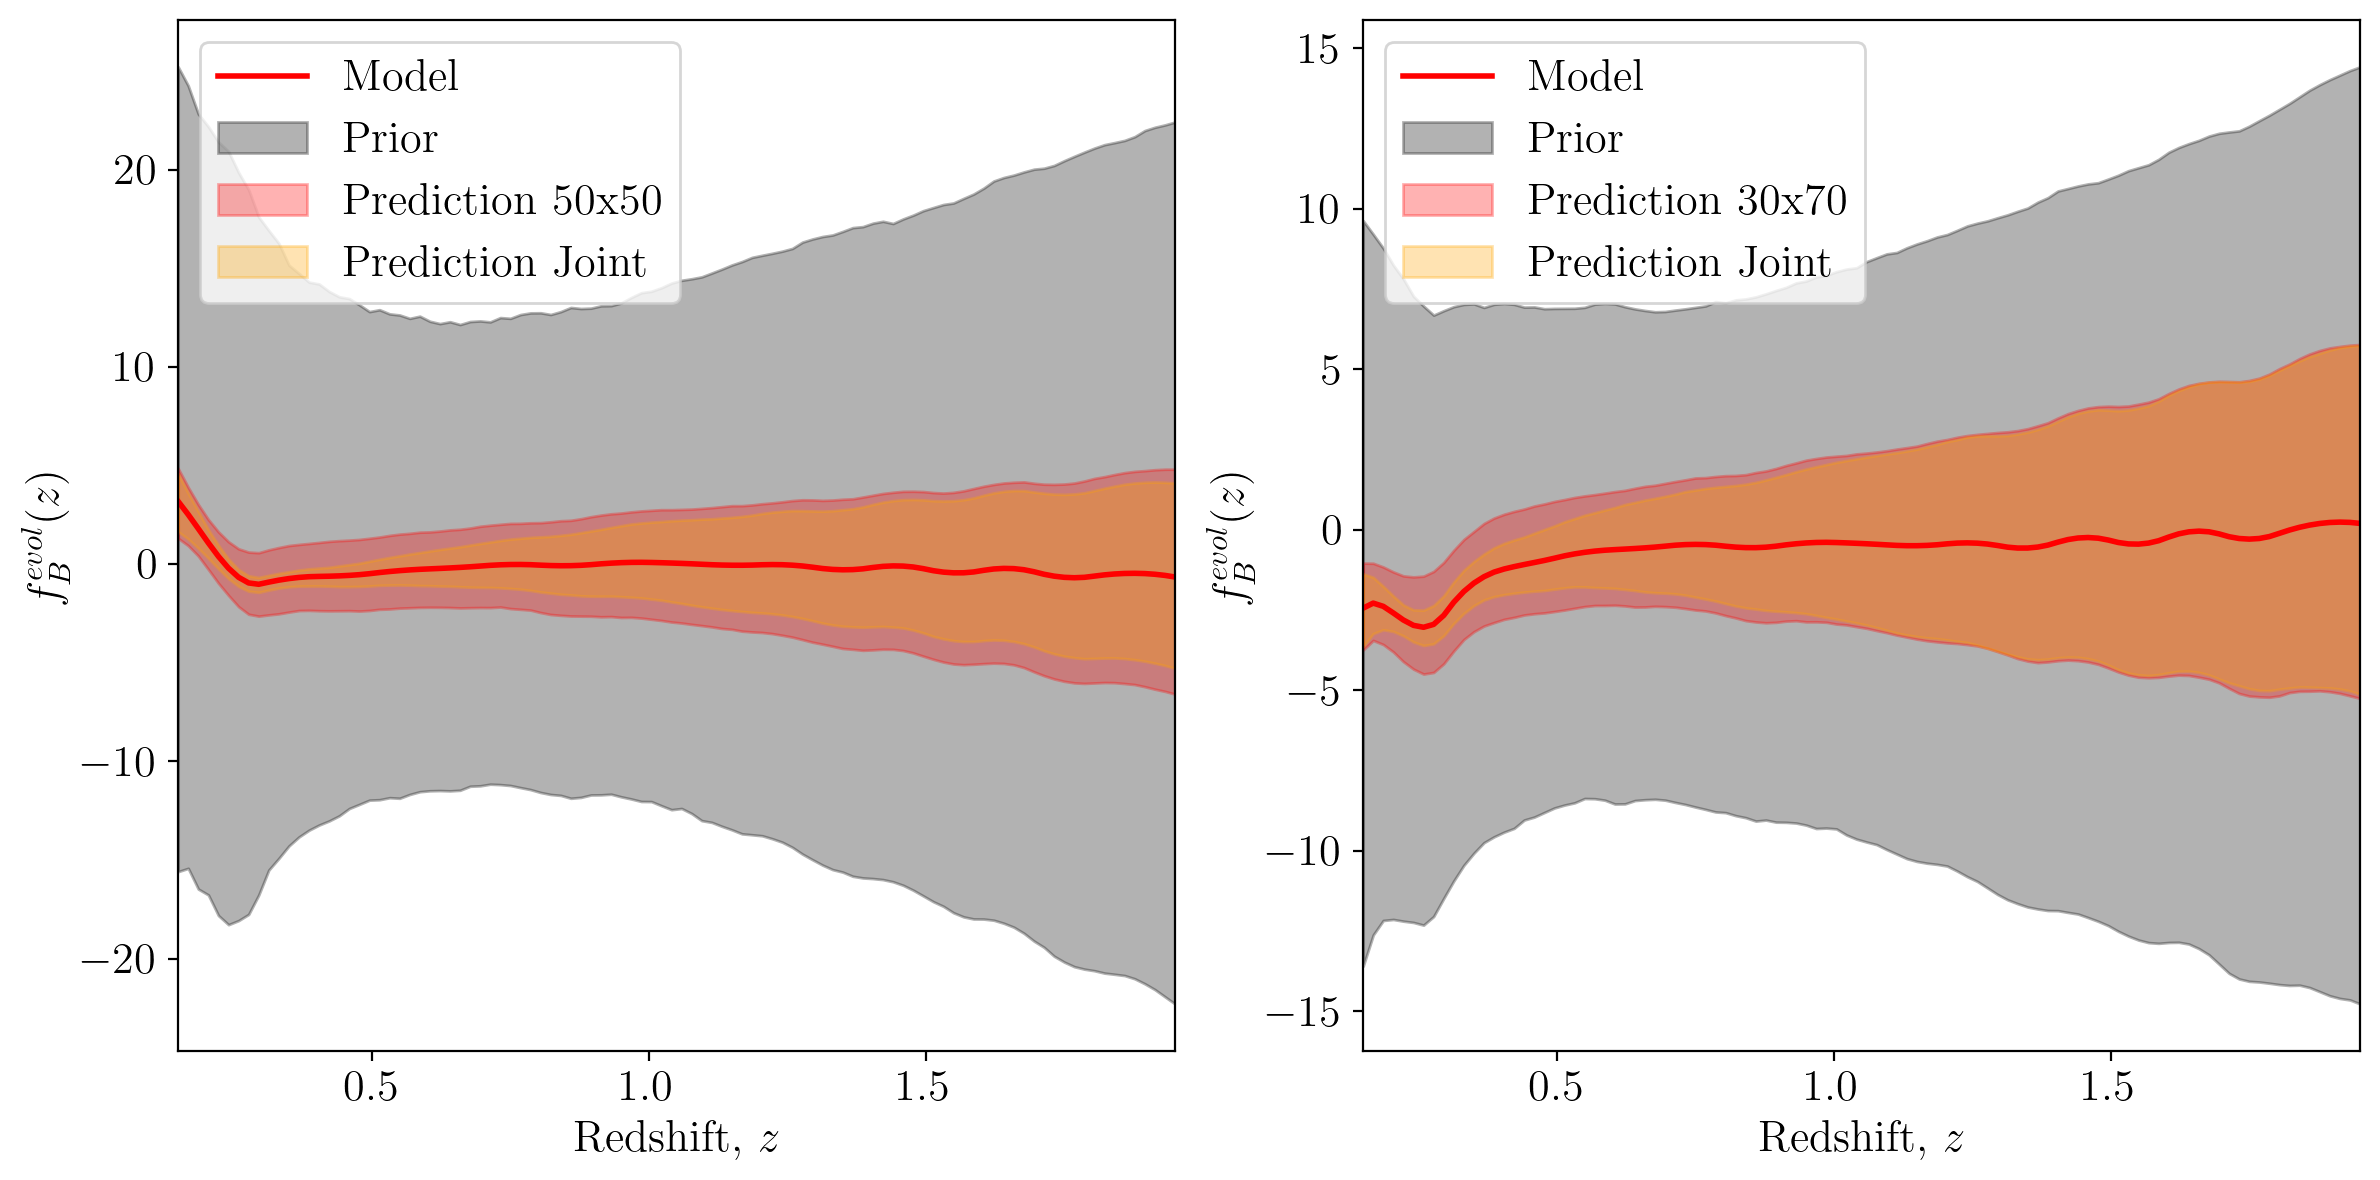

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0, label = 'Model')
#ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0, label = 'Model')
#ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_, fevol_B_50_upper_bound_, color='red', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')

ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_, fevol_B_30_upper_bound_, color='red', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/fevolB_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')

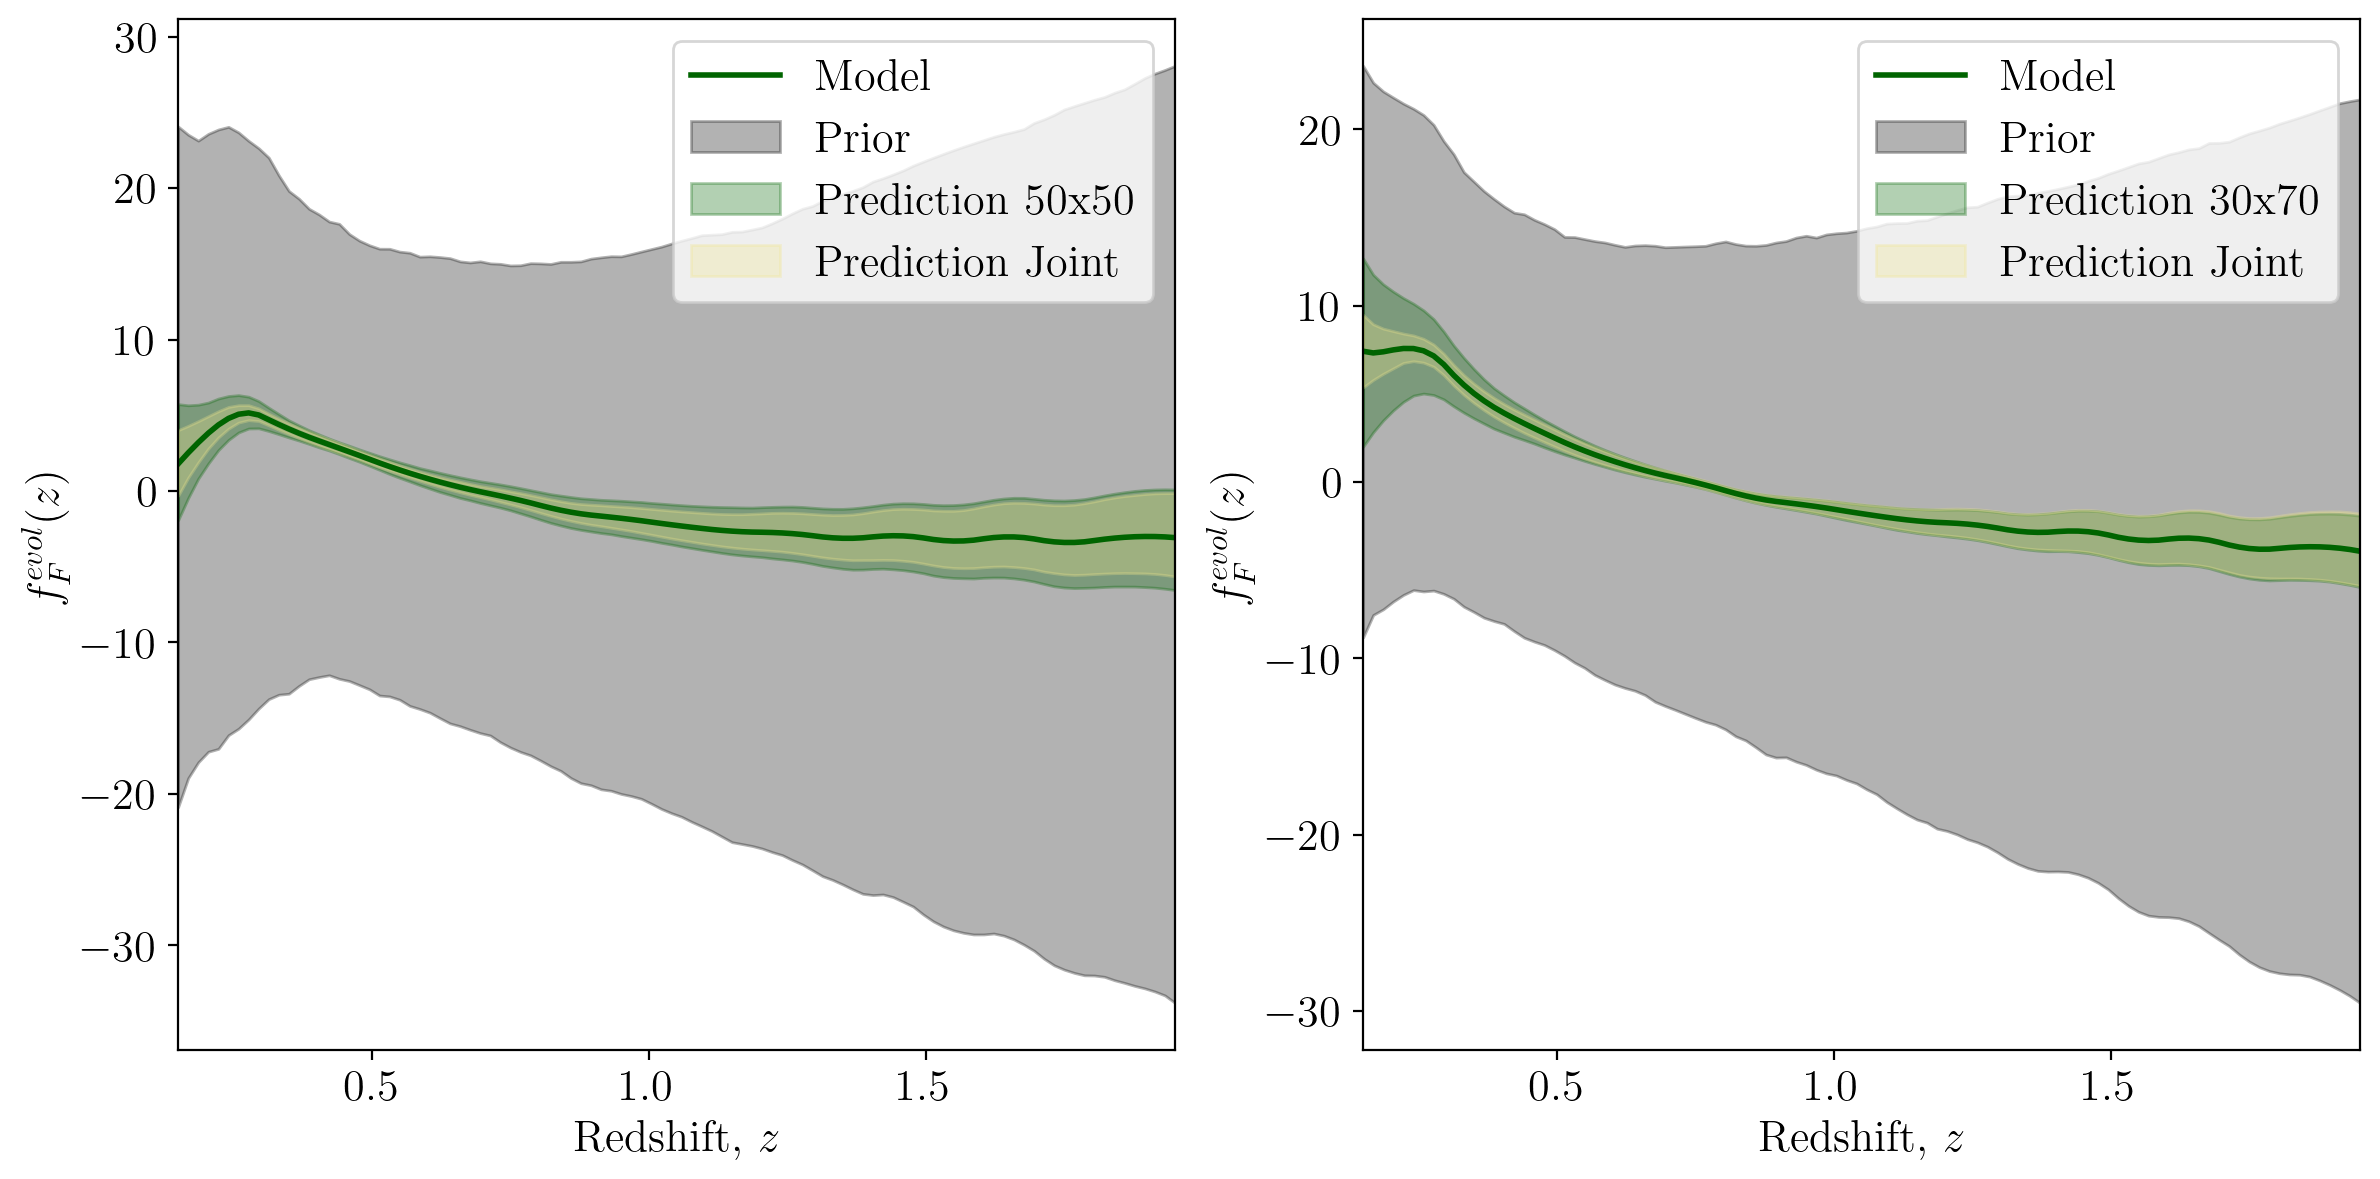

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='darkgreen', lw = 2.0, label = 'Model')
#ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='darkgreen', lw = 2.0, label ='Model')
#ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_, fevol_F_50_upper_bound_, color='darkgreen', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='khaki', alpha=0.3, label = 'Prediction Joint')


ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_, fevol_F_30_upper_bound_, color='darkgreen', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='khaki', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')
    axi.legend(loc='upper right')
    
plt.savefig("plots/fevolF_prediction_joint_shotnoise_vs_prior.pdf", bbox_inches='tight', format='pdf')